In [1]:
import pandas as pd
import sqlite3
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
# import lgbm regressor
from lightgbm import LGBMRegressor

# import mean squared error from sklearn metrics
from sklearn.metrics import mean_squared_error
# import all regression metrics from sklearn metrics
from sklearn.metrics import *



# change pandas config to see all columns
pd.set_option('display.max_columns', 500)

# get data from acitivities table in strava.db
conn = sqlite3.connect('strava.db')
df = pd.read_sql_query("SELECT * FROM activities", conn)
conn.close()

# these are spinning sessions TODO change in table in db
# when type is Ride and mean_watts is null type to VirtualRide
df.loc[(df['type'] == 'Ride') & (df['mean_watts'].isnull()), 'type'] = 'VirtualRide'

# TODO change this in database as these are VirtualRides
# if type Ride and elev_gain is 0 set to VirtualRide
df.loc[(df['type'] == 'Ride') & (df['elev_gain'] == 0), 'type'] = 'VirtualRide'


# Outliers capped
# for type = Ride cap mean_hr at 170 for dataframe df
df.loc[(df.type == "Ride") & (df.mean_hr > 170), "mean_hr"] = 170
# for type = Ride cap max_hr at 180 for dataframe df
df.loc[(df.type == "Ride") & (df.max_hr > 180), "max_hr"] = 180
# 

In [2]:
df.shape

(1239, 21)

In [4]:
df.head()

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8239806204         108.0   175.0    155.8       198.1     None   
1   8232572924          73.0   170.0    144.3       187.0     None   
2   8222534583          65.0   166.0    140.7         NaN     None   
3   8214224868          46.0   176.0    146.0       185.6     None   
4   8177784293          54.0   166.0    147.3       209.4     None   

     moving_time   elapsed_time         type                 start_date  \
0  2704000000000  2704000000000  VirtualRide  2022-12-12 13:54:36+00:00   
1  2955000000000  2955000000000  VirtualRide  2022-12-10 16:58:08+00:00   
2  3139000000000  3139000000000      Workout  2022-12-08 05:20:46+00:00   
3  1785000000000  1785000000000  VirtualRide  2022-12-06 11:25:01+00:00   
4  1976000000000  2181000000000         Ride  2022-11-27 20:08:18+00:00   

                                      name  weighted_mean_watts  elev_gain  \
0  Wahoo SYSTM: Revolver is Easy (Mash-Up)                217.0        0.0   
1                    Wahoo SYSTM: Revolver                212.0        0.0   
2                              MMA Fitness                  NaN        0.0   
3                     Wahoo SYSTM: Joyride                215.0        0.0   
4                              Night Ride                   NaN      187.0   

   kilojoules  average_speed  distance  year        date  hour  \
0       535.7           8.47   22895.6  2022  2022-12-12    13   
1       552.5           8.24   24354.4  2022  2022-12-10    16   
2         NaN           0.00       0.0  2022  2022-12-08     5   
3       331.3           8.24   14713.7  2022  2022-12-06    11   
4       413.8           4.97    9831.2  2022  2022-11-27    20   

   moving_time_min  elapsed_time_min  
0        45.066667         45.066667  
1        49.250000         49.250000  
2        52.316667         52.316667  
3        29.750000         29.750000  
4        32.933333         36.350000

# Clustering

In [982]:
# get all numerical columns except any column name with _id in it 
df_num = df.select_dtypes(include=np.number)
df_num = df_num.loc[:, ~df_num.columns.str.contains('_id')]
df_num.head()

# drop moving_time and elapsed_time
df_num = df_num.drop(['moving_time', 'elapsed_time'], axis=1)
df_num.head()


suffer_score  max_hr  mean_hr  mean_watts  weighted_mean_watts  elev_gain  \
0         108.0   175.0    155.8       198.1                217.0        0.0   
1          73.0   170.0    144.3       187.0                212.0        0.0   
2          65.0   166.0    140.7         NaN                  NaN        0.0   
3          46.0   176.0    146.0       185.6                215.0        0.0   
4          54.0   166.0    147.3       209.4                  NaN      187.0   

   kilojoules  average_speed  distance  year  hour  moving_time_min  \
0       535.7           8.47   22895.6  2022    13        45.066667   
1       552.5           8.24   24354.4  2022    16        49.250000   
2         NaN           0.00       0.0  2022     5        52.316667   
3       331.3           8.24   14713.7  2022    11        29.750000   
4       413.8           4.97    9831.2  2022    20        32.933333   

   elapsed_time_min  
0         45.066667  
1         49.250000  
2         52.316667  
3         29.750000  
4         36.350000

In [983]:
df_num.head()

suffer_score  max_hr  mean_hr  mean_watts  weighted_mean_watts  elev_gain  \
0         108.0   175.0    155.8       198.1                217.0        0.0   
1          73.0   170.0    144.3       187.0                212.0        0.0   
2          65.0   166.0    140.7         NaN                  NaN        0.0   
3          46.0   176.0    146.0       185.6                215.0        0.0   
4          54.0   166.0    147.3       209.4                  NaN      187.0   

   kilojoules  average_speed  distance  year  hour  moving_time_min  \
0       535.7           8.47   22895.6  2022    13        45.066667   
1       552.5           8.24   24354.4  2022    16        49.250000   
2         NaN           0.00       0.0  2022     5        52.316667   
3       331.3           8.24   14713.7  2022    11        29.750000   
4       413.8           4.97    9831.2  2022    20        32.933333   

   elapsed_time_min  
0         45.066667  
1         49.250000  
2         52.316667  
3         29.750000  
4         36.350000

In [984]:
df_num = df_num.drop(columns=["weighted_mean_watts"])

In [985]:
# fill na with 0
df_num = df_num.fillna(0)

In [986]:
df_num = df_num.drop(columns=["year", "hour"])

In [987]:
df_num.head()

suffer_score  max_hr  mean_hr  mean_watts  elev_gain  kilojoules  \
0         108.0   175.0    155.8       198.1        0.0       535.7   
1          73.0   170.0    144.3       187.0        0.0       552.5   
2          65.0   166.0    140.7         0.0        0.0         0.0   
3          46.0   176.0    146.0       185.6        0.0       331.3   
4          54.0   166.0    147.3       209.4      187.0       413.8   

   average_speed  distance  moving_time_min  elapsed_time_min  
0           8.47   22895.6        45.066667         45.066667  
1           8.24   24354.4        49.250000         49.250000  
2           0.00       0.0        52.316667         52.316667  
3           8.24   14713.7        29.750000         29.750000  
4           4.97    9831.2        32.933333         36.350000

# scale the df_num data and run kmeans with different k values evaluate silhouette score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import yellowbrick.cluster as ybc

# scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# do pca on df_scaled data to get explained variance of 95%
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)


# run kmeans with different k values and evaluate silhouette score and inertia
kmeans_kwargs = {
    "init":
    "random",
    "n_init":10,
    "max_iter":300,
    "random_state":42,
}

# A list holds the SSE values for each k
sse = []
sil_score = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    #kmeans.fit(df_scaled)
    kmeans.fit(df_pca)
    
    sse.append(kmeans.inertia_)
    #print("k:", k, " silhouette score: ",
    #        silhouette_score(df_scaled, kmeans.labels_))
    #sil_score.append(silhouette_score(df_scaled, kmeans.labels_))
    sil_score.append(silhouette_score(df_pca, kmeans.labels_))
    

# plot the elbow curve
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sse)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# plot the silhouette score
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), sil_score)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()


# plot the silhouette score
visualizer = ybc.SilhouetteVisualizer(KMeans(4, random_state=42))
#visualizer.fit(df_scaled)        # Fit the data to the visualizer
visualizer.fit(df_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure



In [989]:
# use kmeans with k = 3 and plot the clusters with PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(df_pca)

df_res = pd.DataFrame(df_pca, columns=['pc1', 'pc2'])
df_res['cluster'] = kmeans.labels_
df_res["cluster"] = df_res.cluster.astype('str')

df_plot = pd.concat([df_res, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

fig = px.scatter(df_plot, x="pc1", y="pc2", color="cluster", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()


#sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=df_pca)
#plt.show()

# plot the clusters with t-sne
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

df_tsne = pd.DataFrame(df_tsne, columns=['tsne1', 'tsne2'])
df_tsne = pd.concat([df_tsne, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

fig = px.scatter(df_tsne, x="tsne1", y="tsne2", color="type", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()



c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.



c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [990]:
df.head()

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8239806204         108.0   175.0    155.8       198.1     None   
1   8232572924          73.0   170.0    144.3       187.0     None   
2   8222534583          65.0   166.0    140.7         NaN     None   
3   8214224868          46.0   176.0    146.0       185.6     None   
4   8177784293          54.0   166.0    147.3       209.4     None   

     moving_time   elapsed_time         type                 start_date  \
0  2704000000000  2704000000000  VirtualRide  2022-12-12 13:54:36+00:00   
1  2955000000000  2955000000000  VirtualRide  2022-12-10 16:58:08+00:00   
2  3139000000000  3139000000000      Workout  2022-12-08 05:20:46+00:00   
3  1785000000000  1785000000000  VirtualRide  2022-12-06 11:25:01+00:00   
4  1976000000000  2181000000000         Ride  2022-11-27 20:08:18+00:00   

                                      name  weighted_mean_watts  elev_gain  \
0  Wahoo SYSTM: Revolver is Easy (Mash-Up)                217.0        0.0   
1                    Wahoo SYSTM: Revolver                212.0        0.0   
2                              MMA Fitness                  NaN        0.0   
3                     Wahoo SYSTM: Joyride                215.0        0.0   
4                              Night Ride                   NaN      187.0   

   kilojoules  average_speed  distance  year        date  hour  \
0       535.7           8.47   22895.6  2022  2022-12-12    13   
1       552.5           8.24   24354.4  2022  2022-12-10    16   
2         NaN           0.00       0.0  2022  2022-12-08     5   
3       331.3           8.24   14713.7  2022  2022-12-06    11   
4       413.8           4.97    9831.2  2022  2022-11-27    20   

   moving_time_min  elapsed_time_min  
0        45.066667         45.066667  
1        49.250000         49.250000  
2        52.316667         52.316667  
3        29.750000         29.750000  
4        32.933333         36.350000

In [991]:
# perform dbscan clustering on df_scaled data and plot the clusters
from sklearn.cluster import DBSCAN

df_plot = df.copy()

dbscan = DBSCAN(eps=0.25, min_samples=20)
#dbscan = DBSCAN()
dbscan.fit(df_pca)

df_plot = pd.DataFrame(df_pca, columns=['pc1', 'pc2'])
df_plot['cluster'] = dbscan.labels_
df_plot["cluster"] = df_plot.cluster.astype('str')

df_plot = pd.concat([df_plot, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

# show clusters
#sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=df_pca)
#plt.show()

# scatterpplot with plotly and discrete legend of cluster column and hoover text
fig = px.scatter(df_plot, x="pc1", y="pc2", color="cluster", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
#fig = px.scatter(df_plot, x="pc1", y="pc2", color="type", hover_data=["cluster", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()


In [992]:

# plot the clusters with umap
import umap

umap = umap.UMAP(n_neighbors=5, n_components=2, random_state=42)
df_umap = umap.fit_transform(df_scaled)

df_umap = pd.DataFrame(df_umap, columns=['umap1', 'umap2'])

df_umap = pd.concat([df_umap, df[["type", "distance", "suffer_score", "mean_hr", "moving_time_min"]]], axis=1)

# scatter plot with plotly and legend of type column and hoover text
fig = px.scatter(df_umap, x="umap1", y="umap2", color="type", hover_data=["type", "distance", "suffer_score", "mean_hr", "moving_time_min"])
fig.show()




In [993]:
data = df_scaled.copy()

# plot the clusters with umap
import umap

def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data)
    u2 = pd.concat([pd.DataFrame(u, columns=["umap1", "umap2"]), df], axis=1)
    #fig = plt.figure()
    #if n_components == 3:
    #    ax = fig.add_subplot(111)
        #ax.scatter(u2[:,0], u[:,1]), c=data)
    #    sns.scatterplot(data=u2, x="umap1", y="umap2", hue="type")

    # create a plotly scatterplot of the umap data and add the hover text to the plotly figure object 
    fig = px.scatter(u2, x="umap1", y="umap2", color="type", hover_data=["suffer_score", "distance", "type", "mean_hr", "mean_watts", "moving_time_min"])
    fig.update_layout(title=title)
    fig.show()



In [994]:
for n in (2, 5, 10, 20, 50, 100, 200):
    draw_umap(n_neighbors=n, title='n_neighbors = {}'.format(n))

In [995]:
for d in (0.0, 0.1, 0.25, 0.5, 0.8, 0.99):
    draw_umap(min_dist=d, title='min_dist = {}'.format(d))

In [996]:
df_pred.isna().all(axis=1).sum()


0

# Outliers

In [997]:
# import isolation forest
from sklearn.ensemble import IsolationForest
# use isolation forest to detect outliers
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)


In [2]:
# import all impute methods from sklearn
from sklearn.impute import SimpleImputer
#from fancyimpute import KNN
# import iteraive imputer from sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# import knn imputer from sklearn
from sklearn.impute import KNNImputer

# create an imputation function to fill missing values with different methods based on parameters. THe function can use all imputation methods from sklearn.impute and also the KNN imputation method from fancyimpute package 
def impute(df: pd.DataFrame, method:str='mean', weights="uniform") -> pd.DataFrame:
    """Impute missing values in a dataframe with different methods.
    Parameters
    ----------
    df : pd.DataFrame
        Dataframe with missing values
    method : str, optional
        Method to use for imputation, by default 'mean'
        Available methods:
        - mean
        - median
        - most_frequent
        - constant
        - knn
        - mice
    weights : str, optional
        Weights to use for knn imputation, by default "uniform"
        Available weights:
        - uniform
        - distance
    Returns
    -------
    pd.DataFrame
        Dataframe with imputed values
    """

    if method == 'mean':
        imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    elif method == 'median':
        imp = SimpleImputer(missing_values=np.nan, strategy='median')
    elif method == 'most_frequent':
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    elif method == 'constant':
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
    elif method == 'knn':
        imp = KNNImputer(n_neighbors=n_neighbors, weights=weights)
    elif method == 'mice':
        imp = IterativeImputer()
    else:
        raise ValueError('method not supported')
    df_imputed = imp.fit_transform(df)
    df_imputed = pd.DataFrame(df_imputed, columns=df.columns)
    return df_imputed

In [1042]:
def olle2(olle2="banan", peter="nisse"):
    if kwargs.get("olle2", "peter") == "olle":
        print("pizza2323")
    
def olle(**kwargs):
    if kwargs.get("pizza", 0) == 'margherita':
        print('yummy')
    else:
        print("nisse")
    olle2(**kwargs)

dicto = {}
dicto['pizza'] = 'margherita2'
dicto["olle2"] = "olle"
olle(**dicto)

nisse


TypeError: olle2() got an unexpected keyword argument 'pizza'

(1229, 18)
(1229, 18)


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but IsolationForest was fitted with feature names



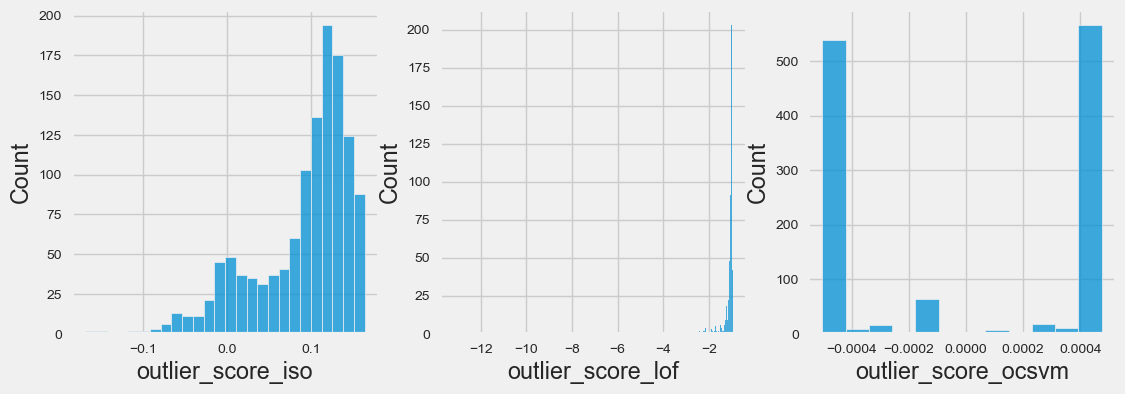

<Figure size 800x550 with 0 Axes>

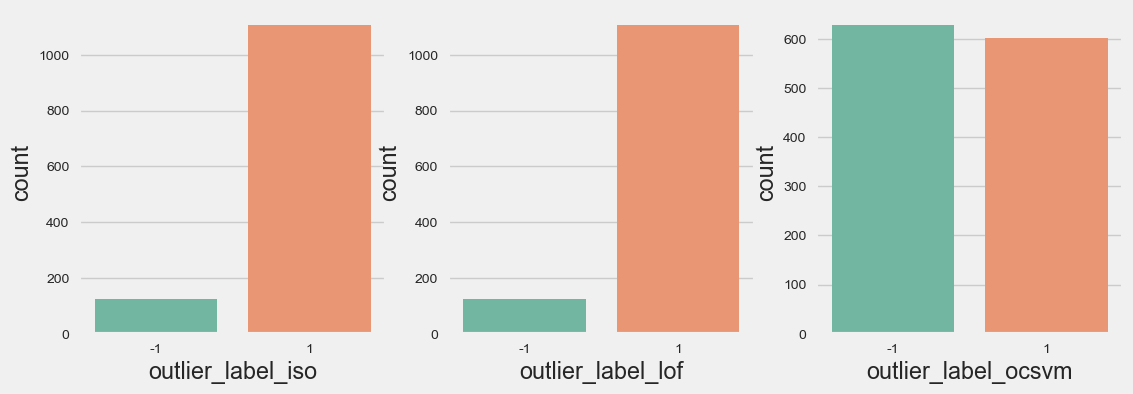

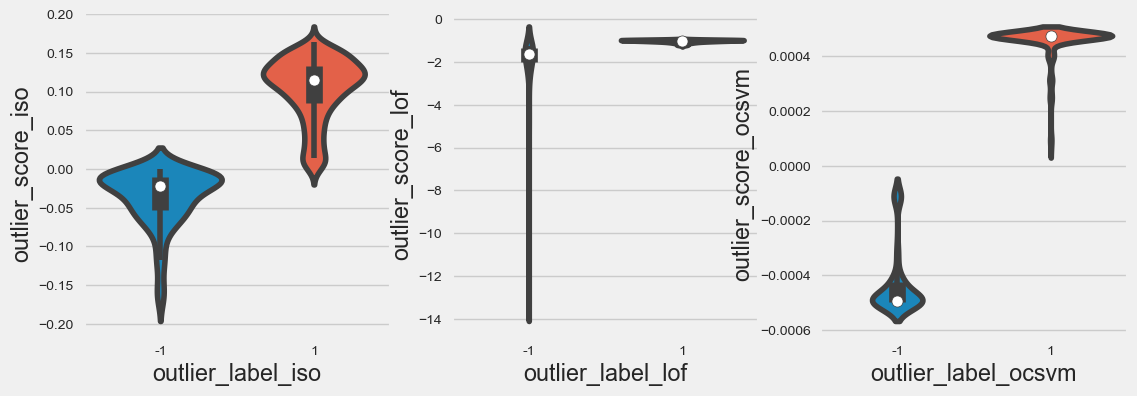

In [999]:
df_iso = df_pred.copy()
# drop columns date, activity_id, start_date, name
df_iso = df_iso.drop(columns=['date', 'activity_id', 'start_date', 'name'])
# get label encode type column
df_iso['type'] = df_iso['type'].astype('category')
df_iso['type'] = df_iso['type'].cat.codes
print(df_iso.shape)
# impute missing values with function impute and method mean
df_iso = impute(df_iso, method='mean')
print(df_iso.shape)
# fit isolation forest
isolation_forest.fit(df_iso)
# import local outlier factor library
from sklearn.neighbors import LocalOutlierFactor
# import all outlier detection libraries from sklearn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM


df_iso_train = df_iso.copy()
# fit local outlier factor
local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
local_outlier_factor.fit(df_iso_train)

# fit one class svm
one_class_svm = OneClassSVM(nu=0.1, kernel='rbf', gamma=0.1)
one_class_svm.fit(df_iso_train)


# get outlier scores
df_iso['outlier_score_iso'] = isolation_forest.decision_function(df_iso_train)
# get outlier labels
df_iso['outlier_label_iso'] = isolation_forest.predict(df_iso_train)

# get outlier scores
df_iso['outlier_score_lof'] = local_outlier_factor.negative_outlier_factor_
# get outlier labels
df_iso['outlier_label_lof'] = local_outlier_factor.fit_predict(df_iso_train)

# get outlier scores
df_iso['outlier_score_ocsvm'] = one_class_svm.decision_function(df_iso_train)
# get outlier labels
df_iso['outlier_label_ocsvm'] = one_class_svm.predict(df_iso_train)

# plot outlier scores
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df_iso['outlier_score_iso'], ax=ax[0])
sns.histplot(df_iso['outlier_score_lof'], ax=ax[1])
sns.histplot(df_iso['outlier_score_ocsvm'], ax=ax[2])
plt.show()
plt.tight_layout()
# make count plot of outlier labels
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(data=df_iso, x='outlier_label_iso', palette='Set2', ax=ax[0])
sns.countplot(data=df_iso, x='outlier_label_lof', palette='Set2', ax=ax[1])
sns.countplot(data=df_iso, x='outlier_label_ocsvm', palette='Set2', ax=ax[2])
plt.show()
# show viloinplot of outlier scores grouped by outlier label
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.violinplot(y='outlier_score_iso', x='outlier_label_iso', data=df_iso, ax=ax[0])
sns.violinplot(y='outlier_score_lof', x='outlier_label_lof', data=df_iso, ax=ax[1])
sns.violinplot(y='outlier_score_ocsvm', x='outlier_label_ocsvm', data=df_iso, ax=ax[2])
plt.show()

# show outlier activities
#df_iso[df_iso['outlier_label'] == -1]




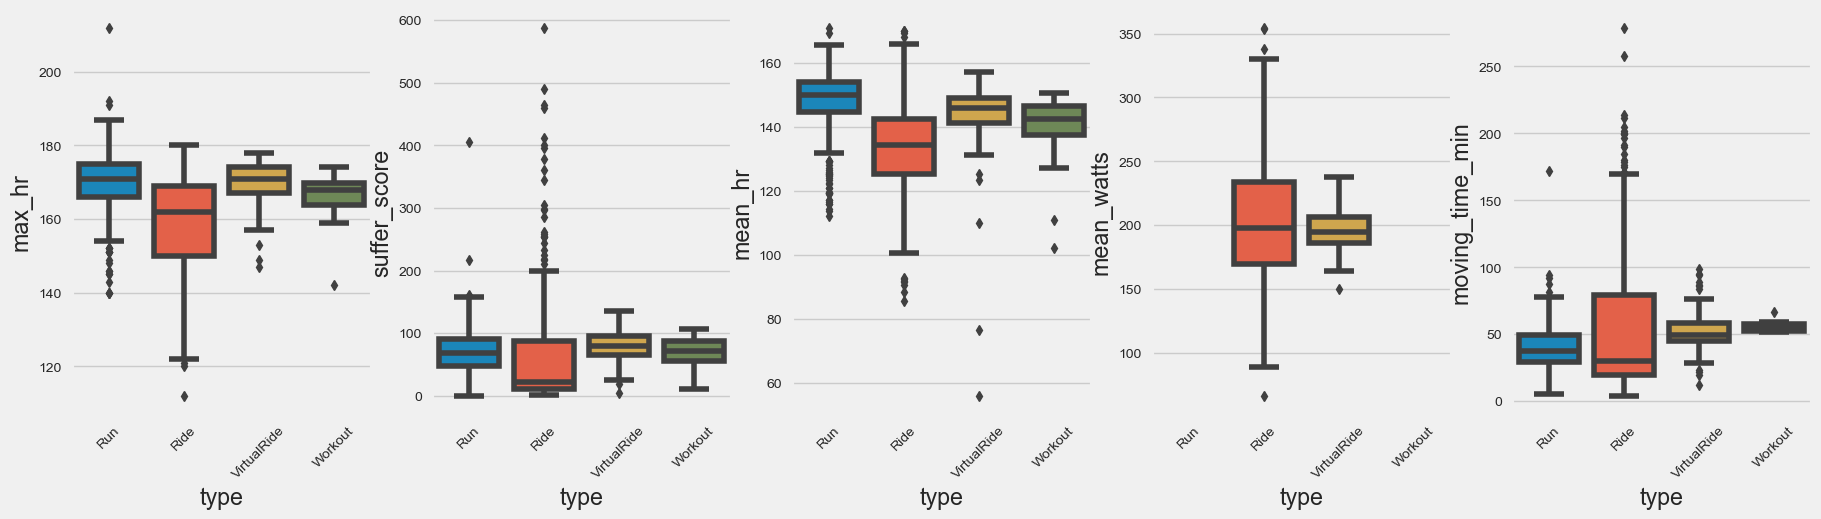

<Figure size 800x550 with 0 Axes>

In [1000]:
# make individual boxplots for all columns for df_pred dataframe using seaborn boxplot in one row and rotate the
cond = df_pred['type'].isin(['Ride', 'Run', 'VirtualRide', 'Workout'])
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
sns.boxplot(data=df_pred[cond], x='type', y='max_hr', ax=ax[0])
sns.boxplot(data=df_pred[cond], x='type', y='suffer_score', ax=ax[1])
sns.boxplot(data=df_pred[cond], x='type', y='mean_hr', ax=ax[2])
sns.boxplot(data=df_pred[cond], x='type', y='mean_watts', ax=ax[3])
sns.boxplot(data=df_pred[cond], x='type', y='moving_time_min', ax=ax[4])
# rotate the x-labels 
for i in range(5):
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
plt.show()
plt.tight_layout()






In [1001]:
df_pred.tail()

activity_id  suffer_score  max_hr  mean_hr  mean_watts         type  \
4   8177784293          54.0   166.0    147.3       209.4         Ride   
3   8214224868          46.0   176.0    146.0       185.6  VirtualRide   
2   8222534583          65.0   166.0    140.7         NaN      Workout   
1   8232572924          73.0   170.0    144.3       187.0  VirtualRide   
0   8239806204         108.0   175.0    155.8       198.1  VirtualRide   

                  start_date                                     name  \
4  2022-11-27 20:08:18+00:00                              Night Ride    
3  2022-12-06 11:25:01+00:00                     Wahoo SYSTM: Joyride   
2  2022-12-08 05:20:46+00:00                              MMA Fitness   
1  2022-12-10 16:58:08+00:00                    Wahoo SYSTM: Revolver   
0  2022-12-12 13:54:36+00:00  Wahoo SYSTM: Revolver is Easy (Mash-Up)   

   elev_gain  kilojoules  average_speed  distance  year        date  hour  \
4      187.0       413.8           4.97    9831.2  2022  2022-11-27    20   
3        0.0       331.3           8.24   14713.7  2022  2022-12-06    11   
2        0.0         NaN           0.00       0.0  2022  2022-12-08     5   
1        0.0       552.5           8.24   24354.4  2022  2022-12-10    16   
0        0.0       535.7           8.47   22895.6  2022  2022-12-12    13   

   moving_time_min  elapsed_time_min  suffer_score_missing  max_hr_missing  \
4        32.933333         36.350000                     0               0   
3        29.750000         29.750000                     0               0   
2        52.316667         52.316667                     0               0   
1        49.250000         49.250000                     0               0   
0        45.066667         45.066667                     0               0   

   mean_hr_missing  mean_watts_missing  kilojoules_missing  
4                0                   0                   0  
3                0                   0                   0  
2                0                   1                   1  
1                0                   0                   0  
0                0                   0                   0

In [1002]:
df_iso.tail()

suffer_score  max_hr  mean_hr  mean_watts  type  elev_gain  kilojoules  \
1224          54.0   166.0    147.3  209.400000   3.0      187.0   413.80000   
1225          46.0   176.0    146.0  185.600000   5.0        0.0   331.30000   
1226          65.0   166.0    140.7  201.315159   6.0        0.0   635.40586   
1227          73.0   170.0    144.3  187.000000   5.0        0.0   552.50000   
1228         108.0   175.0    155.8  198.100000   5.0        0.0   535.70000   

      average_speed  distance    year  hour  moving_time_min  \
1224           4.97    9831.2  2022.0  20.0        32.933333   
1225           8.24   14713.7  2022.0  11.0        29.750000   
1226           0.00       0.0  2022.0   5.0        52.316667   
1227           8.24   24354.4  2022.0  16.0        49.250000   
1228           8.47   22895.6  2022.0  13.0        45.066667   

      elapsed_time_min  suffer_score_missing  max_hr_missing  mean_hr_missing  \
1224         36.350000                   0.0             0.0              0.0   
1225         29.750000                   0.0             0.0              0.0   
1226         52.316667                   0.0             0.0              0.0   
1227         49.250000                   0.0             0.0              0.0   
1228         45.066667                   0.0             0.0              0.0   

      mean_watts_missing  kilojoules_missing  outlier_score_iso  \
1224                 0.0                 0.0           0.090221   
1225                 0.0                 0.0           0.087724   
1226                 1.0                 1.0           0.010353   
1227                 0.0                 0.0           0.118901   
1228                 0.0                 0.0           0.106824   

      outlier_label_iso  outlier_score_lof  outlier_label_lof  \
1224                  1          -1.084800                  1   
1225                  1          -1.048863                  1   
1226                  1          -0.989218                  1   
1227                  1          -0.977185                  1   
1228                  1          -0.976180                  1   

      outlier_score_ocsvm  outlier_label_ocsvm  
1224             0.000314                    1  
1225            -0.000496                   -1  
1226            -0.000276                   -1  
1227            -0.000469                   -1  
1228            -0.000422                   -1

In [1003]:
print(df_pred.shape, df_iso.shape, pd.concat([df_pred.reset_index(drop=True), df_iso[["outlier_score_iso", "outlier_label_iso", "outlier_score_lof", "outlier_label_lof"]].reset_index(drop=True)], axis=1).shape)

(1229, 22) (1229, 24) (1229, 26)


In [1004]:
df_pred2 = pd.concat([df_pred.reset_index(drop=True), df_iso[["outlier_score_iso", "outlier_label_iso", "outlier_score_lof", "outlier_label_lof"]].reset_index(drop=True)], axis=1)
print(df_pred2.shape)
df_pred2["outlier_label_iso"] = df_pred2["outlier_label_iso"].map({-1: 1, 1: 0})
df_pred2["outlier_label_lof"] = df_pred2["outlier_label_lof"].map({-1: 1, 1: 0})
cond = df_pred2["type"] == "VirtualRide"
#df_pred2[cond].groupby("name").agg({"outlier_score_iso": "mean", "outlier_label_iso": "mean", "name":"count"})#.sort_values("n", ascending=False)#.head(10)
# do named aggregations on df_pred2 dataframe grouped by name and type
df_pred2[cond].groupby(["name", "type"]).agg(
    outlier_score_iso_mean=("outlier_score_iso", "mean"),
    outlier_label_iso_mean=("outlier_label_iso", "mean"),
    outlier_score_lof_mean=("outlier_score_lof", "mean"),
    outlier_label_lof_mean=("outlier_label_lof", "mean"),
    occurence=("name", "count")
).sort_values("outlier_score_iso_mean", ascending=False)#.head(10)

(1229, 26)


outlier_score_iso_mean  \
name                                              type                                  
The Sufferfest: 14 Vise Grips                     VirtualRide                0.129886   
Wahoo SYSTM: Attacker                             VirtualRide                0.124845   
Wahoo SYSTM: Fairless                             VirtualRide                0.124631   
Wahoo SYSTM: Tasmania: Cygnet Coast Road          VirtualRide                0.122072   
Wahoo SYSTM: Half is Easy                         VirtualRide                0.119977   
...                                                                               ...   
The Sufferfest: The Best Way is Blended (Mash-Up) VirtualRide                0.001653   
Wahoo SYSTM: Tugende                              VirtualRide               -0.004209   
NYC                                               VirtualRide               -0.006929   
AR - Canyonville                                  VirtualRide               -0.021222   
AR - Cortina-Valparola                            VirtualRide               -0.060170   

                                                               outlier_label_iso_mean  \
name                                              type                                  
The Sufferfest: 14 Vise Grips                     VirtualRide                     0.0   
Wahoo SYSTM: Attacker                             VirtualRide                     0.0   
Wahoo SYSTM: Fairless                             VirtualRide                     0.0   
Wahoo SYSTM: Tasmania: Cygnet Coast Road          VirtualRide                     0.0   
Wahoo SYSTM: Half is Easy                         VirtualRide                     0.0   
...                                                                               ...   
The Sufferfest: The Best Way is Blended (Mash-Up) VirtualRide                     0.0   
Wahoo SYSTM: Tugende                              VirtualRide                     1.0   
NYC                                               VirtualRide                     1.0   
AR - Canyonville                                  VirtualRide                     1.0   
AR - Cortina-Valparola                            VirtualRide                     1.0   

                                                               outlier_score_lof_mean  \
name                                              type                                  
The Sufferfest: 14 Vise Grips                     VirtualRide               -0.986109   
Wahoo SYSTM: Attacker                             VirtualRide               -0.986069   
Wahoo SYSTM: Fairless                             VirtualRide               -0.972589   
Wahoo SYSTM: Tasmania: Cygnet Coast Road          VirtualRide               -0.977361   
Wahoo SYSTM: Half is Easy                         VirtualRide               -0.981646   
...                                                                               ...   
The Sufferfest: The Best Way is Blended (Mash-Up) VirtualRide               -1.093548   
Wahoo SYSTM: Tugende                              VirtualRide               -1.024670   
NYC                                               VirtualRide               -0.993005   
AR - Canyonville                                  VirtualRide               -2.577746   
AR - Cortina-Valparola                            VirtualRide               -1.204279   

                                                               outlier_label_lof_mean  \
name                                              type                                  
The Sufferfest: 14 Vise Grips                     VirtualRide                     0.0   
Wahoo SYSTM: Attacker                             VirtualRide                     0.0   
Wahoo SYSTM: Fairless                             VirtualRide                     0.0   
Wahoo SYSTM: Tasmania: Cygnet Coast Road          VirtualRide                     0.0   
Wahoo SYSTM: Half is Easy                         Virtu

In [1005]:
cond1 = df_pred2.outlier_label_iso == 1
iso_ids = set(df_pred2[cond1].activity_id)
cond2 = df_pred2.outlier_label_lof == 1
lof_ids = set(df_pred2[cond2].activity_id)
print(len(iso_ids), len(lof_ids))
print(len(iso_ids.intersection(lof_ids)))
# how many activities are in both sets
df_pred2[cond1 & cond2]

123 123
22


activity_id  suffer_score  max_hr  mean_hr  mean_watts         type  \
3       936340124           NaN     NaN      NaN       123.7         Ride   
13      936340165           NaN     NaN      NaN       251.8         Ride   
17      936340191           NaN     NaN      NaN         NaN          Run   
31      936342111           NaN     NaN      NaN        89.0         Ride   
42      936342158           NaN     NaN      NaN       242.1         Ride   
44      936342171           NaN     NaN      NaN       280.9         Ride   
64      936343883           NaN     NaN      NaN        66.4         Ride   
65      731910477           NaN     NaN      NaN       167.9         Ride   
146    1027020691           4.0   138.0     86.5         NaN         Hike   
183    1105954554           1.0   112.0     85.5       172.3         Ride   
192    1132176418         464.0   175.0    156.6       261.4         Ride   
307    1561633644         146.0   150.0    135.7       146.6         Ride   
411    1764308076         460.0   173.0    157.7       288.5         Ride   
420    1793578158           NaN     NaN      NaN       261.7         Ride   
523    2333138534           NaN     NaN      NaN       203.3  VirtualRide   
589    2499866600           NaN     NaN      NaN       294.1         Ride   
595    2505498761           NaN     NaN      NaN       224.8         Ride   
597    2506433789           NaN     NaN      NaN       301.2         Ride   
638    2606277227         490.0   174.0    157.1       306.2         Ride   
1171   7557401384           NaN     NaN      NaN       103.8         Ride   
1172   7559040923         588.0   174.0    155.1       193.2         Ride   
1219   8133847455          11.0   142.0    102.2         NaN      Workout   

                     start_date              name  elev_gain  kilojoules  \
3     2014-04-06 09:58:55+00:00        Lunch Ride       90.9       273.6   
13    2014-07-22 15:54:50+00:00    Afternoon Ride       35.0       235.1   
17    2014-08-15 10:10:53+00:00         Lunch Run      371.2         NaN   
31    2016-05-29 11:34:45+00:00    Afternoon Ride       24.4       144.1   
42    2016-07-21 06:40:07+00:00      Morning Ride       18.1       239.9   
44    2016-07-22 07:01:50+00:00      Morning Ride       21.3       258.4   
64    2016-10-01 09:30:27+00:00        Lunch Ride      103.9       172.2   
65    2016-10-02 10:50:27+00:00        Lunch Ride      585.9      1059.3   
146   2017-06-08 17:06:01+00:00      Evening Hike       30.0         NaN   
183   2017-07-28 18:58:30+00:00      Evening Ride       34.0       117.0   
192   2017-08-12 07:04:59+00:00        Cykelvasan      928.4      3352.8   
307   2018-05-10 05:36:38+00:00      Morning Ride      570.0      1586.7   
411   2018-08-11 07:00:55+00:00        Cykelvasan      758.0      3537.0   
420   2018-08-24 05:45:46+00:00      Morning Ride       65.3       289.4   
523   2019-05-01 11:37:23+00:00  AR - Canyonville       18.0       148.0   
589   2019-07-03 05:41:23+00:00      Morning Ride       42.0       272.3   
595   2019-07-05 05:58:45+00:00      Morning Ride       46.0       247.1   
597   2019-07-05 15:18:52+00:00    Afternoon Ride       70.0       312.6   
638   2019-08-10 06:45:40+00:00        Cykelvasan      922.0      3671.2   
1171  2022-07-31 08:38:07+00:00     Morning Ride         8.8        63.5   
1172  2022-07-31 08:59:51+00:00    Finnmarksturen     1304.0      2986.5   
1219  2022-11-18 05:32:00+00:00       MMA Fitness        0.0         NaN   

      average_speed  distance  year        date  hour  moving_time_min  \
3              3.76    8314.9  2014  2014-04-06     9        36.850000   
13             7.20    6726.9  2014  2014-07-22    15        15.566667   
17             1.60    5205.5  2014  2014-08-15    10        54.300000   
31             3.56    5764.5  2016  2016-05-29    11        27.000000   
42             7.09    7023.6  2016  2016-07-21     6        16.516667   
44             7.61    7000.3  2016  2016

In [1006]:
df_pred2.groupby("type").agg(
    outlier_score_mean=("outlier_score", "mean"),
    outlier_label_mean=("outlier_label", "mean"),
    occurence=("name", "count")
)

KeyError: "Column(s) ['outlier_label', 'outlier_score'] do not exist"

In [ ]:
cond = df_pred2["name"] == "4DP Test: Full Frontal"
cond = df_pred2["type"] == "VirtualRide"
df_pred2[cond].sort_values("outlier_score", ascending=False)#.head(10)


activity_id  suffer_score  max_hr  mean_hr  mean_watts         type  \
671   2.410003e+09          66.0   167.0    137.5       175.7  VirtualRide   
491   2.958066e+09          52.0   169.0    137.4       191.6  VirtualRide   
454   3.045838e+09          79.0   173.0    142.9       221.1  VirtualRide   
696   2.362930e+09          93.0   160.0    142.2       220.9  VirtualRide   
303   4.109562e+09           NaN     NaN      NaN       196.3  VirtualRide   
...            ...           ...     ...      ...         ...          ...   
701   2.354778e+09           5.0   160.0     55.9       150.3  VirtualRide   
1162  8.189664e+08          54.0   178.0    140.2         NaN  VirtualRide   
1157  8.418959e+08         135.0   176.0    145.5         NaN  VirtualRide   
705   2.344993e+09           NaN     NaN      NaN       165.8  VirtualRide   
590   2.630835e+09          80.0   171.0    142.2       191.9  VirtualRide   

                     start_date                                 name  \
671   2019-05-30 18:23:40+00:00               4DP Test: Full Frontal   
491   2019-12-26 16:16:08+00:00           The Sufferfest: The Omnium   
454   2020-01-26 15:43:49+00:00         The Sufferfest: Nine Hammers   
696   2019-05-12 19:10:24+00:00  Boccadasse - Chiavari via Boschetto   
303   2020-09-25 09:48:13+00:00      The Sufferfest: There Is No Try   
...                         ...                                  ...   
701   2019-05-09 18:52:40+00:00               4DP Test: Full Frontal   
1162  2017-01-02 16:30:13+00:00                       Afternoon Ride   
1157  2017-01-23 16:31:12+00:00                       Afternoon Ride   
705   2019-05-05 18:34:12+00:00            20x30sec 4x1min INTERVALS   
590   2019-08-18 17:58:49+00:00               4DP Test: Full Frontal   

      elev_gain  kilojoules  average_speed  distance    year        date  \
671         0.0       635.4           7.90   28582.0  2019.0  2019-05-30   
491         0.0       547.3           8.28   23635.0  2019.0  2019-12-26   
454         0.0       774.2           8.80   30823.0  2020.0  2020-01-26   
696       504.0       919.2           7.39   30731.7  2019.0  2019-05-12   
303         0.0       585.5           8.46   25218.0  2020.0  2020-09-25   
...         ...         ...            ...       ...     ...         ...   
701         0.0       543.8           7.44   26905.0  2019.0  2019-05-09   
1162        0.0         NaN           0.00       0.0  2017.0  2017-01-02   
1157        0.0         NaN           0.00       0.0  2017.0  2017-01-23   
705         0.0       601.3           7.24   26244.4  2019.0  2019-05-05   
590         0.0       691.7           8.25   29731.0  2019.0  2019-08-18   

      hour  moving_time_min  elapsed_time_min  suffer_score_missing  \
671   18.0        60.283333         60.283333                   0.0   
491   16.0        47.600000         47.600000                   0.0   
454   15.0        58.366667         58.366667                   0.0   
696   19.0        69.350000         69.350000                   0.0   
303    9.0        49.700000         49.700000                   1.0   
...    ...              ...               ...                   ...   
701   18.0        60.283333         60.283333                   0.0   
1162  16.0        94.200000         94.200000                   0.0   
1157  16.0        94.966667         94.966667                   0.0   
705   18.0        60.450000         60.450000                   1.0   
590   17.0        60.066667         60.066667                   0.0   

      max_hr_missing  mean_hr_missing  mean_watts_missing  kilojoules_missing  \
671              0.0              0.0                 0.0                 0.0   
491              0.0              0.0                 0.0                 0.0   
454              0.0              0.0                 0.0                 0.0   
696              0.0              0.0                 0.0                 0.0   
303              1.0              

# Predict Watts

## Overview of missing values per activiy type

In [ ]:
# calculate how many missing values for columns in cols_to_impute grouped by type
df_temp = df_pred.groupby("type")[cols_to_impute].apply(lambda x: x.isnull().sum())
# count how type there using value_counts and turn it into a dataframe
df_temp2 = df_pred.groupby("type", as_index=False)["activity_id"].count()#.reset_index()
# rename the columns
df_temp2.columns = ["type", "count"]
# merge the dataframes
df_temp = pd.merge(df_temp, df_temp2, on="type")
df_temp




type  suffer_score  max_hr  mean_hr  mean_watts  kilojoules  count
0    EBikeRide             0       0        0           0           0      6
1         Hike             0       0        0          20          20     20
2     IceSkate             0       0        0           8           8      8
3         Ride            68      68       68           0           0    646
4          Run            31      31       31         392         392    392
5  VirtualRide            40      40       40          10          10    143
6      Workout             0       0        0          14          14     14

In [ ]:
df_pred.groupby("type", as_index=True)[features_virtualride_for_hr].apply(lambda x: x.isnull().sum())

kilojoules  mean_watts  average_speed  distance  elapsed_time_min
type                                                                          
EBikeRide             0           0              0         0                 0
Hike                 20          20              0         0                 0
IceSkate              8           8              0         0                 0
Ride                  0           0              0         0                 0
Run                 392         392              0         0                 0
VirtualRide          10          10              0         0                 0
Workout              14          14              0         0                 0

In [ ]:
# type = Ride, VirtialRide and Run needs imputing

# This is for spinning classes momve to virtalride?????!???????
# type = Ride or VirtualRide and meant_watts is null -> Spin class
# impute mean_watts, kilojoules

# impute suffer_score, max_hr, mean_hr for type = Ride, dont use the imputed mean_watts, kilojoules
# impute suffer_score, max_hr, mean_hr for type = VirtualRide, dont use the imputed mean_watts, kilojoules

# impute suffer_score, max_hr, mean_hr for type = Run only use Run values



# for type VirtualRide where mean_watts and kilojoules is null impute









In [ ]:
# the df_test dataframe has column "scores" with a dictionary in each row 
# use json_normalize to flatten the dictionary and add the new columns to the dataframe 
df_test2 = pd.json_normalize(df_test.scores)
# concat the new dataframe with the old dataframe
df_test3 = pd.concat([df_test, df_test2], axis=1)
# drop the scores column
df_test3.drop("scores", axis=1, inplace=True)
df_test3.head(2)

cols = df_test2.columns.tolist()
# explode the list columns
df_test3 = df_test3.explode(cols)

df_test4 = df_test3.groupby(["activity_type", "target", "model_name"], as_index=False).mean()
df_test4.sort_values(["activity_type", "target", "test_r2"], ascending=False, inplace=True)
# get model_name with the max test_r2 for each activity_type and target 
df_test4.groupby(["activity_type", "target"], as_index=False).first()


activity_type        target                 model_name  fit_time  \
0           Ride        max_hr                        SVR  0.016755   
1           Ride       mean_hr                        SVR  0.019746   
2           Ride  suffer_score                      Lasso  0.014960   
3            Run        max_hr      RandomForestRegressor  0.357438   
4            Run       mean_hr      RandomForestRegressor  0.351062   
5            Run  suffer_score  GradientBoostingRegressor  0.105711   
6    VirtualRide    kilojoules      RandomForestRegressor  0.279245   
7    VirtualRide        max_hr                        SVR  0.005785   
8    VirtualRide       mean_hr                        SVR  0.005186   
9    VirtualRide    mean_watts                        SVR  0.007180   
10   VirtualRide  suffer_score        KNeighborsRegressor  0.004175   

    score_time   test_r2  train_r2  test_neg_mean_squared_error  \
0     0.011370  0.113711  0.238983                  -138.325063   
1     0.012367  0.140251  0.211462                  -130.192956   
2     0.005585  0.796022  0.826877                 -1252.368986   
3     0.025532 -0.039821  0.889850                   -61.034528   
4     0.024948  0.226538  0.918009                   -70.364289   
5     0.004588  0.538892  0.918072                  -778.864433   
6     0.029123  0.762089  0.982075                 -2917.300992   
7     0.004388 -0.189707 -0.059035                   -40.622465   
8     0.004587 -0.393891 -0.045710                  -171.351517   
9     0.006582 -0.670959  0.035619                  -284.862294   
10    0.004794  0.165390  0.516765                  -456.381565   

    train_neg_mean_squared_error  
0                    -129.894696  
1                    -125.953161  
2                   -1070.647731  
3                      -7.797473  
4                      -8.826225  
5                    -132.919506  
6                    -322.766923  
7                     -37.534876  
8                    -161.973158  
9                    -238.104315  
10                   -291.576533

In [ ]:
df_test4.sort_values(["activity_type", "target", "test_neg_mean_squared_error"], ascending=False, inplace=True)
# get model_name with the max test_r2 for each activity_type and target 
df_test4.groupby(["activity_type", "target"], as_index=False).first()

activity_type        target             model_name  fit_time  score_time  \
0           Ride        max_hr                    SVR  0.016755    0.011370   
1           Ride       mean_hr                    SVR  0.019746    0.012367   
2           Ride  suffer_score                  Lasso  0.014960    0.005585   
3            Run        max_hr  RandomForestRegressor  0.357438    0.025532   
4            Run       mean_hr  RandomForestRegressor  0.351062    0.024948   
5            Run  suffer_score  RandomForestRegressor  0.458574    0.033310   
6    VirtualRide    kilojoules  RandomForestRegressor  0.279245    0.029123   
7    VirtualRide        max_hr                    SVR  0.005785    0.004388   
8    VirtualRide       mean_hr                    SVR  0.005186    0.004587   
9    VirtualRide    mean_watts  RandomForestRegressor  0.363628    0.026130   
10   VirtualRide  suffer_score    KNeighborsRegressor  0.004175    0.004794   

     test_r2  train_r2  test_neg_mean_squared_error  \
0   0.113711  0.238983                  -138.325063   
1   0.140251  0.211462                  -130.192956   
2   0.796022  0.826877                 -1252.368986   
3  -0.039821  0.889850                   -61.034528   
4   0.226538  0.918009                   -70.364289   
5   0.537606  0.931691                  -761.956969   
6   0.762089  0.982075                 -2917.300992   
7  -0.189707 -0.059035                   -40.622465   
8  -0.393891 -0.045710                  -171.351517   
9  -0.811490  0.884444                  -240.602282   
10  0.165390  0.516765                  -456.381565   

    train_neg_mean_squared_error  
0                    -129.894696  
1                    -125.953161  
2                   -1070.647731  
3                      -7.797473  
4                      -8.826225  
5                    -111.757036  
6                    -322.766923  
7                     -37.534876  
8                    -161.973158  
9                     -28.420475  
10                   -291.576533

In [ ]:
cond = df_test3["activity_type"] == "VirtualRide"
cond2 = df_test3["target"] == "suffer_score"
df_test3[cond & cond2].sort_values("test_r2", ascending=False)

activity_type                 model_name        target  fit_time  \
65   VirtualRide        KNeighborsRegressor  suffer_score  0.003955   
55   VirtualRide                 ElasticNet  suffer_score  0.004985   
75   VirtualRide      RandomForestRegressor  suffer_score  0.222404   
45   VirtualRide                      Lasso  suffer_score  0.004987   
80   VirtualRide  GradientBoostingRegressor  suffer_score  0.062831   
85   VirtualRide              LGBMRegressor  suffer_score  0.038897   
50   VirtualRide                      Ridge  suffer_score  0.005985   
65   VirtualRide        KNeighborsRegressor  suffer_score  0.004987   
80   VirtualRide  GradientBoostingRegressor  suffer_score  0.077797   
75   VirtualRide      RandomForestRegressor  suffer_score  0.257284   
40   VirtualRide           LinearRegression  suffer_score  0.006982   
70   VirtualRide      DecisionTreeRegressor  suffer_score  0.003989   
35   VirtualRide          linear+polynomial  suffer_score  0.007977   
85   VirtualRide              LGBMRegressor  suffer_score  0.038896   
40   VirtualRide           LinearRegression  suffer_score  0.009973   
50   VirtualRide                      Ridge  suffer_score  0.004985   
45   VirtualRide                      Lasso  suffer_score  0.003989   
55   VirtualRide                 ElasticNet  suffer_score  0.006981   
65   VirtualRide        KNeighborsRegressor  suffer_score  0.004987   
75   VirtualRide      RandomForestRegressor  suffer_score  0.232378   
40   VirtualRide           LinearRegression  suffer_score  0.007978   
70   VirtualRide      DecisionTreeRegressor  suffer_score  0.006982   
70   VirtualRide      DecisionTreeRegressor  suffer_score  0.002993   
60   VirtualRide                        SVR  suffer_score  0.005985   
50   VirtualRide                      Ridge  suffer_score   0.00299   
45   VirtualRide                      Lasso  suffer_score  0.003988   
65   VirtualRide        KNeighborsRegressor  suffer_score  0.002954   
55   VirtualRide                 ElasticNet  suffer_score  0.006983   
60   VirtualRide                        SVR  suffer_score   0.00698   
80   VirtualRide  GradientBoostingRegressor  suffer_score  0.070809   
35   VirtualRide          linear+polynomial  suffer_score  0.013961   
35   VirtualRide          linear+polynomial  suffer_score  0.007978   
60   VirtualRide                        SVR  suffer_score   0.00399   
60   VirtualRide                        SVR  suffer_score  0.004988   
75   VirtualRide      RandomForestRegressor  suffer_score  0.244349   
60   VirtualRide                        SVR  suffer_score  0.004987   
80   VirtualRide  GradientBoostingRegressor  suffer_score  0.095746   
85   VirtualRide              LGBMRegressor  suffer_score  0.039893   
85   VirtualRide              LGBMRegressor  suffer_score  0.038896   
65   VirtualRide        KNeighborsRegressor  suffer_score  0.003989   
80   VirtualRide  GradientBoostingRegressor  suffer_score  0.068816   
70   VirtualRide      DecisionTreeRegressor  suffer_score  0.004987   
40   VirtualRide           LinearRegression  suffer_score  0.008974   
50   VirtualRide                      Ridge  suffer_score  0.003989   
45   VirtualRide                      Lasso  suffer_score  0.003989   
55   VirtualRide                 ElasticNet  suffer_score  0.005983   
75   VirtualRide      RandomForestRegressor  suffer_score  0.280254   
85   VirtualRide              LGBMRegressor  suffer_score  0.036902   
55   VirtualRide                 ElasticNet  suffer_score  0.004027   
45   VirtualRide                      Lasso  suffer_score  0.003989   
50   VirtualRide                      Ridge  suffer_score  0.003993   
70   VirtualRide      DecisionTreeRegressor  suffer_score  0.004987   
40   VirtualRide           LinearRegression  suffer_score  0.004987   
35   VirtualRide          linear+polynomial  suffer_score  0.009974   
35   VirtualRide          linear+polynomial  suffer_score  0.009975   

   score_time      test_r2

In [ ]:
# the df_test2 dataframe has column "scores" with a dictionary in each row 
# use json_normalize to flatten the dictionary
pd.json_normalize(df_test2["scores"])

score_name               cv  \
0    train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
1    train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
2    train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
3    train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
4    train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
..                            ...              ...   
721  train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
722  train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
723  train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
724  train_neg_mean_squared_error  (0, 1, 2, 3, 4)   
725  train_neg_mean_squared_error  (0, 1, 2, 3, 4)   

                                                values  
0    [-676.1644396581066, -1053.893827875197, -704....  
1    [-676.1644396581066, -1053.893827875197, -704....  
2    [-676.1644396581066, -1053.893827875197, -704....  
3    [-676.1644396581066, -1053.893827875197, -704....  
4    [-676.1644396581066, -1053.893827875197, -704....  
..                                                 ...  
721  [-21.338500924012315, -22.58183106147289, -18....  
722  [-21.338500924012315, -22.58183106147289, -18....  
723  [-21.338500924012315, -22.58183106147289, -18....  
724  [-21.338500924012315, -22.58183106147289, -18....  
725  [-21.338500924012315, -22.58183106147289, -18....  

[726 rows x 3 columns]

### Leave One Out

In [1024]:
target = "suffer_score"
features = features_virtualride_for_hr  
activity_type = "VirtualRide"

#df_temp = df_pred[(df_pred.type == activity_type)][[target] + features].copy()
df_temp = df_pred[(df_pred.type == activity_type)].copy()

cond = df_temp[target].notna()
df_train = df_temp[cond].copy()
if "suffer_score" in features:
    cond = df_train["suffer_score"].notna()
    df_train = df_train[cond].copy()
# if any of the features are null drop the row
cond = df_train[features].isnull().any(axis=1)
df_train = df_train[~cond].copy()
print(df_train.shape)
df_train.reset_index(drop=True, inplace=True)

# import leaveoneout
from sklearn.model_selection import LeaveOneOut
# create leaveoneout object
loo = LeaveOneOut()
# get the indexes of the train and test sets
loo.get_n_splits(df_train)
# get the indexes of the train and test sets
# import lightgbm
import lightgbm as lgb
# instantialte lgbmregression model
model = lgb.LGBMRegressor()
# instantiate the knn regression model
knn_model = KNeighborsRegressor(**{'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'})
# import tqdm auto
from tqdm.auto import tqdm
for fold, (train_index, test_index) in tqdm(enumerate(loo.split(df_train))):
    # get the train and test sets
    X_train, X_test = df_train.iloc[train_index][features], df_train.iloc[test_index][features]
    y_train, y_test = df_train.iloc[train_index][target], df_train.iloc[test_index][target]
    # fit the model
    model.fit(X_train, y_train)
    knn_model.fit(X_train, y_train)
    # predict the target
    y_pred = model.predict(X_test)
    y_pred_knn = knn_model.predict(X_test)
    # save the predictions
    df_train.loc[test_index, "pred"] = y_pred
    df_train.loc[test_index, "pred_knn"] = y_pred_knn
    df_train.loc[test_index, "pred_mean"] = df_train.loc[train_index, target].mean()
    # save fold number
    df_train.loc[test_index, "fold"] = fold

    


(113, 22)


0it [00:00, ?it/s]

In [1026]:
target = "suffer_score"
features = features_virtualride_for_hr  
activity_type = "VirtualRide"

#df_temp = df_pred[(df_pred.type == activity_type)][[target] + features].copy()
df_temp = df_pred[(df_pred.type == activity_type)].copy()

cond = df_temp[target].notna()
df_train = df_temp[cond].copy()
if "suffer_score" in features:
    cond = df_train["suffer_score"].notna()
    df_train = df_train[cond].copy()
# if any of the features are null drop the row
cond = df_train[features].isnull().any(axis=1)
df_train = df_train[~cond].copy()
print(df_train.shape)
df_train.reset_index(drop=True, inplace=True)

# import leaveoneout
from sklearn.model_selection import LeaveOneOut
# create leaveoneout object
loo = LeaveOneOut()
# get the indexes of the train and test sets
loo.get_n_splits(df_train)
# get the indexes of the train and test sets
# import lightgbm
import lightgbm as lgb
# instantialte lgbmregression model
model = lgb.LGBMRegressor()
# instantiate the knn regression model
knn_model = KNeighborsRegressor(**{'algorithm': 'auto', 'n_neighbors': 11, 'p': 2, 'weights': 'uniform'})
# import tqdm auto


    


0.13711736218124815
0.3313162223721403
-0.017936862244897878
22.896013973914812
20.15553868739624
24.868204896934525


### Grid Search CV

In [4]:
# import lightgbm regressor
from lightgbm import LGBMRegressor

target = "suffer_score"
features = features_virtualride_for_hr  
activity_type = "VirtualRide"

#df_temp = df_pred[(df_pred.type == activity_type)][[target] + features].copy()
df_temp = df_pred[(df_pred.type == activity_type)].copy()

cond = df_temp[target].notna()
df_train = df_temp[cond].copy()
if "suffer_score" in features:
    cond = df_train["suffer_score"].notna()
    df_train = df_train[cond].copy()
# if any of the features are null drop the row
cond = df_train[features].isnull().any(axis=1)
df_train = df_train[~cond].copy()
print(df_train.shape)
df_train.reset_index(drop=True, inplace=True)

# import hyperparameter turning library
from sklearn.model_selection import GridSearchCV
# use gridsearcv to find the best hyperparameters for the the model knnregressor

# create a dictionary of hyperparameters to search over
param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto"],#, "ball_tree", "kd_tree", "brute"],
    #"leaf_size": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "p": [1, 2]
}
# param grid for lightgbm
param_grid = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    "num_leaves": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "max_depth": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    "min_child_samples": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "reg_alpha": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "reg_lambda": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
    "random_state": [42]

}

# create the model
model = KNeighborsRegressor()
MODEL = LGBMRegressor()
# create the gridsearchcv object
grid = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", cv=5, verbose=1, n_jobs=-1)
# fit the model
grid.fit(df_train[features], df_train[target])

# get the best hyperparameters
print(grid.best_params_)

# get the best score
print(grid.best_score_)





NameError: name 'features_virtualride_for_hr' is not defined

### CV

In [1015]:
target = "suffer_score"
features = features_virtualride_for_hr  
activity_type = "VirtualRide"

#df_temp = df_pred[(df_pred.type == activity_type)][[target] + features].copy()
df_temp = df_pred[(df_pred.type == activity_type)].copy()

cond = df_temp[target].notna()
df_train = df_temp[cond].copy()
if "suffer_score" in features:
    cond = df_train["suffer_score"].notna()
    df_train = df_train[cond].copy()
# if any of the features are null drop the row
cond = df_train[features].isnull().any(axis=1)
df_train = df_train[~cond].copy()
print(df_train.shape)
df_train.reset_index(drop=True, inplace=True)

model = models[-1]
print(model.__class__.__name__)
#scores = cv_tester(model, df_train[features], df_train[target])
#scores
# import cross_val_predict
from sklearn.model_selection import cross_val_predict
# make kfolds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# use the KFold object and get the fold number and the indexes of the train and test data in each fold 

# user lgmbregressor as a model
model = LGBMRegressor(random_state=42)
model_linear = LinearRegression()
model_knn = KNeighborsRegressor()
model_knn_best = KNeighborsRegressor(**grid.best_params_)

# olle get
for fold_number, (train_index, test_index) in enumerate(kf.split(df_train)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df_train.iloc[train_index], df_train.iloc[test_index]
    y_train, y_test = df_train.iloc[train_index], df_train.iloc[test_index]
    #X_train2, X_test2 = X_train[features], X_test[features]
    #y_train, y_test = y_train[target], y_test[target]

    # train and predict with lgbmregressor and save the predictions in y_pred
    model.fit(X_train[features], y_train[target])
    model_linear.fit(X_train[features], y_train[target])
    model_knn.fit(X_train[features], y_train[target])
    model_knn_best.fit(X_train[features], y_train[target])
    y_pred = model.predict(X_test[features])
    y_pred_linear = model_linear.predict(X_test[features])
    y_pred_knn = model_knn.predict(X_test[features])
    y_pred_knn_best = model_knn_best.predict(X_test[features])
    # save y_pred in the dataf
    df_train.loc[test_index, "y_pred"] = y_pred
    df_train.loc[test_index, "y_pred_linear"] = y_pred_linear
    df_train.loc[test_index, "y_pred_knn"] = y_pred_knn
    df_train.loc[test_index, "y_pred_knn_best"] = y_pred_knn_best
    # save the fold number in the dataf
    df_train.loc[test_index, "fold"] = fold_number
    # compute the r2_score and print it
    r2 = r2_score(y_test[target], y_pred)
    r2_linear = r2_score(y_test[target], y_pred_linear)
    r2_knn = r2_score(y_test[target], y_pred_knn)
    r2_knn_best = r2_score(y_test[target], y_pred_knn_best)

    # make an average prediction
    y_pred_avg = df_train.loc[train_index, "suffer_score"].mean()
    # make y_pred_avg the same length as y_pred
    y_pred_avg = np.repeat(y_pred_avg, len(y_pred))
    # compute the r2_score and print it
    r2_avg = r2_score(y_test[target], y_pred_avg)
    print(f"fold {fold_number} | r2: {r2:.2f}, r2_avg: {r2_avg:.2f}, r2_linear: {r2_linear:.2f}, r2_knn: {r2_knn:.2f}, r2_knn_best: {r2_knn_best:.2f}",  end=" | ")
    # print out the rmse
    rmse = np.sqrt(mean_squared_error(y_test[target], y_pred))
    rmse_avg = np.sqrt(mean_squared_error(y_test[target], y_pred_avg))
    rmse_linear = np.sqrt(mean_squared_error(y_test[target], y_pred_linear))
    rmse_knn = np.sqrt(mean_squared_error(y_test[target], y_pred_knn))
    rmse_knn_best = np.sqrt(mean_squared_error(y_test[target], y_pred_knn_best))
    print(f"rmse: {rmse:.2f}, rmse_avg: {rmse_avg:.2f}, rmse_linear: {rmse_linear:.2f}, rmse_knn: {rmse_knn:.2f}, rmse_knn_best: {rmse_knn_best:.2f}")

    # save the y_pred_avg in the dataf 
    df_train.loc[test_index, "y_pred_avg"] = y_pred_avg






(113, 22)
LGBMRegressor
fold 0 | r2: 0.00, r2_avg: -0.00, r2_linear: 0.12, r2_knn: 0.16, r2_knn_best: 0.15 | rmse: 29.83, rmse_avg: 29.88, rmse_linear: 28.00, rmse_knn: 27.40, rmse_knn_best: 27.48
fold 1 | r2: 0.09, r2_avg: -0.14, r2_linear: 0.06, r2_knn: 0.20, r2_knn_best: 0.31 | rmse: 24.30, rmse_avg: 27.19, rmse_linear: 24.63, rmse_knn: 22.75, rmse_knn_best: 21.11
fold 2 | r2: 0.11, r2_avg: -0.03, r2_linear: 0.15, r2_knn: 0.15, r2_knn_best: 0.19 | rmse: 17.63, rmse_avg: 18.95, rmse_linear: 17.22, rmse_knn: 17.28, rmse_knn_best: 16.81
fold 3 | r2: 0.32, r2_avg: -0.01, r2_linear: 0.30, r2_knn: 0.64, r2_knn_best: 0.56 | rmse: 19.95, rmse_avg: 24.40, rmse_linear: 20.32, rmse_knn: 14.63, rmse_knn_best: 16.14
fold 4 | r2: -0.41, r2_avg: -0.26, r2_linear: -0.34, r2_knn: 0.12, r2_knn_best: 0.04 | rmse: 24.15, rmse_avg: 22.87, rmse_linear: 23.56, rmse_knn: 19.11, rmse_knn_best: 19.96


In [ ]:
df_train["diff"] = df_train["y_pred"] - df_train["suffer_score"]
df_train["diff_sq"] = df_train["diff"] ** 2
df_train["diff_abs"] = df_train["diff"].abs()
df_train["diff_knn"] = df_train["y_pred_knn"] - df_train["suffer_score"]
df_train["diff_knn_abs"] = df_train["diff_knn"].abs()

df_train["diff_avg"] = df_train["y_pred_avg"] - df_train["suffer_score"]
df_train["diff_sq_avg"] = df_train["diff_avg"] ** 2


In [ ]:
df_train["avg_vs_model"] = np.abs(df_train["diff_avg"]) - np.abs(df_train["diff"])
cond = df_train["fold"] == 4
df_train[cond].sort_values("diff_abs", ascending=False).head(5)#, inplace=True)

activity_id  suffer_score  max_hr  mean_hr  mean_watts         type  \
74    6700773253         117.0   173.0    155.5       186.7  VirtualRide   
71    6660612534         136.0   166.0    155.6       166.7  VirtualRide   
112   8239806204         108.0   175.0    155.8       198.1  VirtualRide   
14    2778642073          43.0   157.0    136.1       188.4  VirtualRide   
106   8053377434          93.0   171.0    149.9       184.6  VirtualRide   

                    start_date                                      name  \
74   2022-02-18 10:04:31+00:00              Wahoo SYSTM: There Is No Try   
71   2022-02-10 11:10:03+00:00                  Wahoo SYSTM: Endurance 1   
112  2022-12-12 13:54:36+00:00   Wahoo SYSTM: Revolver is Easy (Mash-Up)   
14   2019-10-10 18:54:12+00:00                                  Revolver   
106  2022-11-01 15:23:48+00:00  Wahoo SYSTM: Tasmania: Cygnet Coast Road   

     elev_gain  kilojoules  average_speed  distance  year        date  hour  \
74         0.0       553.5           8.31   24645.6  2022  2022-02-18    10   
71         0.0       600.3           7.89   28435.8  2022  2022-02-10    11   
112        0.0       535.7           8.47   22895.6  2022  2022-12-12    13   
14         0.0       498.6           8.24   21817.0  2019  2019-10-10    18   
106        0.0       552.4           8.29   24796.4  2022  2022-11-01    15   

     moving_time_min  elapsed_time_min  suffer_score_missing  max_hr_missing  \
74         49.400000         49.400000                     0               0   
71         60.033333         60.033333                     0               0   
112        45.066667         45.066667                     0               0   
14         44.100000         44.100000                     0               0   
106        49.866667         49.866667                     0               0   

     mean_hr_missing  mean_watts_missing  kilojoules_missing     y_pred  \
74                 0                   0                   0  59.869051   
71                 0                   0                   0  79.204212   
112                0                   0                   0  67.853458   
14                 0                   0                   0  82.214247   
106                0                   0                   0  57.613117   

     y_pred_linear  fold  y_pred_avg       diff      diff_sq   diff_avg  \
74       74.981363   4.0   86.090909 -57.130949  3263.945314 -30.909091   
71       76.593549   4.0   86.090909 -56.795788  3225.761585 -49.909091   
112      71.260144   4.0   86.090909 -40.146542  1611.744817 -21.909091   
14       69.111381   4.0   86.090909  39.214247  1537.757180  43.090909   
106      74.530113   4.0   86.090909 -35.386883  1252.231498  -6.909091   

     diff_sq_avg  avg_vs_model   diff_abs  
74    955.371901    -26.221858  57.130949  
71   2490.917355     -6.886698  56.795788  
112   480.008264    -18.237451  40.146542  
14   1856.826446      3.876662  39.214247  
106    47.735537    -28.477792  35.386883

In [ ]:
# compute the rmse for each fold
df_train["rmse"] = np.sqrt(np.square(df_train["diff"]))
df_train.groupby("fold")["rmse"].mean()
# compute the mean error for each fold
df_train.groupby("fold")["diff"].mean()
# compute the mean error for each fold
df_train.groupby("fold").agg({"diff_sq":"mean", "diff_sq_avg":"mean"})


diff_sq  diff_sq_avg
fold                         
0.0   889.831623   892.559546
1.0   590.320129   647.296786
2.0   310.702088   350.226843
3.0   398.152018   588.512397
4.0   583.362581   414.719008

<AxesSubplot:xlabel='y_pred', ylabel='suffer_score'>

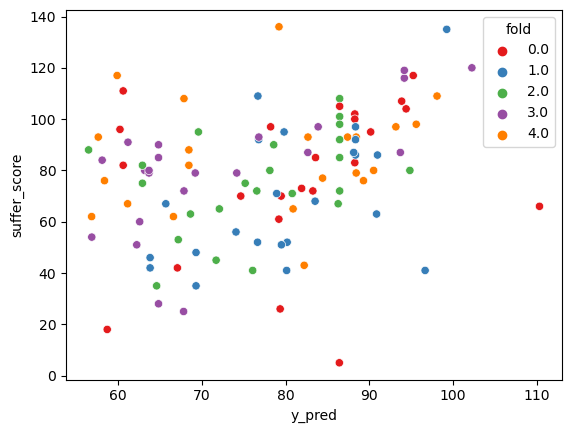

In [ ]:
# plot y_pred and suffer_score in a scatter plot and color the points by fold with a distinct hue color for each fold 
sns.scatterplot(data=df_train, x="y_pred", y="suffer_score", hue="fold", palette="Set1")

C:\Users\jerke\AppData\Local\Temp\ipykernel_22412\397964519.py:1: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



In [ ]:
df_train[["diff", "diff_avg", "diff_knn", "fold"]]

diff   diff_avg  diff_knn  fold
0    81.415660  72.695652      79.8   0.0
1    -5.600999  -6.909091      -4.2   4.0
2    15.890426  21.090909      12.4   4.0
3    19.273300   8.347826      19.2   2.0
4    44.328243  11.695652      59.2   0.0
..         ...        ...       ...   ...
108   4.972664 -15.913043       2.8   1.0
109 -16.202771 -13.181818     -12.4   3.0
110  17.807571  24.086957     -11.2   1.0
111   8.908965   4.695652       8.8   0.0
112 -40.146542 -21.909091     -29.0   4.0

[113 rows x 4 columns]

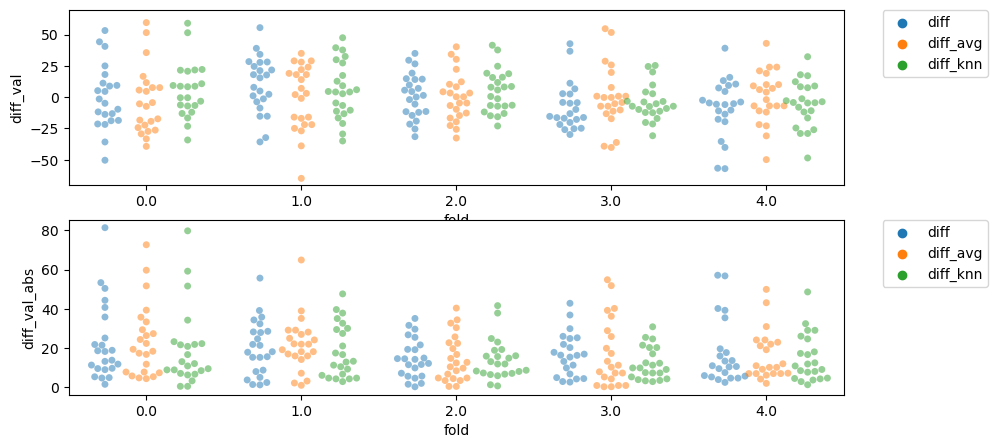

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the distribution of the errors for each fold with a violinplot with the same y-axis in individal plots on the same row
import seaborn as sns
import matplotlib.pyplot as plt
df_vis = pd.melt(df_train[["diff", "diff_avg", "diff_knn", "fold"]], id_vars="fold", value_vars=["diff", "diff_avg", "diff_knn"], var_name="diff_type", value_name="diff_val")
df_vis["diff_val_abs"] = df_vis["diff_val"].abs()

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
#sns.violinplot(x="fold", y="diff", data=df_train, ax=ax)
sns.swarmplot(x="fold", y="diff_val", hue="diff_type", data=df_vis, alpha=0.5, ax=ax[0], dodge=True)
#plt.show()
# make ylim between -70 and 70
ax[0].set_ylim(-70, 70)
# put the legend outside the plot
ax[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#sns.swarmplot(x="fold", y="diff_sq", data=df_train, color="black", alpha=0.5, ax=ax[1])

sns.swarmplot(x="fold", y="diff_val_abs", hue="diff_type", data=df_vis, alpha=0.5, ax=ax[1], dodge=True)
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
plt.tight_layout()


In [ ]:
# compute the r2 score between "y_pred" and "suffer_score" for each fold
df_train.groupby("fold").apply(lambda x: r2_score(x.suffer_score, x.y_pred))


fold
0.0    0.003056
1.0    0.088022
2.0    0.112855
3.0    0.323460
4.0   -0.406645
dtype: float64

In [ ]:
from sklearn.model_selection import cross_validate
# import cross_val_score
from sklearn.model_selection import cross_val_score
# import regression models
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor

# make a liner regression model with polynomial features
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# make model with make_pipeline with polynomial features and linear regression
model_lin_poly = make_pipeline(PolynomialFeatures(2), LinearRegression())
# set name attribute of model model_lin_poly to "linear+polynomial"
model_lin_poly.__class__.__name__ = "linear+polynomial"



# create a list of models to evaluate
models = [model_lin_poly, LinearRegression(), Lasso(), Ridge(), ElasticNet(), SVR(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(), GradientBoostingRegressor(), LGBMRegressor()]

# initialize a dictionary to store the results
scores_data = []
#scores_dict = defaultdict(lambda: defaultdict(dict))

types = ["Ride", "VirtualRide", "Run"]
features_ride = ["elev_gain", "kilojoules", "mean_watts", "average_speed", "distance", "moving_time_min", "elapsed_time_min"]
features_run = ["elev_gain", "average_speed", "distance", "moving_time_min", "elapsed_time_min"]
features_virtualride_for_watts = ["suffer_score", "max_hr", "mean_hr", "elapsed_time_min"]
features_virtualride_for_hr = ["kilojoules", "mean_watts", "average_speed", "distance", "elapsed_time_min"]

# for Ride, Run and VirtualRide,m oi
cols_to_impute_all = ["suffer_score", "max_hr", "mean_hr"]
# only for type VirtualRide
cols_to_impute_virtual_ride = ["mean_watts", "kilojoules"] + cols_to_impute_all


def cv_tester(model, X, y):
    scores = cross_validate(model, X, y, cv=5,  scoring=("r2", "neg_mean_squared_error"), return_train_score=True)
    return scores  

for activity_type in types:
    
    for model in models:
        # cols to impute
        if activity_type == "VirtualRide":
            cols_to_impute = cols_to_impute_virtual_ride
        else:
            cols_to_impute = cols_to_impute_all
        # which target to impute
        for target in cols_to_impute:
            temp_dict = {}
            print(f"activity_type: {activity_type}, target: {target}")
            if activity_type == "Ride":
                features = features_ride
            elif activity_type == "Run":
                features = features_run
            elif activity_type == "VirtualRide" and target in ["mean_watts", "kilojoules"] :
                features = features_virtualride_for_watts
            elif activity_type == "VirtualRide" and target in ["suffer_score", "max_hr", "mean_hr"]:
                features = features_virtualride_for_hr
            else:
                # raise an error
                raise ValueError("activity_type and target combination not valid")
    


            # get the name of the model
            model_name = model.__class__.__name__
            print(model_name)

            df_temp = df_pred[(df_pred.type == activity_type)][[target] + features].copy()

            cond = df_temp[target].notna()
            df_train = df_temp[cond].copy()
            if "suffer_score" in features:
                cond = df_train["suffer_score"].notna()
                df_train = df_train[cond].copy()

            # if any of the features are null drop the row
            cond = df_train[features].isnull().any(axis=1)
            df_train = df_train[~cond].copy()

            
            scores = cv_tester(model, df_train[features], df_train[target])
            # save the results in a dataframe
            # convert dictionary to a dataframe
            #scores = pd.DataFrame(scores)
            # save the dataframe in a dictionary with the model name as key
            temp_dict["activity_type"] = activity_type
            temp_dict["model_name"] = model_name
            temp_dict["target"] = target
            # loop through the scores dictionary and save the results in a dictionary
            temp_dict["scores"] = scores
            #temp_dict2 = {}
            #for score_type, scores in scores.items():
            #    temp_dict2["score_name"] = score_type
            #    temp_dict2["cv"] = range(len(scores))
            #    temp_dict2["values"] = scores
                # for cv_number, value in enumerate(scores):
                #    temp_dict2["cv"][f"{cv_number}"] = value
                
            #    temp_dict["scores"].append(temp_dict2)
                    
            scores_data.append(temp_dict)
        

# initialize a dataframe
# scores_df = pd.DataFrame()
# loop through the dictionary and print the results
#for activity_type, scores in scores_dict.items():
#    # create new dataframe that will be appended to scores_df 
#    scores_df_temp = {}
#
#    scores_df_temp["activiy_type"] = type_model_name[0]
#    scores_df_temp["model_name"] = type_model_name[1]
#    scores_df_temp["train_r2_mean"] = scores["train_r2"].mean()
#    scores_df_temp["train_r2_std"] = scores["train_r2"].std()
#    scores_df_temp["test_r2_mean"] = scores["test_r2"].mean()
#    scores_df_temp["test_r2_std"] = scores["test_r2"].std()
#    scores_df_temp["train_neg_mean_squared_error_mean"] = np.abs(scores["train_neg_mean_squared_error"].mean())
#    scores_df_temp["train_neg_mean_squared_error_std"] = np.abs(scores["train_neg_mean_squared_error"].std())
#    scores_df_temp["test_neg_mean_squared_error_mean"] = np.abs(scores["test_neg_mean_squared_error"].mean())
#    scores_df_temp["test_neg_mean_squared_error_std"] = np.abs(scores["test_neg_mean_squared_error"].std())
#    # append the dictionary scores_df_temp to scores_df
#    # scores_df = scores_df.append(scores_df_temp, ignore_index=True)
#    # concatenate the dataframes scores_df and scores_df_temp
#    scores_df = pd.concat([scores_df, pd.DataFrame(scores_df_temp, index=[0])], ignore_index=True)
    
    


#activity_type = "Ride"
#cols_to_impute = "suffer_score"
#features_ride = ["elev_gain", "kilojoules", "mean_watts", "average_speed", "distance", "moving_time_min", "elapsed_time_min"]
#df_temp = df_pred[(df_pred.type == activity_type)][[target] + features_ride].copy()
#target = cols_to_impute
#cond = df_temp[target].notna()
#df_train = df_temp[cond][[target] + features_ride]

#scores = cross_validate(model, df_train[features_ride], df_train[target], cv=5,  scoring=("r2", "neg_mean_squared_error"), return_train_score=True)
#return scores


activity_type: Ride, target: suffer_score
linear+polynomial
activity_type: Ride, target: max_hr
linear+polynomial
activity_type: Ride, target: mean_hr
linear+polynomial
activity_type: Ride, target: suffer_score
LinearRegression
activity_type: Ride, target: max_hr
LinearRegression
activity_type: Ride, target: mean_hr
LinearRegression
activity_type: Ride, target: suffer_score
Lasso


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e+03, tolerance: 2.532e+02



activity_type: Ride, target: max_hr
Lasso
activity_type: Ride, target: mean_hr
Lasso
activity_type: Ride, target: suffer_score
Ridge
activity_type: Ride, target: max_hr
Ridge
activity_type: Ride, target: mean_hr
Ridge
activity_type: Ride, target: suffer_score
ElasticNet


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.826e+03, tolerance: 2.532e+02



activity_type: Ride, target: max_hr
ElasticNet
activity_type: Ride, target: mean_hr
ElasticNet
activity_type: Ride, target: suffer_score
SVR
activity_type: Ride, target: max_hr
SVR
activity_type: Ride, target: mean_hr
SVR
activity_type: Ride, target: suffer_score
KNeighborsRegressor
activity_type: Ride, target: max_hr
KNeighborsRegressor
activity_type: Ride, target: mean_hr
KNeighborsRegressor
activity_type: Ride, target: suffer_score
DecisionTreeRegressor
activity_type: Ride, target: max_hr
DecisionTreeRegressor
activity_type: Ride, target: mean_hr
DecisionTreeRegressor
activity_type: Ride, target: suffer_score
RandomForestRegressor
activity_type: Ride, target: max_hr
RandomForestRegressor
activity_type: Ride, target: mean_hr
RandomForestRegressor
activity_type: Ride, target: suffer_score
GradientBoostingRegressor
activity_type: Ride, target: max_hr
GradientBoostingRegressor
activity_type: Ride, target: mean_hr
GradientBoostingRegressor
activity_type: Ride, target: suffer_score
LGBMRe

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.683e-01, tolerance: 2.695e-01

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+03, tolerance: 1.682e+00



activity_type: VirtualRide, target: mean_watts
Ridge
activity_type: VirtualRide, target: kilojoules
Ridge
activity_type: VirtualRide, target: suffer_score
Ridge
activity_type: VirtualRide, target: max_hr
Ridge
activity_type: VirtualRide, target: mean_hr
Ridge
activity_type: VirtualRide, target: mean_watts
ElasticNet
activity_type: VirtualRide, target: kilojoules
ElasticNet
activity_type: VirtualRide, target: suffer_score
ElasticNet
activity_type: VirtualRide, target: max_hr
ElasticNet


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+00, tolerance: 2.695e-01

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.747e+00, tolerance: 1.695e+00



activity_type: VirtualRide, target: mean_hr
ElasticNet
activity_type: VirtualRide, target: mean_watts
SVR


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.475e+00, tolerance: 1.628e+00

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.534e+01, tolerance: 1.682e+00



activity_type: VirtualRide, target: kilojoules
SVR
activity_type: VirtualRide, target: suffer_score
SVR
activity_type: VirtualRide, target: max_hr
SVR
activity_type: VirtualRide, target: mean_hr
SVR
activity_type: VirtualRide, target: mean_watts
KNeighborsRegressor
activity_type: VirtualRide, target: kilojoules
KNeighborsRegressor
activity_type: VirtualRide, target: suffer_score
KNeighborsRegressor
activity_type: VirtualRide, target: max_hr
KNeighborsRegressor
activity_type: VirtualRide, target: mean_hr
KNeighborsRegressor
activity_type: VirtualRide, target: mean_watts
DecisionTreeRegressor
activity_type: VirtualRide, target: kilojoules
DecisionTreeRegressor
activity_type: VirtualRide, target: suffer_score
DecisionTreeRegressor
activity_type: VirtualRide, target: max_hr
DecisionTreeRegressor
activity_type: VirtualRide, target: mean_hr
DecisionTreeRegressor
activity_type: VirtualRide, target: mean_watts
RandomForestRegressor
activity_type: VirtualRide, target: kilojoules
RandomForestReg

In [ ]:
# make two plotly scatterplots side by side
# one for r2 and one for neg_mean_squared_error
# one for train and one for test
# one for mean and one for std
# import plotly graph objects
import plotly.graph_objects as go

# plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.train_r2_mean, name="train_r2_mean"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.test_r2_mean, name="test_r2_mean"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.train_r2_std, name="train_r2_std"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.test_r2_std, name="test_r2_std"))
fig.update_layout(title="R2", xaxis_title="model", yaxis_title="r2")
fig.show()

# make a second plot of neg_mean_squared_error
fig = go.Figure()
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.train_neg_mean_squared_error_mean, name="train_neg_mean_squared_error_mean"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.test_neg_mean_squared_error_mean, name="test_neg_mean_squared_error_mean"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.train_neg_mean_squared_error_std, name="train_neg_mean_squared_error_std"))
fig.add_trace(go.Scatter(x=scores_df.model_name, y=scores_df.test_neg_mean_squared_error_std, name="test_neg_mean_squared_error_std"))
fig.update_layout(title="neg_mean_squared_error", xaxis_title="model", yaxis_title="neg_mean_squared_error")
fig.show()


In [ ]:
scores_df

model_name  train_r2_mean  train_r2_std  test_r2_mean  \
0           LinearRegression       0.827417      0.014571      0.793073   
1                      Lasso       0.826877      0.014723      0.796022   
2                      Ridge       0.827417      0.014571      0.793113   
3                 ElasticNet       0.826900      0.014605      0.795932   
4                        SVR       0.424777      0.044872      0.373518   
5        KNeighborsRegressor       0.799846      0.017083      0.713155   
6      DecisionTreeRegressor       1.000000      0.000000      0.622637   
7      RandomForestRegressor       0.967686      0.003122      0.726827   
8  GradientBoostingRegressor       0.967424      0.004173      0.665245   
9              LGBMRegressor       0.899824      0.010055      0.680896   

   test_r2_std  train_neg_mean_squared_error_mean  \
0     0.069548                        1067.297972   
1     0.068682                        1070.647731   
2     0.069546                        1067.298361   
3     0.068829                        1070.513705   
4     0.201840                        3542.067181   
5     0.135621                        1235.446214   
6     0.096368                           0.000000   
7     0.041183                         199.033483   
8     0.080361                         202.365643   
9     0.094533                         618.038772   

   train_neg_mean_squared_error_std  test_neg_mean_squared_error_mean  \
0                        160.375753                       1268.708870   
1                        161.282542                       1252.368986   
2                        160.375773                       1268.512768   
3                        160.904476                       1253.178317   
4                        342.154449                       3723.904559   
5                        157.778118                       1764.833442   
6                          0.000000                       2146.384073   
7                         22.690089                       1506.671108   
8                         42.370297                       1766.736052   
9                         84.842645                       1829.871381   

   test_neg_mean_squared_error_std  
0                       722.542837  
1                       713.670808  
2                       722.475677  
3                       715.308263  
4                      2003.064342  
5                      1138.544908  
6                      1207.000106  
7                       693.783166  
8                       760.012607  
9                      1038.408676

In [ ]:
# make a scatterplot with plotly
scores = pd.DataFrame(scores)
fig = px.scatter(scores, x="test_r2", y="test_neg_mean_squared_error")
fig.show()

In [ ]:
types = ["Ride", "VirtualRide", "Run"]
features_ride = ["elev_gain", "kilojoules", "mean_watts", "average_speed", "distance", "moving_time_min", "elapsed_time_min"]
features_run = ["elev_gain", "average_speed", "distance", "moving_time_min", "elapsed_time_min"]
features_virtualride_for_watts = ["suffer_score", "max_hr", "mean_hr", "elapsed_time_min"]
features_virtualride_for_hr = ["kilojoules", "mean_watts", "average_speed", "distance", "elapsed_time_min"]
for activity_type in types:
    if activity_type == "Ride":
        cols_to_impute = ["suffer_score", "max_hr", "mean_hr"]
        df_temp = df_pred[(df_pred.type == activity_type)][cols_to_impute + features_ride].copy()
        
        for col in cols_to_impute:
            target = col
            cond = df_temp[target].notna()
            df_train = df_temp[cond][[target] + features_ride]
            # fit the lgbmregressor and avoid overfitting
            model = LGBMRegressor(random_state=42)#, boosting_type="goss") # goss-> 0.72, 0.31, 0.26
            # initialize linear regression
            model = LinearRegression() # 0.81, 0.19, 0.22, log-trans -> 0.76, 0.28, 0.31
            # import make_pipeline
            from sklearn.pipeline import make_pipeline
            # import polynomial features
            from sklearn.preprocessing import PolynomialFeatures
            # initialize polynomial regressor
            #model = make_pipeline(PolynomialFeatures(2), LinearRegression()) # 0.74, 0.23, 0.26
            # import knn regressor
            from sklearn.neighbors import KNeighborsRegressor
            # initialize knn regressor
            model = KNeighborsRegressor(n_neighbors=17, weights="distance") # 0.81, 0.27, 0.39
            # import xgboost regressor
            from xgboost import XGBRegressor
            # instantiate a xgboost regressor and reduce overfitting
            #model = XGBRegressor(random_state=42, eta=0.05)

            # impprt svm regressor
            from sklearn.svm import SVR
            # initialize svm regressor
            # model = SVR(kernel="rbf", C=2000.0, epsilon=10.001) # 0.78, 0.31, 0.31
            # import random forest regressor
            from sklearn.ensemble import RandomForestRegressor
            # initialize random forest regressor
            #model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=6, min_samples_leaf=20) # 0.7, 0.31, 0.24

            #model = make_pipeline(PolynomialFeatures(2), XGBRegressor(random_state=42, eta=0.1)) # 0.74, 0.23, 0.26
            # train a neural network sklearn
            from sklearn.neural_network import MLPRegressor
            # initialize neural network
            # model = MLPRegressor(random_state=42, hidden_layer_sizes=(100, 100, 100), activation="relu", solver="adam", alpha=0.0001, learning_rate="constant", learning_rate_init=0.001, max_iter=1000, early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, verbose=True) # 0.81, 0.27, 0.31

            
            
            # instantiate a xgboost regressor
            #model = XGBRegressor(random_state=42, booster="gblinear")
            print(f"Predicing type: {activity_type}, target: {target}")
            _ = train_test_score(model, df_train[features_ride], df_train[target], do_scaling=False, do_log=False)

            
    elif activity_type == "VirtualRide":
        cols_to_impute = ["mean_watts", "kilojoules"]
        df_temp = df_pred[(df_pred.type == activity_type)][cols_to_impute + features_virtualride_for_watts].copy()
        

        for col in cols_to_impute:
            target = col
            cond = df_temp[target].notna()
            df_train = df_temp[cond][[target] + features_virtualride_for_watts]
            df_train = df_train[df_train.suffer_score.notna()].copy()
            
            model = KNeighborsRegressor(n_neighbors=17, weights="distance") # 0.17, 0.71
            model = LGBMRegressor(random_state=42) # 0.2, 0.78
            model = make_pipeline(PolynomialFeatures(2), LinearRegression()) # -0.16, 0.91
            model = LinearRegression() # 0.25, 0.92
            model = SVR(kernel="rbf", C=200.0, epsilon=1.001) # 0.32, 0.93

            print(f"Predicing type: {activity_type}, target: {target}")
            _ = train_test_score(model, df_train[features_virtualride_for_watts], df_train[target], do_scaling=False, do_log=False)




Predicing type: Ride, target: suffer_score
r2_train: 1.00 mae_train: 0.00 rmse_train: 0.00
r2_test: 0.81 mae_test: 21.40 rmse_test: 34.79
Predicing type: Ride, target: max_hr
r2_train: 1.00 mae_train: 0.00 rmse_train: 0.00
r2_test: 0.27 mae_test: 8.73 rmse_test: 11.35
Predicing type: Ride, target: mean_hr
r2_train: 1.00 mae_train: 0.00 rmse_train: 0.00
r2_test: 0.39 mae_test: 8.05 rmse_test: 9.96
Predicing type: VirtualRide, target: mean_watts
r2_train: 0.24 mae_train: 10.22 rmse_train: 13.77
r2_test: 0.30 mae_test: 11.32 rmse_test: 13.18
Predicing type: VirtualRide, target: kilojoules
r2_train: 0.85 mae_train: 37.07 rmse_train: 48.23
r2_test: 0.90 mae_test: 36.40 rmse_test: 49.51


In [ ]:
#cols_to_impute = ["suffer_score", "max_hr", "mean_hr"]
cols_to_impute = ["mean_watts", "kilojoules"]
activity_type = "VirtualRide"
df_temp = df_pred[(df_pred.type == activity_type)][cols_to_impute + features_virtualride_for_watts].copy()

target = "mean_watts"
cond = df_temp[target].notna()
df_train = df_temp[cond][[target] + features_virtualride_for_watts]
df_train = df_train[df_train.suffer_score.notna()].copy()

# make a grid search for the best parameters for the lgbm model
from sklearn.model_selection import GridSearchCV
# initialize lgbm regressor
#model = SVR()
# import knn regressor
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()
# define the parameters for the grid search for SVR
params = {"kernel": ["rbf"], "C": [1.0, 10.0, 100.0, 1000, 2000, 10000], "epsilon": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
# define the parameters for the grid search for KNN
params = {"n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19, 21], "weights": ["uniform", "distance"]}

# initialize grid search
grid = GridSearchCV(model, params, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
# fit the grid search
grid.fit(df_train[features_virtualride_for_watts], df_train[target])
# print the best parameters
print(grid.best_params_)
# print the best score
print(grid.best_score_)
# print the best estimator
print(grid.best_estimator_)
# make a dataframe of the results
df_results = pd.DataFrame(grid.cv_results_)
# make a plot of the results
#df_results.plot(x="param_C", y="mean_test_score", kind="scatter", logx=True)
plt.show()





{'n_neighbors': 7, 'weights': 'uniform'}
-251.88413366136962
KNeighborsRegressor(n_neighbors=7)


In [ ]:
# use best parameters from the grid search to fit the model again
#model = LGBMRegressor(random_state=42, **grid.best_params_)
#model = SVR(**grid.best_params_)
model = KNeighborsRegressor(**grid.best_params_)

# use test_train_split 
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(df_train[features_virtualride_for_watts], df_train[target], test_size=0.2, random_state=42)
# fit the model
model.fit(X_train, y_train)
# make predictions
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
# compute r2 score for train and test
from sklearn.metrics import r2_score
print(f"Train r2 score: {r2_score(y_train, y_train_pred)}")
print(f"Test r2 score: {r2_score(y_test, y_test_pred)}")


Train r2 score: 0.2817946091816552
Test r2 score: 0.2866545019344381


In [ ]:
df_pred.groupby("type")["suffer_score_missing"].mean()

type
EBikeRide      0.000000
Hike           0.000000
IceSkate       0.000000
Ride           0.104615
Run            0.079082
VirtualRide    0.287770
Workout        0.000000
Name: suffer_score_missing, dtype: float64

In [ ]:
df_pred.type.value_counts()

Ride           650
Run            392
VirtualRide    139
Hike            20
Workout         14
IceSkate         8
EBikeRide        6
Name: type, dtype: int64

In [3]:
df_pred = df.copy()


# drop moving_time and elapsed_time columns
df_pred = df_pred.drop(["moving_time", "elapsed_time", "calories", "weighted_mean_watts"], axis=1)

# drop rows where type AlpineSki, NordicSki, WeightTraining, Walk 
cond = df_pred.type.isin(["AlpineSki", "NordicSki", "WeightTraining", "Walk"])
df_pred = df_pred[~cond].copy()

df_pred = df_pred.sort_values("start_date", ascending=True)

# impute suffer_score, max_hr, mean_hr, mean_watts, weighted_mean_watts, kilojoules
cols_to_impute = ["suffer_score", "max_hr", "mean_hr", "mean_watts", "kilojoules"]

# add a missing indicator for these columns ["suffer_score", "max_hr", "mean_hr", "mean_watts", "kilojoules"]
for col in cols_to_impute:
    df_pred[col + "_missing"] = df_pred[col].isnull()
    # convert missing indicator to int
    df_pred[col + "_missing"] = df_pred[col + "_missing"].astype(int)

# impute important columns using impute_fun
#df_imputed = impute_fun(df_pred, cols_to_impute)

In [12]:
df_pred.head()

activity_id  suffer_score  max_hr  mean_hr  mean_watts  type  \
1238    936340119           NaN     NaN      NaN         NaN   Run   
1237    936340125           NaN     NaN      NaN         NaN   Run   
1236    936340120           NaN     NaN      NaN         NaN   Run   
1235    936340124           NaN     NaN      NaN       123.7  Ride   
1234    936340130           NaN     NaN      NaN         NaN   Run   

                     start_date            name  elev_gain  kilojoules  \
1238  2014-03-06 16:49:32+00:00   Afternoon Run       13.2         NaN   
1237  2014-03-29 14:56:55+00:00  Afternoon Ride       49.9         NaN   
1236  2014-04-05 15:11:56+00:00   Afternoon Run       84.0         NaN   
1235  2014-04-06 09:58:55+00:00      Lunch Ride       90.9       273.6   
1234  2014-04-13 15:39:59+00:00  Afternoon Ride       50.0         NaN   

      average_speed  distance  year        date  hour  moving_time_min  \
1238           2.21    4016.6  2014  2014-03-06    16        30.316667   
1237           2.61    6275.0  2014  2014-03-29    14        40.016667   
1236           2.44    6911.7  2014  2014-04-05    15        47.166667   
1235           3.76    8314.9  2014  2014-04-06     9        36.850000   
1234           2.83    6241.4  2014  2014-04-13    15        36.816667   

      elapsed_time_min  suffer_score_missing  max_hr_missing  mean_hr_missing  \
1238         34.800000                     1               1                1   
1237         40.016667                     1               1                1   
1236         50.416667                     1               1                1   
1235         37.733333                     1               1                1   
1234         40.450000                     1               1                1   

      mean_watts_missing  kilojoules_missing  
1238                   1                   1  
1237                   1                   1  
1236                   1                   1  
1235                   0                   0  
1234                   1                   1

In [3]:
df_pred = df.copy()

# drop moving_time and elapsed_time columns
df_pred = df_pred.drop(["moving_time", "elapsed_time", "calories", "weighted_mean_watts"], axis=1)

# drop rows where type AlpineSki, NordicSki, WeightTraining, Walk 
cond = df_pred.type.isin(["AlpineSki", "NordicSki", "WeightTraining", "Walk"])
df_pred = df_pred[~cond].copy()

# impute suffer_score, max_hr, mean_hr, mean_watts, kilojoules
cols_to_impute = ["suffer_score", "max_hr", "mean_hr", "mean_watts", "kilojoules"]

# add a missing indicator for these columns ["suffer_score", "max_hr", "mean_hr", "mean_watts", "kilojoules"]
for col in cols_to_impute:
    df_pred[col + "_missing"] = df_pred[col].isnull()
    # convert missing indicator to int
    df_pred[col + "_missing"] = df_pred[col + "_missing"].astype(int)

df_pred = df_pred.reset_index(drop=True)

df_non_numeric = pd.concat([df_pred[["activity_id"]], df_pred.select_dtypes(exclude=np.number)], axis=1)
# impute important columns using impute_fun
df_numeric = df_pred.select_dtypes(include=np.number).drop(columns=["activity_id"])

# impute
df_imputed = impute(df_numeric, method="mice")

df_imputed = pd.concat([df_imputed, df_non_numeric], axis=1)


df_imputed["start_date"] = pd.to_datetime(df_imputed["start_date"])
df_imputed["date"] = pd.to_datetime(df_imputed["date"])

df_imputed.reset_index(drop=True, inplace=True)

df_imputed = df_imputed.sort_values("start_date", ascending=True)

# obtain number of days between current start_date and previous start_date for each row in df_imputed 
df_imputed["days_since"] = df_imputed.start_date.diff().dt.days
# get suffer score from previous row for each row in df_imputed 
df_imputed["suffer_score_shift1"] = df_imputed.suffer_score.shift(1)
# get heartrate from previous row for each row in df_imputed
df_imputed["mean_hr_shift1"] = df_imputed.mean_hr.shift(1)
# get max_hr from previous row for each row in df_imputed
df_imputed["max_hr_shift1"] = df_imputed.max_hr.shift(1)
# get watts from previous row for each row in df_imputed
df_imputed["mean_watts_shift1"] = df_imputed.mean_watts.shift(1)
# get weighted_watts from previous row for each row in df_imputed
#df_imputed["weighted_mean_watts_shift1"] = df_imputed.weighted_mean_watts.shift(1)
# get elapsed_time from previous row for each row in df_imputed
df_imputed["moving_time_min_shift1"] = df_imputed.moving_time_min.shift(1)
# get kilojoules from previous row for each row in df_imputed
df_imputed["kilojoules_shift1"] = df_imputed.kilojoules.shift(1)


#cond = df_train["name"].str.lower().str.contains("sufferfest")
df_imputed["name"] = df_imputed["name"].str.replace("The Sufferfest", "Wahoo SYSTM", regex=False)

# if name contains "Wahoo SYSTM" then set type to "VirtualRide"
df_imputed.loc[df_imputed["name"].str.contains("Wahoo SYSTM"), "type"] = "VirtualRide"

In [4]:
df_imputed.head()

suffer_score      max_hr     mean_hr  mean_watts  elev_gain  kilojoules  \
1228     37.618652  164.168467  139.025586  105.629077       13.2  168.521047   
1227     50.368662  164.544206  139.568047  112.655083       49.9  263.200083   
1226     57.597040  165.523913  139.556675  112.884662       84.0  321.428121   
1225     27.830556  154.713940  126.227946  123.700000       90.9  273.600000   
1224     47.036721  164.530482  139.839720  121.199169       50.0  254.502200   

      average_speed  distance    year  hour  moving_time_min  \
1228           2.21    4016.6  2014.0  16.0        30.316667   
1227           2.61    6275.0  2014.0  14.0        40.016667   
1226           2.44    6911.7  2014.0  15.0        47.166667   
1225           3.76    8314.9  2014.0   9.0        36.850000   
1224           2.83    6241.4  2014.0  15.0        36.816667   

      elapsed_time_min  suffer_score_missing  max_hr_missing  mean_hr_missing  \
1228         34.800000                   1.0             1.0              1.0   
1227         40.016667                   1.0             1.0              1.0   
1226         50.416667                   1.0             1.0              1.0   
1225         37.733333                   1.0             1.0              1.0   
1224         40.450000                   1.0             1.0              1.0   

      mean_watts_missing  kilojoules_missing  activity_id  type  \
1228                 1.0                 1.0    936340119   Run   
1227                 1.0                 1.0    936340125   Run   
1226                 1.0                 1.0    936340120   Run   
1225                 0.0                 0.0    936340124  Ride   
1224                 1.0                 1.0    936340130   Run   

                    start_date            name       date  days_since  \
1228 2014-03-06 16:49:32+00:00   Afternoon Run 2014-03-06         NaN   
1227 2014-03-29 14:56:55+00:00  Afternoon Ride 2014-03-29        22.0   
1226 2014-04-05 15:11:56+00:00   Afternoon Run 2014-04-05         7.0   
1225 2014-04-06 09:58:55+00:00      Lunch Ride 2014-04-06         0.0   
1224 2014-04-13 15:39:59+00:00  Afternoon Ride 2014-04-13         7.0   

      suffer_score_shift1  mean_hr_shift1  max_hr_shift1  mean_watts_shift1  \
1228                  NaN             NaN            NaN                NaN   
1227            37.618652      139.025586     164.168467         105.629077   
1226            50.368662      139.568047     164.544206         112.655083   
1225            57.597040      139.556675     165.523913         112.884662   
1224            27.830556      126.227946     154.713940         123.700000   

      moving_time_min_shift1  kilojoules_shift1  
1228                     NaN                NaN  
1227               30.316667         168.521047  
1226               40.016667         263.200083  
1225               47.166667         321.428121  
1224               36.850000         273.600000

### TODO:
1.  Replace missing values of suffer_score, max_hr and mean_hr
2. Test to remove all year with 2014


In [5]:
# suppress warnings useing the module warning related to PerformanceWarning from Pandas
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# create a full date range for the dataframe for every day from min to max date in the dataframe 
# and then merge the dataframe with the full date range
# this will create a dataframe with all dates and all columns from the original dataframe
# and fill all missing values with NaN
df_full = pd.DataFrame({'date': pd.date_range(df.date.min(), df.date.max(), freq='1d')})
df_full = df_full.merge(df_imputed, on='date', how='left')

# if id is null fill all float columns with 0
cond = df_full["activity_id"].isnull()
df_full.loc[cond, df_full.select_dtypes("float").columns] = 0

In [6]:
# create rolling mean, std, max features for float columns for 7, 14, 30, 60, 90 days but dont include current row
for col in df_full.select_dtypes("float").columns:
    if col not in ["activity_id", "hour", "suffer_score_missing", "calories_missing", "year"]:
        # if col doesnt contain _shift1 then create rolling features
        if "_shift1" not in col:
            for days in [7, 14, 30, 60, 90]:
                df_full[f"{col}_rolling_mean_{days}"] = df_full[col].rolling(days).mean().shift(1)
                df_full[f"{col}_rolling_std_{days}"] = df_full[col].rolling(days).std().shift(1)
                df_full[f"{col}_rolling_max_{days}"] = df_full[col].rolling(days).max().shift(1)
        

In [9]:
df_train = df_full.copy()

# only get virtual rides
cond = df_train["mean_watts"].gt(0)
df_train = df_train[cond].copy()

cond = df_train["type"] == "VirtualRide"

cond2 = df_train["name"].str.contains("Wahoo")
cond2.fillna(False, inplace=True)
df_train = df_train[cond | cond2].copy()

# convert year to int
df_train["year"] = df_train["year"].astype(int)

# dont use imputed values as targets!!!!!!!!!!!!!!!!!!!!!!!1
cond = df_train.mean_watts_missing == 0
df_train = df_train[cond].copy()

In [10]:
cols_drop = (
    ["name", "start_date", "date", "suffer_score", "cumsum", "cumcount", "id_not_null" ,"type",
    "name", "mean_watts", "kilojoules", "average_speed", "distance", "max_hr"]
)

cols_drop = (
    ["name", "start_date", "date", "suffer_score", "type",
    "name", "kilojoules", "average_speed", "distance", "max_hr"]
)
df_train = df_train.drop(cols_drop, axis=1)

In [11]:
df_train.head()

mean_hr  mean_watts  elev_gain  year  hour  moving_time_min  \
1960  137.406342       212.2      248.0  2019  18.0        46.366667   
1961  136.355213       219.3      380.0  2019  18.0        45.466667   
1973  135.973741       165.7      148.0  2019  19.0        44.200000   
1989  136.748919       190.2        0.0  2019  10.0        40.316667   
1990  134.101838       203.3       18.0  2019  11.0        12.133333   

      elapsed_time_min  suffer_score_missing  max_hr_missing  mean_hr_missing  \
1960         46.366667                   1.0             1.0              1.0   
1961         45.466667                   1.0             1.0              1.0   
1973         44.200000                   1.0             1.0              1.0   
1989         40.316667                   1.0             1.0              1.0   
1990         12.133333                   1.0             1.0              1.0   

      mean_watts_missing  kilojoules_missing   activity_id  days_since  \
1960                 0.0                 0.0  2.260468e+09         2.0   
1961                 0.0                 0.0  2.262934e+09         1.0   
1973                 0.0                 0.0  2.292542e+09         3.0   
1989                 0.0                 0.0  2.333143e+09         2.0   
1990                 0.0                 0.0  2.333139e+09         0.0   

      suffer_score_shift1  mean_hr_shift1  max_hr_shift1  mean_watts_shift1  \
1960           141.000000      153.100000     175.000000         116.696496   
1961            57.422366      137.406342     163.072592         212.200000   
1973            49.000000      145.400000     163.000000         133.456355   
1989           200.000000      152.700000     171.000000         210.600000   
1990            52.283790      136.748919     161.121605         190.200000   

      moving_time_min_shift1  kilojoules_shift1  suffer_score_rolling_mean_7  \
1960               68.350000         606.103393                    30.285714   
1961               46.366667         590.400000                    38.488909   
1973               32.166667         285.145736                     7.000000   
1989               97.100000        1226.800000                    66.000000   
1990               40.316667         460.200000                    52.611970   

      suffer_score_rolling_std_7  suffer_score_rolling_max_7  \
1960                   55.529915                       141.0   
1961                   54.542881                       141.0   
1973                   18.520259                        49.0   
1989                   85.906926                       200.0   
1990                   78.329921                       200.0   

      suffer_score_rolling_mean_14  suffer_score_rolling_std_14  \
1960                     18.071429                    41.166574   
1961                     19.244455                    42.093706   
1973                     18.092186                    31.120449   
1989                     44.642857                    69.854362   
1990                     48.377414                    68.671658   

      suffer_score_rolling_max_14  suffer_score_rolling_mean_30  \
1960                        141.0                     35.433333   
1961                        141.0                     37.347412   
1973                         92.0                     22.009687   
1989                        200.0                     35.466743   
1990                        200.0                     37.209536   

      suffer_score_rolling_std_30  suffer_score_rolling_max_30  \
1960                    55.486987                        154.0   
1961                    55.212271                        154.0   
1973                    42.733764                        154.0   
1989                    56.298155                        200.0   
1990                    55.970678                        200.0   

      suffer_score_rolling_mean_60  suffer_score_rolling_std_60  \
1960                     31.63333

## Feature Selection

In [123]:
target = "mean_watts"

from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
# import Piepline
from sklearn.pipeline import Pipeline

# create a pipeline with StandardScaler of both features and target
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression()),
    ]
)

class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

pipe2 = MyPipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", LinearRegression()),
    ]
)
# create a RFECV object with the pipeline and step size of 1
rfecv_lr = RFECV(pipe2, step=1, cv=40, scoring="neg_mean_squared_error", n_jobs=-1)

# fit the RFECV object to the data
rfecv_lr.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# print the number of features
print(f"Optimal number of features : {rfecv_lr.n_features_}")

# save best features from linear regression in a list
best_features_lr = df_train.drop(columns=[target, "activity_id"], axis=1).columns[rfecv_lr.support_].tolist()




Optimal number of features : 5


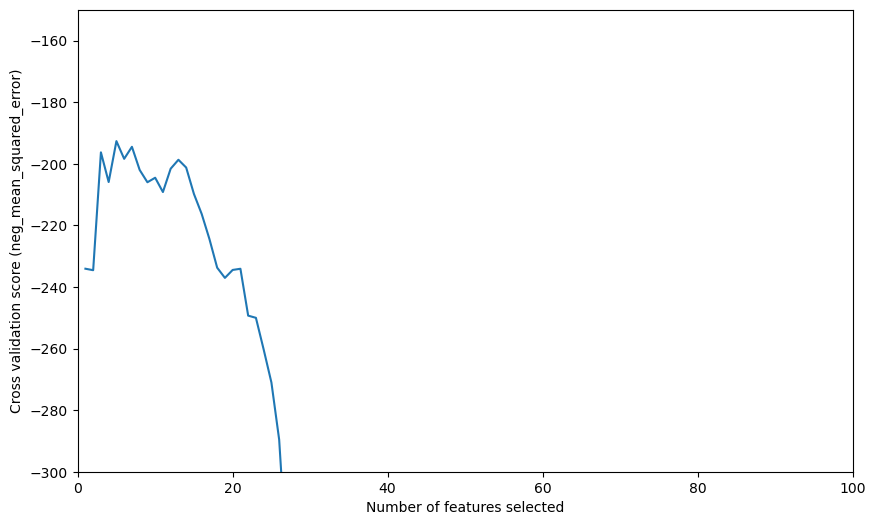

In [126]:
# plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv_lr.grid_scores_) + 1), np.mean(rfecv_lr.grid_scores_, axis=1))
# ylim -2000 to 0
plt.ylim(-300, -150)
# xlim 0 100
plt.xlim(0, 100)
plt.show()

In [128]:
# do rfecv for random forest
from sklearn.ensemble import RandomForestRegressor

pipe2 = MyPipeline(
    [
        #("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor(n_estimators=100, n_jobs=-1)),
    ]
)

# create a RFECV object with the pipeline and step size of 1
rfecv_rf = RFECV(pipe2, step=2, cv=20, scoring="neg_mean_squared_error", n_jobs=-1)

# fit the RFECV object to the data
rfecv_rf.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# print the number of features
print(f"Optimal number of features : {rfecv_rf.n_features_}")

# save best features from random forest in a list
best_features_rf = df_train.drop(columns=[target, "activity_id"], axis=1).columns[rfecv_rf.support_].tolist()


Optimal number of features : 79


In [137]:
#  create a train_test_split
from sklearn.model_selection import train_test_split

# do train test split on the best number of features
X_train, X_test, y_train, y_test = train_test_split(
    #df_train[best_features_rf],
    df_train[top_10_features],
    #df_train[best_features_rf],
    df_train[target],
    test_size=0.2,
    random_state=42,
)

# train a random forest regressor on the train data
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)

# print r2, mae and rmse on train and test data
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print(f"r2 train: {r2_score(y_train, rf.predict(X_train))}")
print(f"r2 test: {r2_score(y_test, rf.predict(X_test))}")
print(f"mae train: {mean_absolute_error(y_train, rf.predict(X_train))}")
print(f"mae test: {mean_absolute_error(y_test, rf.predict(X_test))}")
print(f"rmse train: {np.sqrt(mean_squared_error(y_train, rf.predict(X_train)))}")
print(f"rmse test: {np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))}")



r2 train: 0.9141452358171064
r2 test: 0.7466102719949308
mae train: 3.479798387096781
mae test: 6.740290322580636
rmse train: 4.729130550759732
rmse test: 7.664181510494552


In [134]:
# from rfecv_rf get the feature importances for the features with the lowest score
feature_importances = rfecv_rf.estimator_.feature_importances_

# sort the feature importances
sorted_idx = np.argsort(feature_importances)

# get the feature names
feature_names = df_train[df_train.drop(columns=[target, "activity_id"], axis=1).columns[rfecv_rf.support_]].columns

# create a dataframe with the feature names and the feature importances and sort it
df_feature_importances = pd.DataFrame({"feature": feature_names, "importance": feature_importances})
df_feature_importances = df_feature_importances.sort_values("importance", ascending=False)
df_feature_importances.head(20)

# get the top 20 features in a list
top_10_features = df_feature_importances["feature"].head(20).tolist()

print(top_10_features)


['average_speed_rolling_mean_60', 'mean_watts_rolling_mean_30', 'mean_hr', 'elev_gain', 'mean_watts_rolling_mean_60', 'mean_hr_rolling_std_30', 'mean_hr_rolling_mean_30', 'elev_gain_rolling_mean_7', 'average_speed_rolling_max_30', 'max_hr_rolling_mean_30', 'average_speed_rolling_mean_30', 'average_speed_rolling_mean_90', 'kilojoules_missing_rolling_mean_90', 'days_since_rolling_std_30', 'max_hr_rolling_std_30', 'average_speed_rolling_max_60', 'distance_rolling_std_14', 'mean_hr_rolling_mean_60', 'average_speed_rolling_mean_7', 'elapsed_time_min_rolling_mean_30']


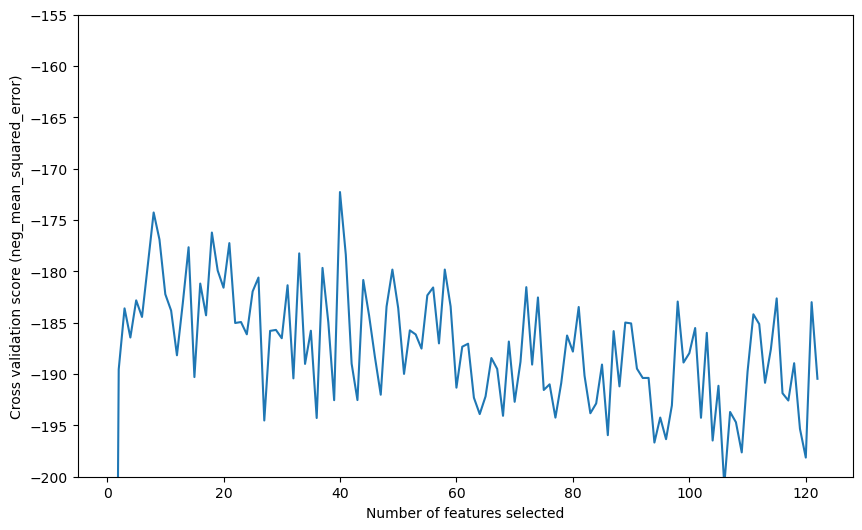

In [131]:
# plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv_rf.grid_scores_) + 1), np.mean(rfecv_rf.grid_scores_, axis=1))
# ylim -220 to 0
plt.ylim(-200, -155)
plt.show()


In [140]:
# do rfecv for lightgbm
# instantiate lightgbm
import lightgbm as lgb

model = lgb.LGBMRegressor(n_estimators=100, n_jobs=-1)

pipe2 = MyPipeline(
    [
        #("scaler", StandardScaler()),
        ("regressor", model),
    ]
)

# create a RFECV object with the pipeline and step size of 1
rfecv_l = RFECV(pipe2, step=1, cv=20, scoring="neg_mean_squared_error", n_jobs=-1)

# fit the RFECV object to the data
rfecv_l.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# print the number of features
print(f"Optimal number of features : {rfecv_l.n_features_}")

# save best features from random forest in a list
best_features_l = df_train.drop(columns=[target, "activity_id"], axis=1).columns[rfecv_l.support_].tolist()


Optimal number of features : 64


In [142]:
# make a train test split on the best number of features
X_train, X_test, y_train, y_test = train_test_split(
    df_train[best_features_l],
    df_train[target],
    test_size=0.2,
    random_state=42,
)

# train a lightgbm regressor on the train data
model = lgb.LGBMRegressor(n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

# print r2, mae and rmse on train and test data
print(f"r2 train: {r2_score(y_train, model.predict(X_train))}")
print(f"r2 test: {r2_score(y_test, model.predict(X_test))}")
print(f"mae train: {mean_absolute_error(y_train, model.predict(X_train))}")
print(f"mae test: {mean_absolute_error(y_test, model.predict(X_test))}")
print(f"rmse train: {np.sqrt(mean_squared_error(y_train, model.predict(X_train)))}")
print(f"rmse test: {np.sqrt(mean_squared_error(y_test, model.predict(X_test)))}")


r2 train: 0.9500742350078974
r2 test: 0.5883861927436266
mae train: 2.5391156403517865
mae test: 8.24581139435235
rmse train: 3.606296807250315
rmse test: 9.768238305661905


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


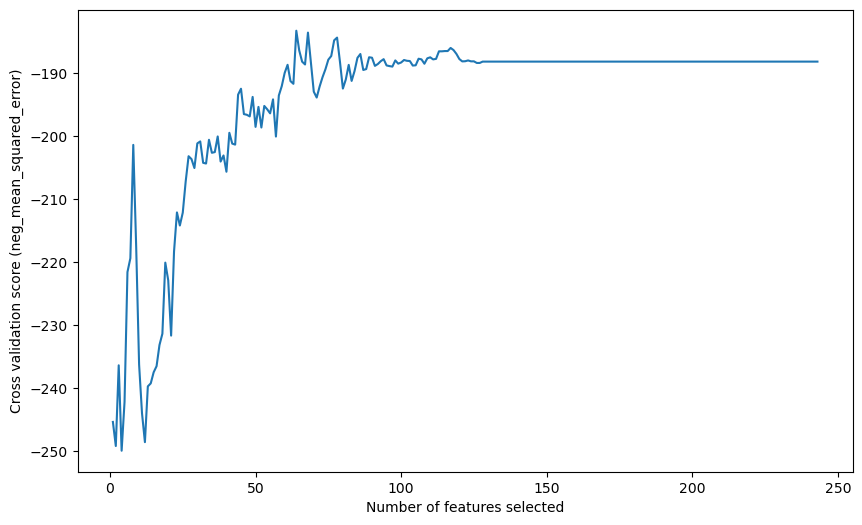

In [141]:
# plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv_l.grid_scores_) + 1), np.mean(rfecv_l.grid_scores_, axis=1))
# ylim -220 to 0


In [156]:
np.logspace(-4, 2, 100)

array([1.00000000e-04, 1.14975700e-04, 1.32194115e-04, 1.51991108e-04,
       1.74752840e-04, 2.00923300e-04, 2.31012970e-04, 2.65608778e-04,
       3.05385551e-04, 3.51119173e-04, 4.03701726e-04, 4.64158883e-04,
       5.33669923e-04, 6.13590727e-04, 7.05480231e-04, 8.11130831e-04,
       9.32603347e-04, 1.07226722e-03, 1.23284674e-03, 1.41747416e-03,
       1.62975083e-03, 1.87381742e-03, 2.15443469e-03, 2.47707636e-03,
       2.84803587e-03, 3.27454916e-03, 3.76493581e-03, 4.32876128e-03,
       4.97702356e-03, 5.72236766e-03, 6.57933225e-03, 7.56463328e-03,
       8.69749003e-03, 1.00000000e-02, 1.14975700e-02, 1.32194115e-02,
       1.51991108e-02, 1.74752840e-02, 2.00923300e-02, 2.31012970e-02,
       2.65608778e-02, 3.05385551e-02, 3.51119173e-02, 4.03701726e-02,
       4.64158883e-02, 5.33669923e-02, 6.13590727e-02, 7.05480231e-02,
       8.11130831e-02, 9.32603347e-02, 1.07226722e-01, 1.23284674e-01,
       1.41747416e-01, 1.62975083e-01, 1.87381742e-01, 2.15443469e-01,
      

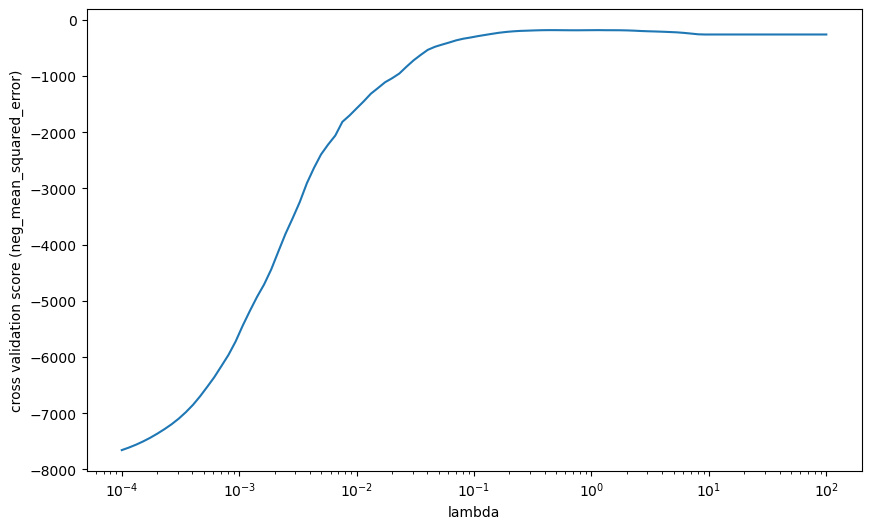

best lambda: 1.1497569953977356
number of features with non zero coefficients: 17


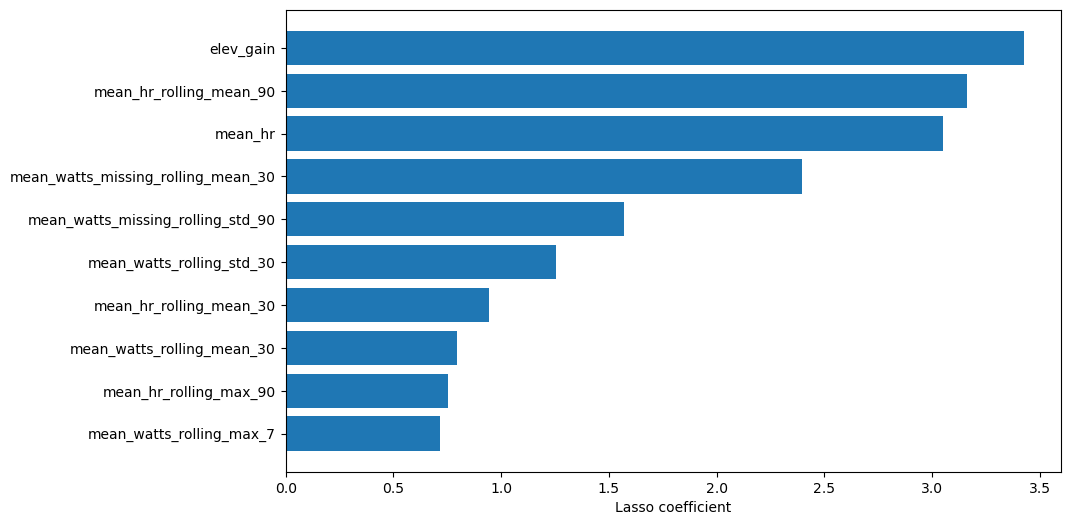

In [163]:
# ignore ConvergenceWarning
import warnings
# import ConvergenceWarning from sklearn
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# do lasso regression to get the most important features
from sklearn.linear_model import Lasso

class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_

pipe2 = MyPipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", Lasso(alpha=0.001, max_iter=10000)),
    ]
)

# do cross validation with lasso
from sklearn.model_selection import cross_val_score

# do cross validation and optimize lambda to find the most important features
cv_scores = []
for alpha in np.logspace(-4, 2, 100):
    #lasso.alpha = alpha
    # change pipe2 regressor alpha value
    pipe2.set_params(regressor__alpha=alpha)
    cv_scores.append(np.mean(cross_val_score(pipe2, df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target], cv=20, scoring="neg_mean_squared_error")))

# plot the cross validation scores
plt.figure(figsize=(10, 6))
plt.plot(np.logspace(-4, 2, 100), cv_scores)
plt.xlabel("lambda")
plt.ylabel("cross validation score (neg_mean_squared_error)")
plt.xscale("log")
plt.show()

# get the best lambda
best_lambda = np.logspace(-4, 2, 100)[np.argmax(cv_scores)]
print(f"best lambda: {best_lambda}")

# train lasso with the best lambda
pipe2 = MyPipeline(
    [
        ("scaler", StandardScaler()),
        ("regressor", Lasso(alpha=best_lambda, max_iter=10000)),
    ]
)
pipe2.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# get the feature importances
# feature_importances = lasso.coef_
feature_importances = pipe2.coef_

# sort the absolute value of feature importances
sorted_idx = np.argsort(np.abs(feature_importances))

# get the feature names
feature_names_lasso = df_train[df_train.drop(columns=[target, "activity_id"], axis=1).columns].columns

# print out the number of features with non zero coefficients
print(f"number of features with non zero coefficients: {len(feature_names_lasso[feature_importances != 0])}")

# get the featyres with non zero coefficients
non_zero_features = feature_names_lasso[feature_importances != 0]

# plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names_lasso[sorted_idx][-10:], feature_importances[sorted_idx][-10:])
plt.xlabel("Lasso coefficient")
plt.show()





Optimal number of features : 19


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


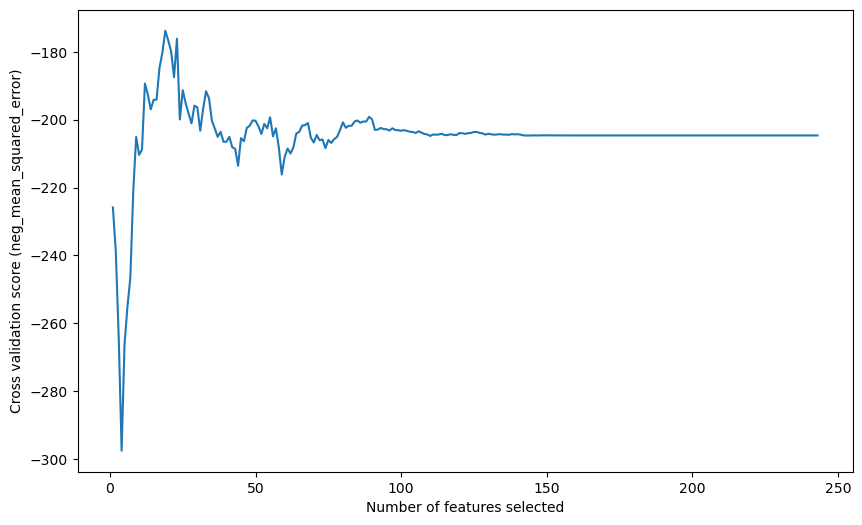

In [166]:
# performe rfecv with xgboost
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

# instantiate XGBRegressor
xgb = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# do rfecv with xgboost
rfecv_xgb = RFECV(xgb, step=1, cv=20, scoring="neg_mean_squared_error", n_jobs=-1)

# fit rfecv with xgboost
rfecv_xgb.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# get the best number of features
print(f"Optimal number of features : {rfecv_xgb.n_features_}")

# get the best features
best_features_xgb = df_train.drop(columns=[target, "activity_id"], axis=1).columns[rfecv_xgb.support_]

# print out the best features
#print(f"Best features: {best_features_xgb}")

# plot number of features VS. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg_mean_squared_error)")
plt.plot(range(1, len(rfecv_xgb.grid_scores_) + 1), np.mean(rfecv_xgb.grid_scores_, axis=1))
# ylim -220 to 0


In [186]:
from sklearn.feature_selection import SequentialFeatureSelector

# instantiate XGBRegressor
xgb = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# do sfs with xgboost
sfs_xgb = SequentialFeatureSelector(xgb, n_features_to_select="auto", direction="forward", cv=5, scoring="neg_mean_squared_error", n_jobs=-1, tol=0.001)

# fit sfs with xgboost
sfs_xgb.fit(df_train.drop(columns=[target, "activity_id"], axis=1), df_train[target])

# get the best number of features
print(f"Optimal number of features : {sfs_xgb.n_features_to_select_}")

# get the best features
best_features_xgb_sfs = df_train.drop(columns=[target, "activity_id"], axis=1).columns[sfs_xgb.support_]

# print out the best features
#print(f"Best features: {best_features_xgb_sfs}")



Optimal number of features : 8


In [188]:
# print out the features selected by sfs
print(best_features_xgb_sfs)

Index(['year', 'max_hr_rolling_std_30', 'mean_hr_rolling_max_90',
       'elev_gain_rolling_max_60', 'moving_time_min_rolling_std_60',
       'max_hr_missing_rolling_max_7', 'max_hr_missing_rolling_max_14',
       'mean_watts_missing_rolling_max_90'],
      dtype='object')


In [189]:
# do cross validation with xgb with the best features
 
 # instantiate XGBRegressor
xgb = XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)

# do cross validation with xgb with r2, rmse and mae
cv_scores = cross_validate(xgb, df_train[best_features_xgb], df_train[target], cv=20, scoring=["r2", "neg_mean_squared_error", "neg_mean_absolute_error"])

# print out the cross validation scores
print(f"r2: {(cv_scores['test_r2'])}")
print(f"rmse: {(cv_scores['test_neg_mean_squared_error'])}")
print(f"mae: {(cv_scores['test_neg_mean_absolute_error'])}")


r2: [-0.15530247  0.16528232  0.39419206 -0.90122597 -0.16022776 -0.34262369
 -0.68700414  0.2320691  -0.17385802  0.37527643  0.05286121 -0.53155696
 -1.30924864  0.27578587  0.28718966  0.26070142 -1.0903506   0.12077989
 -1.43661757 -0.18331269]
rmse: [-736.56598111 -467.23687328  -99.8310897  -194.138937    -65.4294127
  -82.05088045 -130.22591197  -77.48758721 -135.42341476 -155.85135094
 -116.09731344 -229.31619478  -69.799566    -81.65876377  -50.47588229
  -97.13055656  -22.11249648  -78.33599952  -78.11795919 -106.59908605]
mae: [-22.198246   -18.64741287  -8.47034683 -12.08015137  -5.3738102
  -6.41063156  -8.39302864  -6.92547188  -9.20141182 -10.48291817
  -9.01924133 -10.24809799  -5.99470406  -6.92927094  -6.37051926
  -6.96464103  -4.16992493  -6.12356001  -7.09845145  -8.67281712]


In [193]:
# create sets of all best features
best_features = [best_features_xgb, best_features_xgb_sfs, non_zero_features, best_features_l, best_features_lr, best_features_rf]

# check if items in best_features are list type if not try to convert
for i in range(len(best_features)):
    if type(best_features[i]) != list:
        try:
            best_features[i] = list(best_features[i])
        except:
            pass
    
# unested the list
best_features = [item for sublist in best_features for item in sublist]
# create set of best_featurs list
best_features = list(set(best_features))

len(best_features)

120

## Hyperparamter tuning for several models

In [291]:
# use scikit optimize to find the best hyperparameters for xgboost
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# import xgboost
from xgboost import XGBRegressor

# define the search space
search_space = {
    "n_estimators": Integer(5, 1000),
    "max_depth": Integer(2, 10),
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "uniform"),
    "min_child_weight": Integer(1, 10),
    "gamma": Real(0.0, 50.0, "uniform"),
    "reg_alpha": Real(0.0, 50.0, "uniform"),
    "reg_lambda": Real(0.0, 50.0, "uniform"),
}

# instantiate XGBRegressor
xgb = XGBRegressor(n_jobs=-1, random_state=42)

# instantiate BayesSearchCV
opt = BayesSearchCV(
    xgb,
    search_space,
    n_iter=40,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=0,
    refit=True,
    return_train_score=False,
)


# fit BayesSearchCV
opt.fit(df_train[best_features], df_train[target])

# print out the best parameters
print(opt.best_params_)
# print out the best score
print(opt.best_score_)

best_params_xgb = opt.best_params_


OrderedDict([('colsample_bytree', 0.8411943984535506), ('gamma', 40.385952882781325), ('learning_rate', 0.03676442251399389), ('max_depth', 4), ('min_child_weight', 5), ('n_estimators', 454), ('reg_alpha', 24.04311095585655), ('reg_lambda', 26.03973503473157), ('subsample', 0.6721525431007184)])
-166.1237978108114


In [270]:
# use scikit optimize to find the best hyperparameters for knn regressor
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# import knn regressor from sklearn
from sklearn.neighbors import KNeighborsRegressor

# define the search space
search_space = {
    "knn__n_neighbors": Integer(1, 100),
    "knn__weights": Categorical(["uniform", "distance"]),
    #"knn__algorithm": Categorical(["auto", "ball_tree", "kd_tree", "brute"]),
    "knn__leaf_size": Integer(1, 100),
    "knn__p": Integer(1, 10),
    #"knn__metric": Categorical(["minkowski", "euclidean", "manhattan", "chebyshev", "minkowski", "wminkowski", "seuclidean", "mahalanobis"])
}

# create a pipe with knn regressor
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

# instantiate BayesSearchCV
bayes_search = BayesSearchCV(pipe, search_space, n_iter=40, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, random_state=42)

# fit BayesSearchCV
bayes_search.fit(df_train[best_features], df_train[target])

# print out the best parameters
print(bayes_search.best_params_)
# print out the best score
print(bayes_search.best_score_)


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warni

OrderedDict([('knn__leaf_size', 100), ('knn__n_neighbors', 14), ('knn__p', 1), ('knn__weights', 'uniform')])
-201.5757409479922


In [265]:
# use scikit optimize to find the best hyperparameters for support vector machine
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# import support vector machine regressor from sklearn
from sklearn.svm import SVR

# define the search space
search_space = {
    "model__C": Real(1e-6, 100.0, prior="log-uniform"),
    "model__gamma": Real(1e-6, 100.0, prior="log-uniform"),
    "model__epsilon": Real(1e-6, 1.0, prior="log-uniform"),
    "model__degree": Integer(1, 8),
    "model__kernel": Categorical(["linear", "poly", "rbf", "sigmoid"])
}

# create a pipeline with standard scaler and support vector machine regressor
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVR())
])


# instantiate BayesSearchCV using the pipeline and search space
opt = BayesSearchCV(
    pipe,
    search_space,
    #search_spaces={'model__C': Real(1e-6, 100.0, prior="log-uniform")},
    n_iter=40,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42
)


# fit BayesSearchCV
opt.fit(df_train[best_features], df_train[target])

# print out the best parameters
print(opt.best_params_)
# print out the best score
print(opt.best_score_)


OrderedDict([('model__C', 2.192277614895957), ('model__degree', 4), ('model__epsilon', 0.0026954772308544943), ('model__gamma', 0.002473783584600822), ('model__kernel', 'poly')])
-268.3789685770917


In [314]:
# use scikit optimize to find the best hyperparameters for random forest
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# import random forest regressor from sklearn
from sklearn.ensemble import RandomForestRegressor

# define the search space
search_space = {
    "n_estimators": Integer(5, 1000),
    "max_depth": Integer(2, 50),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 10),
    "max_features": Categorical(["auto", "sqrt", "log2"]),
    "bootstrap": Categorical([True, False]),
}

# instantiate random forest regressor
rf = RandomForestRegressor(random_state=42)

# instantiate bayes search cv
bayes_cv_tuner = BayesSearchCV(
    rf,
    search_space,
    n_iter=50,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
)

# fit bayes search cv
bayes_cv_tuner.fit(df_train[best_features], df_train[target])

# print out the best parameters
print(bayes_cv_tuner.best_params_)
# print out the best score
print(bayes_cv_tuner.best_score_)

best_params_rf = bayes_cv_tuner.best_params_


OrderedDict([('bootstrap', False), ('max_depth', 27), ('max_features', 'sqrt'), ('min_samples_leaf', 8), ('min_samples_split', 6), ('n_estimators', 716)])
-179.12727239151474


In [248]:
# use scikit optimize to find the best hyperparameters for lightgbm
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from lightgbm import LGBMRegressor

# define the search space
search_spaces = {
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "n_estimators": Integer(1, 1000),
    "num_leaves": Integer(2, 256),
    "max_depth": Integer(1, 30),
    "min_child_samples": Integer(1, 100),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "uniform"),
    "reg_alpha": Real(1e-9, 1000, "log-uniform"),
    "reg_lambda": Real(1e-9, 1000, "log-uniform"),
    "min_split_gain": Real(1e-9, 1.0, "log-uniform"),
    "min_child_weight": Real(1e-9, 1.0, "log-uniform"),
    "subsample_freq": Integer(1, 10),
    "max_bin": Integer(100, 1000),
    "cat_smooth": Integer(1, 100),
    "cat_l2": Integer(1, 100),
    "metric": Categorical(["rmse"]),
    "n_jobs": Categorical([-1]),
    "random_state": Categorical([42]),
}

# instantiate LGBMRegressor
lgb = LGBMRegressor(random_state=42)

# do bayesian search with lightgbm
opt = BayesSearchCV(
    lgb, 
    search_spaces, 
    n_iter=40, 
    cv=5, 
    scoring="neg_mean_squared_error", 
    n_jobs=-1, 
    random_state=42,
    optimizer_kwargs = {"base_estimator": "RF"},
    )

print(f"Iterations to explore subspace: {opt.total_iterations}")

# fit bayesian search with lightgbm
opt.fit(df_train[best_features], df_train[target])

# print out the best parameters
print(opt.best_params_)
# print out the best score
print(opt.best_score_)
# print out the best estimator
print(opt.best_estimator_)


Iterations to explore subspace: 720
OrderedDict([('cat_l2', 16), ('cat_smooth', 40), ('colsample_bytree', 0.08832811489632175), ('learning_rate', 0.06220016733419026), ('max_bin', 545), ('max_depth', 9), ('metric', 'rmse'), ('min_child_samples', 31), ('min_child_weight', 0.0002414612575821189), ('min_split_gain', 1.2404538672724983e-09), ('n_estimators', 338), ('n_jobs', -1), ('num_leaves', 54), ('random_state', 42), ('reg_alpha', 2.8515446161750442e-06), ('reg_lambda', 9.064713663620097e-05), ('subsample', 0.877454297730323), ('subsample_freq', 2)])
-169.44940724355547
LGBMRegressor(cat_l2=16, cat_smooth=40, colsample_bytree=0.08832811489632175,
              learning_rate=0.06220016733419026, max_bin=545, max_depth=9,
              metric='rmse', min_child_samples=31,
              min_child_weight=0.0002414612575821189,
              min_split_gain=1.2404538672724983e-09, n_estimators=338,
              num_leaves=54, random_state=42, reg_alpha=2.8515446161750442e-06,
              

In [252]:
#print out best score
print(opt.best_score_)
# print opt.best_estimator_
print(opt.best_estimator_)


-169.44940724355547
LGBMRegressor(cat_l2=16, cat_smooth=40, colsample_bytree=0.08832811489632175,
              learning_rate=0.06220016733419026, max_bin=545, max_depth=9,
              metric='rmse', min_child_samples=31,
              min_child_weight=0.0002414612575821189,
              min_split_gain=1.2404538672724983e-09, n_estimators=338,
              num_leaves=54, random_state=42, reg_alpha=2.8515446161750442e-06,
              reg_lambda=9.064713663620097e-05, subsample=0.877454297730323,
              subsample_freq=2)


In [303]:
{**best_params_xgb}

{'colsample_bytree': 0.8411943984535506,
 'gamma': 40.385952882781325,
 'learning_rate': 0.03676442251399389,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 454,
 'reg_alpha': 24.04311095585655,
 'reg_lambda': 26.03973503473157,
 'subsample': 0.6721525431007184}

In [316]:
# compare best_params_xgb with default xgb params on cv
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor


# [best_features_xgb, best_features_xgb_sfs, non_zero_features, best_features_l, best_features_lr, best_features_rf]

# instantiate xgb regressor with default parameters
xgb = XGBRegressor(random_state=42)
# instantiate xgb regressor with best parameters
xgb_best = XGBRegressor(**best_params_xgb, random_state=42)
# instantiate random forest regressor with best parameters
rf_best = RandomForestRegressor(**best_params_rf, random_state=42)
rf = RandomForestRegressor(random_state=42)

# calculate the cross validation score for default xgb regressor using scoring r2 mae and rmse
cv_score_xgb = cross_validate(xgb, df_train[best_features], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# calculate the cross validation score for best xgb regressor using scoring r2 mae and rmse
cv_score_xgb_best = cross_validate(xgb_best, df_train[best_features], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_xgb_best_f = cross_validate(xgb, df_train[best_features_xgb], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_xgb_best_f_sfs = cross_validate(xgb, df_train[best_features_xgb_sfs], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_lgbm = cross_validate(lgb, df_train[best_features_l], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_lasso = cross_validate(lasso, df_train[best_features_lr], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_lgbm_best_f_sfs = cross_validate(lgb, df_train[best_features_xgb_sfs], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_rf_hp_bf = cross_validate(rf_best, df_train[best_features_rf], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])

cv_score_rf_bf = cross_validate(rf, df_train[best_features_rf], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])


# compute the mean of the scores for the models and save them in a dataframe
cv_score_xgb_mean = pd.DataFrame(cv_score_xgb).mean()
cv_score_xgb_best_mean = pd.DataFrame(cv_score_xgb_best).mean()
cv_score_xgb_best_f_mean = pd.DataFrame(cv_score_xgb_best_f).mean()
cv_score_xgb_best_f_sfs_mean = pd.DataFrame(cv_score_xgb_best_f_sfs).mean()
cv_score_lgbm_mean = pd.DataFrame(cv_score_lgbm).mean()
cv_score_lasso_mean = pd.DataFrame(cv_score_lasso).mean()
cv_score_lgbm_best_f_sfs_mean = pd.DataFrame(cv_score_lgbm_best_f_sfs).mean()
cv_score_rf_hp_bf_mean = pd.DataFrame(cv_score_rf_hp_bf).mean()
cv_score_rf_bf_mean = pd.DataFrame(cv_score_rf_bf).mean()

# concatenate the dataframes
cv_score = pd.concat([cv_score_xgb_mean, cv_score_xgb_best_mean, cv_score_xgb_best_f_mean, cv_score_xgb_best_f_sfs_mean, cv_score_lgbm_mean, cv_score_lasso_mean, cv_score_lgbm_best_f_sfs_mean, cv_score_rf_hp_bf_mean, cv_score_rf_bf_mean], axis=1)
# rename the columns
cv_score.columns = ["xgb_default", "xgb_best", "xgb_best_f", "xgb_best_f_sfs", "lgbm", "lasso", "lgbm_best_f_sfs", "rf_hp_bf", "rf_bf"]
cv_score = cv_score.T
cv_score = cv_score.abs()
# print out the dataframe
display(cv_score)

fit_time  score_time   test_r2  test_neg_mean_absolute_error  \
xgb_default      0.715308    0.015726  0.120264                     10.200907   
xgb_best         1.396809    0.020570  0.062316                     10.082149   
xgb_best_f       0.246284    0.006597  0.110521                      9.351724   
xgb_best_f_sfs   0.157064    0.008984  0.211782                      9.246522   
lgbm             0.074481    0.007986  0.002689                     10.175898   
lasso            0.004908    0.003890  0.610150                     13.496670   
lgbm_best_f_sfs  0.078060    0.007387  0.223513                     11.119108   
rf_hp_bf         0.953409    0.068409  0.028657                     10.414576   
rf_bf            0.381808    0.010392  0.025384                     10.717206   

                 test_neg_root_mean_squared_error  
xgb_default                             12.216554  
xgb_best                                12.438482  
xgb_best_f                              11.954194  
xgb_best_f_sfs                          11.594988  
lgbm                                    12.746271  
lasso                                   16.425213  
lgbm_best_f_sfs                         13.784561  
rf_hp_bf                                12.832034  
rf_bf                                   13.015947

In [462]:
# do rfecv with xgb
from sklearn.feature_selection import RFECV

# instantiate rfecv with xgb
rfecv = RFECV(xgb, cv=5, scoring="neg_mean_absolute_error" , n_jobs=-1)
# fit rfecv
rfecv.fit(df_train.drop(columns=["activity_id", "year", "elev_gain", target]), df_train[target])
# print out the number of features
print(rfecv.n_features_)

# print out the best features
best_features_rfecv = df_train.drop(columns=["activity_id",  "year", "elev_gain", target]).columns[rfecv.support_]


15


In [464]:
best_features_rfecv

Index(['mean_hr', 'max_hr_rolling_mean_30', 'mean_hr_rolling_max_7',
       'mean_hr_rolling_std_14', 'mean_hr_rolling_mean_30',
       'mean_hr_rolling_max_90', 'mean_watts_rolling_mean_30',
       'elev_gain_rolling_mean_7', 'average_speed_rolling_mean_30',
       'average_speed_rolling_max_30', 'average_speed_rolling_mean_60',
       'average_speed_rolling_max_60', 'max_hr_missing_rolling_mean_7',
       'mean_watts_missing_rolling_mean_90', 'days_since_rolling_std_60'],
      dtype='object')

c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



(-12.0, -10.0)

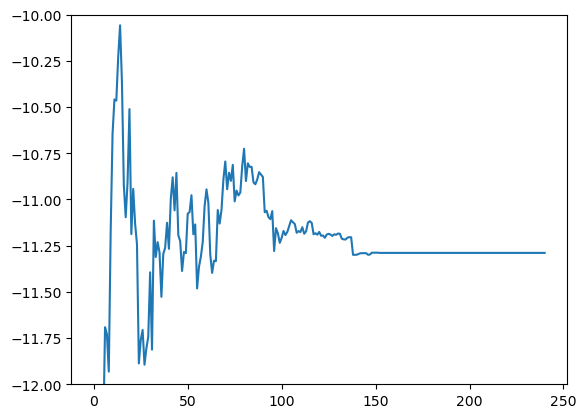

In [463]:
# print best score from rfecv
plt.plot(np.mean(np.array(rfecv.grid_scores_), axis=1))
# ylim -13 to -10
plt.ylim(-12, -10)


In [468]:
# use bayessearchcv to find the best parameters for xgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# define the search space
search_spaces = {
    "learning_rate": Real(0.01, 1.0, "log-uniform"),
    "max_depth": Integer(2, 50),
    "min_child_weight": Integer(1, 30),
    "subsample": Real(0.01, 1.0, "uniform"),
    "colsample_bytree": Real(0.01, 1.0, "uniform"),
    "n_estimators": Integer(10, 1000),
    "reg_alpha": Real(1e-9, 1000, "log-uniform"),
    "reg_lambda": Real(1e-9, 1000, "log-uniform"),
    "gamma": Real(1e-9, 0.5, "log-uniform"),
}

# instantiate bayessearchcv with xgb
xgb_bayes = BayesSearchCV(xgb, search_spaces, n_iter=40, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0, random_state=42)
# fit bayessearchcv
xgb_bayes.fit(df_train[best_features_rfecv], df_train[target])
# print out the best parameters
print(xgb_bayes.best_params_)
# print out the best score
print(xgb_bayes.best_score_)
# print out the best estimator
print(xgb_bayes.best_estimator_)
# save the params in a variable
xgb_bayes_params = xgb_bayes.best_params_

OrderedDict([('colsample_bytree', 0.48428708972313583), ('gamma', 0.09406022341868904), ('learning_rate', 0.017349111862338444), ('max_depth', 23), ('min_child_weight', 6), ('n_estimators', 486), ('reg_alpha', 5.2775666540454204e-08), ('reg_lambda', 3.9519712488416117), ('subsample', 0.5611931829825653)])
-9.571390912455898
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.48428708972313583, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.09406022341868904, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.017349111862338444, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=23, max_leaves=0,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=486, n_jobs=0, num_parallel_tree=1, predi

In [372]:
# do bayessearchcv with random forest
# define the search space
search_spaces = {
    "max_depth": Integer(2, 30),
    "min_samples_split": Integer(2, 30),
    "min_samples_leaf": Integer(1, 30),
    "max_features": Integer(1, 30),
    "n_estimators": Integer(10, 1000),
    #"bootstrap": Categorical([True, False]),
    "criterion": Categorical(["mse", "mae"]),
    "max_samples": Real(0.01, 1.0, "uniform"),
    "max_leaf_nodes": Integer(2, 30),
    "min_weight_fraction_leaf": Real(0.01, 0.5, "uniform"),
    "min_impurity_decrease": Real(1e-9, 1.0, "log-uniform"),
    #"min_impurity_split": Real(1e-9, 1.0, "log-uniform"),
}

# instantiate bayessearchcv with random forest
rf_bayes = BayesSearchCV(rf, search_spaces, n_iter=20, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0, random_state=42)
# fit bayessearchcv
rf_bayes.fit(df_train[best_features_rfecv], df_train[target])
# print out the best parameters
print(rf_bayes.best_params_)
# print out the best score
print(rf_bayes.best_score_)


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\ensemble\_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


OrderedDict([('criterion', 'mse'), ('max_depth', 30), ('max_features', 6), ('max_leaf_nodes', 27), ('min_impurity_decrease', 7.695476378743132e-06), ('min_samples_leaf', 1), ('min_samples_split', 22), ('min_weight_fraction_leaf', 0.01020721394871926), ('n_estimators', 498)])
-10.171987814864348


In [373]:
# instantiate lgmb with default params
lgbm = LGBMRegressor(random_state=42)
# do cross validate with the best params and best features from rfecv
cv_score_xgb_bayes = cross_validate(xgb_bayes.best_estimator_, df_train[best_features_rfecv], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# do cross vaidate with default params and best features from rfecv
cv_score_xgb_rfecv = cross_validate(xgb, df_train[best_features_rfecv], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# do cross validate with default params and best features from rfecv on random forest
cv_score_rf_rfecv = cross_validate(rf, df_train[best_features_rfecv], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# do cross validate with default params and best features from rfecv on lgbm
cv_score_lgbm_rfecv = cross_validate(lgbm, df_train[best_features_rfecv], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# compute the mean of the scores for the models and save them in a dataframe
cv_score_xgb_bayes_mean = pd.DataFrame(cv_score_xgb_bayes).mean()
cv_score_xgb_rfecv_mean = pd.DataFrame(cv_score_xgb_rfecv).mean()
cv_score_rf_rfecv_mean = pd.DataFrame(cv_score_rf_rfecv).mean()
cv_score_lgbm_rfecv_mean = pd.DataFrame(cv_score_lgbm_rfecv).mean()

# concatenate the dataframes
cv_score = pd.concat([cv_score_xgb_bayes_mean, cv_score_xgb_rfecv_mean, cv_score_rf_rfecv_mean, cv_score_lgbm_rfecv_mean], axis=1)
# rename the columns
cv_score.columns = ["xgb_bayes", "xgb_rfecv", "rf_rfecv", "lgbm_rfecv"]
cv_score = cv_score.T
cv_score = cv_score.abs()
# print out the dataframe
display(cv_score)

fit_time  score_time   test_r2  test_neg_mean_absolute_error  \
xgb_bayes   0.352457    0.007978  0.134983                      9.322429   
xgb_rfecv   0.103125    0.007181  0.069521                      9.949548   
rf_rfecv    0.199677    0.010165  0.015205                     10.361006   
lgbm_rfecv  0.038891    0.003992  0.097087                     10.608412   

            test_neg_root_mean_squared_error  
xgb_bayes                          12.057216  
xgb_rfecv                          12.329522  
rf_rfecv                           12.824425  
lgbm_rfecv                         13.161789

In [345]:
# get cv score for mae using xgboost and mae
cv_score_xgb_bayes = cross_validate(xgb, df_train[best_features_rfecv], df_train[target], cv=5, scoring=["r2", "neg_mean_absolute_error", "neg_root_mean_squared_error"])
# print the mean
print(pd.DataFrame(cv_score_xgb_bayes).mean())


fit_time                             0.174695
score_time                           0.008776
test_r2                              0.069521
test_neg_mean_absolute_error        -9.949548
test_neg_root_mean_squared_error   -12.329522
dtype: float64


## Monte Carlo stuff

In [394]:
print(xgb_bayes.best_params_)

OrderedDict([('learning_rate', 0.07756486208064789), ('max_depth', 46)])


In [470]:
# instantiate xgboost with the best params variable
xgb = XGBRegressor(**xgb_bayes_params, random_state=42)

# fit xgboost
xgb.fit(df_train[best_features_rfecv], df_train[target])



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.48428708972313583, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=0.09406022341868904, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.017349111862338444, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=23, max_leaves=0,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=486, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=5.2775666540454204e-08,
             reg_lambda=3.9519712488416117, ...)

In [471]:
# show the feature importance in a dataframe
feature_importance = pd.DataFrame(zip(xgb.feature_importances_, best_features_rfecv), columns=["importance", "feature"]).sort_values("importance", ascending=False)
# print out the dataframe
display(feature_importance)


importance                             feature
13    0.087639  mean_watts_missing_rolling_mean_90
7     0.085363            elev_gain_rolling_mean_7
5     0.081251              mean_hr_rolling_max_90
10    0.080404       average_speed_rolling_mean_60
0     0.079350                             mean_hr
6     0.078633          mean_watts_rolling_mean_30
4     0.072573             mean_hr_rolling_mean_30
11    0.064834        average_speed_rolling_max_60
1     0.060844              max_hr_rolling_mean_30
9     0.059560        average_speed_rolling_max_30
8     0.058046       average_speed_rolling_mean_30
2     0.056021               mean_hr_rolling_max_7
14    0.052802           days_since_rolling_std_60
3     0.046200              mean_hr_rolling_std_14
12    0.036480       max_hr_missing_rolling_mean_7

In [407]:
#sort best_features_rfecv
best_features_rfecv.sort_values()

Index(['average_speed_rolling_max_14', 'average_speed_rolling_max_60',
       'average_speed_rolling_mean_60', 'days_since_rolling_std_60',
       'distance_rolling_max_30', 'elev_gain', 'elev_gain_rolling_mean_7',
       'elev_gain_rolling_std_90', 'max_hr_rolling_max_7',
       'max_hr_rolling_mean_30', 'mean_hr', 'mean_hr_rolling_mean_30',
       'mean_watts_missing_rolling_mean_30', 'mean_watts_rolling_mean_30',
       'mean_watts_rolling_std_30', 'suffer_score_rolling_mean_90',
       'suffer_score_rolling_std_14', 'year'],
      dtype='object')

In [389]:
df_train[best_features_rfecv].shape

(155, 18)

In [396]:
# import the interact function from ipywidgets
from ipywidgets import interact

# create a dataframe with the mean values of the features
df = pd.DataFrame(df_train[best_features_rfecv].mean()).T

# create a slider to control the feature value mean_hr to see the output of the xgb model
@interact(feature_mean_hr=(df_train["mean_hr"].min(), df_train["mean_hr"].max(), 1))
def plot_xgb(feature_mean_hr):
    global df
    print(df.shape)
    # change the value of the feature mean_hr
    df["mean_hr"] = feature_mean_hr
    # predict the target value
    pred = xgb.predict(df)
    # print the predicted value
    print(pred)




interactive(children=(FloatSlider(value=105.9, description='feature_mean_hr', max=157.3, min=55.9, step=1.0), …

In [417]:
import pygad

In [491]:
list(mean_values)

[142.28227403826807,
 75.77974436098651,
 147.03896023715782,
 68.26907993901808,
 64.80477273486736,
 159.28451612903228,
 78.67139011160911,
 41.070783410138255,
 2.6168150537634407,
 8.486774193548387,
 2.401847311827957,
 8.651483870967741,
 0.06635944700460829,
 0.16157706093189964,
 1.9697994709280429]

In [496]:
# get the min and max values of the features
min_values = df_train[best_features_rfecv].min().values
max_values = df_train[best_features_rfecv].max().values
mean_values = df_train[best_features_rfecv].mean().values

# use scipy.optimize to maximize the xbg trained model
def objective(x):
    return -xgb.predict(x.reshape(1, -1))[0]

# import scipy.optimize
import scipy.optimize

# use scipy.optimize to maximize the xbg trained model
# result = scipy.optimize.differential_evolution(
#    objective,
#    bounds=list(zip(min_values, max_values)),
#    maxiter=1000, popsize=10, tol=0.01, mutation=(0.5, 1), recombination=0.7, seed=42)

result_an = scipy.optimize.dual_annealing(
    objective,
    x0=list(mean_values),
    bounds=list(zip(min_values, max_values)),
    )

# use shgo to maximize the xbg trained model with the best features from rfecv
result_shgo = scipy.optimize.shgo(
    objective,
    bounds=list(zip(min_values, max_values)),
    n=100,
    iters=100,
    sampling_method="sobol",
    minimizer_kwargs={"method": "Nelder-Mead"},
    options={"ftol": 1e-6, "maxev": 1000},
    )

# use basinhopping to maximize the xbg trained model with the best features from rfecv
result_basinhopping = scipy.optimize.basinhopping(
    objective,
    x0=list(mean_values),
    niter=100,
    T=1.0,
    stepsize=0.5,
    minimizer_kwargs={"method": "Nelder-Mead"},
    take_step=None,
    accept_test=None,
    callback=None,
    interval=50,
    bounds=list(zip(min_values, max_values)),
)

# use direct to maximize the xbg trained model with the best features from rfecv
result_direct = scipy.optimize.differential_evolution(
    objective,
    bounds=list(zip(min_values, max_values)),
    maxiter=1000,
    popsize=10,
    tol=0.01,
)



In [477]:
result

     fun: -221.22279357910156
 message: 'Optimization terminated successfully.'
    nfev: 2116
     nit: 13
 success: True
       x: array([146.38029917,  83.00593655, 142.75672707,  39.55732732,
        75.48684755, 163.88568019, 144.97772231,  94.43392362,
         3.69802457,   6.88814701,   3.22267587,   8.86107837,
         0.3095204 ,   0.20898149,   1.22186755])

In [478]:
pd.DataFrame(result.x.reshape(1, -1), columns=df_train[best_features_rfecv].columns)


mean_hr  max_hr_rolling_mean_30  mean_hr_rolling_max_7  \
0  146.380299               83.005937             142.756727   

   mean_hr_rolling_std_14  mean_hr_rolling_mean_30  mean_hr_rolling_max_90  \
0               39.557327                75.486848               163.88568   

   mean_watts_rolling_mean_30  elev_gain_rolling_mean_7  \
0                  144.977722                 94.433924   

   average_speed_rolling_mean_30  average_speed_rolling_max_30  \
0                       3.698025                      6.888147   

   average_speed_rolling_mean_60  average_speed_rolling_max_60  \
0                       3.222676                      8.861078   

   max_hr_missing_rolling_mean_7  mean_watts_missing_rolling_mean_90  \
0                        0.30952                            0.208981   

   days_since_rolling_std_60  
0                   1.221868

In [476]:
# print out the best score
print(fm_.fun)

167.8114138290602


In [256]:
param_names = [x.name for x in param_grid]

print(*zip(param_names, fm_.x))


('learning_rate', 0.07387704451955576) ('n_estimators', 230) ('num_leaves', 123) ('max_depth', 14) ('min_child_samples', 23) ('subsample', 0.7251575462995903) ('colsample_bytree', 0.21725820880051241) ('reg_alpha', 19.926260432354596) ('reg_lambda', 0.12661163335733894) ('min_split_gain', 5.549854479936795e-09) ('min_child_weight', 3.3768608925928023e-07) ('subsample_freq', 10) ('max_bin', 486) ('cat_smooth', 10) ('cat_l2', 61)


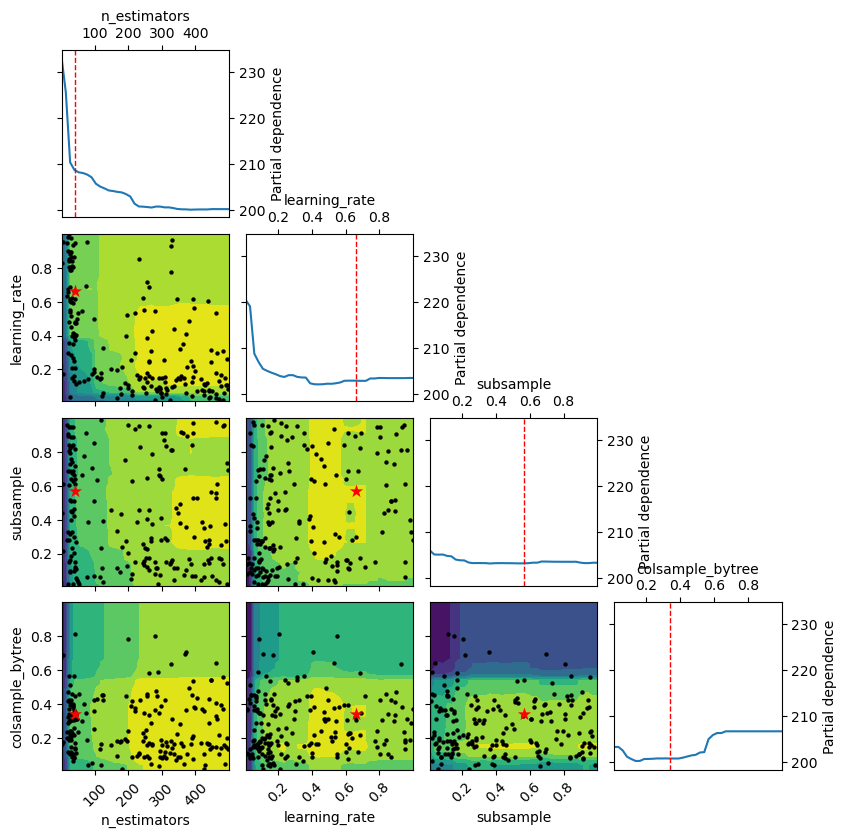

In [230]:
# plot the top 10 features
dim_names = ["n_estimators", "learning_rate", "subsample", "colsample_bytree"]
plot_objective(fm_, plot_dims=dim_names, )
plt.show()

In [221]:
# print out the name and the value of the best parameters
#for name, value in zip(fm_.x, fm_.fun):
#    print(f"{name}: {value}")

print(fm_.fun)



164.4437707185446


In [219]:
np.sqrt(fm_.fun)

12.975252982206872

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

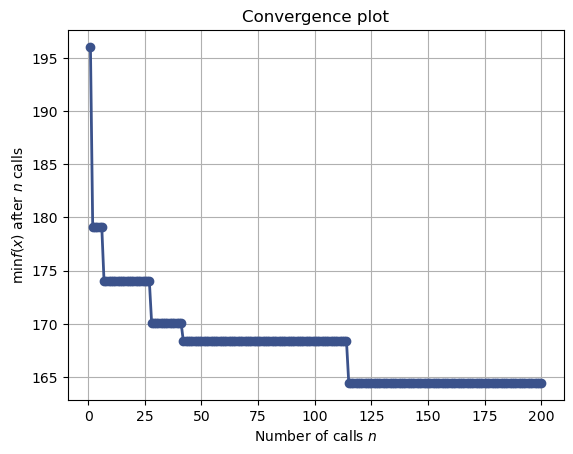

In [223]:
# import plot_convergence
from skopt.plots import plot_convergence

# plot the convergence
plot_convergence(fm_)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

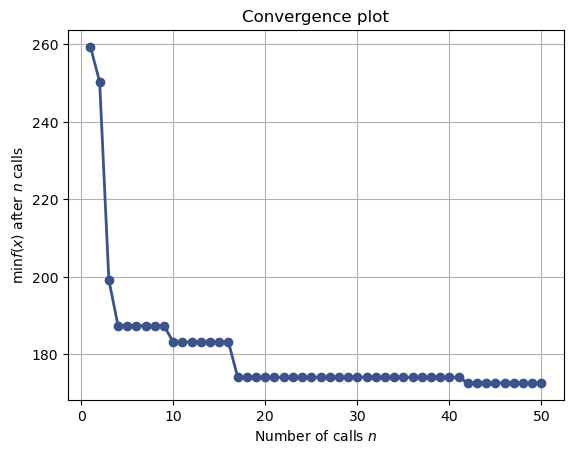

In [203]:
# import plot_convergence
from skopt.plots import plot_convergence

# plot the convergence
plot_convergence(fm_)

In [ ]:
# from fm_ find out which parameters where most influential
for i in range(len(fm_.x)):
    print(f"{param_names[i]}: {fm_.x[i]}")
    

In [ ]:

# import plot_objective
from skopt.plots import plot_objective

# plot the objective
plot_objective(fm_, )
# import plot_evaluations
from skopt.plots import plot_evaluations

# plot the evaluations
plot_evaluations(fm_)
# import plot_objective_2D
from skopt.plots import plot_objective_2D

# plot the objective 2D
plot_objective_2D(fm_, "n_estimators", "max_depth")



In [12]:
target = "mean_watts"

df_train2 = df_train.copy()

df_train2.dropna(subset=[target, "activity_id"], inplace=True)

df_train2.reset_index(drop=True, inplace=True)

y = df_train2[target]
X = df_train2.drop(target, axis=1)

# do cvgrid search for best params for knnregressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
# import lasso
from sklearn.linear_model import Lasso
# import svr
from sklearn.svm import SVR
# lightgbm regressor
from lightgbm import LGBMRegressor

param_grid = {
    "n_neighbors": [3, 7, 11, 15, 19, 25],
    "weights": ["uniform", "distance"],
    "algorithm": ["auto"],#, "ball_tree", "kd_tree", "brute"],
    "leaf_size": [10, 30, 50, 70, 100],
    "p": [1, 2],
    "metric": ["minkowski", "euclidean", "manhattan", "chebyshev", "haversine", "seuclidean", "mahalanobis"]
}
# param grid for lasso
param_grid = {
    "alpha": [0.0001, 0.01, 1, 10, 100, 1000],
    "fit_intercept": [True, False],
    "normalize": [True, False],
    "precompute": [True, False],
    "copy_X": [True, False],
    #"max_iter": [100, 1000, 10000, 100000],
    #"tol": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "warm_start": [True, False],
    "positive": [True, False],
    "selection": ["cyclic", "random"]
}
# param grid for svr
param_grid = {
    "kernel": ["linear", "poly", "rbf"],
    #"degree": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"gamma": ["scale", "auto"],
    #"coef0": [0.0, 0.2, 0.4, 0.6, 0.8, 1.0], 
    #"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "epsilon": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}
# param grid of lightgbm
param_grid = {
    "boosting_type": ["gbdt", "dart", "goss", "rf"],
    "num_leaves": [10, 30, 50, 70, 100],
    #"max_depth": [3, 5, 7, 10],
    #"learning_rate": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    #"n_estimators": [10, 100, 1000, 10000],#, 100000],
    #"subsample_for_bin": [200000, 400000, 600000, 800000, 1000000],
    #"min_child_samples": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    #"reg_alpha": [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    #"reg_lambda": [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
    #"colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    #"subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    #"subsample_freq": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    "n_jobs": [-1],
    "random_state": [42]
}

model = KNeighborsRegressor()
model = Lasso()
model = SVR()
model = LGBMRegressor()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X, y)

print(grid_search.best_params_)

# print best score
#print(np.sqrt(-grid_search.best_score_))
# print best r2_score
#print(grid_search.score(X, y))


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\lightgbm\sklearn.py", line 818, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\lightgbm\sklearn.py", line 683, in fit
    sel

{'boosting_type': 'goss', 'n_jobs': -1, 'num_leaves': 10, 'random_state': 42}


In [75]:
# import standard scaler
from sklearn.preprocessing import StandardScaler
# import linear regression
from sklearn.linear_model import LinearRegression
# import knn regressor
from sklearn.neighbors import KNeighborsRegressor
# import gridsearch cv
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
# import ridge regression
from sklearn.linear_model import Ridge
# import lasso regression
from sklearn.linear_model import Lasso

# import svr
from sklearn.svm import SVR
 
 
target = "mean_watts"

df_train2 = df_train.copy()

df_train2.dropna(subset=[target, "activity_id"], inplace=True)

df_train2.reset_index(drop=True, inplace=True)

y = df_train2[target]
X = df_train2.drop(target, axis=1)

# do leave one out cross validation
# split data into train and test
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
loo.get_n_splits(X)

# list with rmse and r2 for train_index
rmse_train = []
r2_train = []
mae_train = []


for fold, (train_index, test_index) in enumerate(loo.split(X)):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    do_scaling = True
    do_pca = True
    do_param_opt = True
    # do std scaling
    if do_scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    if do_pca:
        pca = PCA(n_components=0.95)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)


    # instantiate lgbm regressor
    model = LGBMRegressor(random_state=42)
    model = SVR()
    #model = LinearRegression()
    #model = KNeighborsRegressor(n_neighbors=11, weights="distance")
    # knn best params
    knn_params = {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
    #model = KNeighborsRegressor(**knn_params)
    # do ridge regression
    model = Ridge()
    # do lasso regression
    model = Lasso()
    if do_param_opt:
        params = {'alpha': 10, 'copy_X': False, 'fit_intercept': False, 'normalize': False, 'positive': True, 'precompute': True, 'selection': 'random', 'warm_start': True}
        model = Lasso(**params)


    # fit model regressor to training data
    model.fit(X_train, y_train)

    # make predictions on test data
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    # save predictions to dataframe
    df_train2.loc[test_index, "pred_test"] = y_pred_test

    # save rmse and r2 for train_index
    rmse_train.append(np.sqrt(mean_squared_error(y_train, y_pred_train)))
    r2_train.append(r2_score(y_train, y_pred_train))
    mae_train.append(mean_absolute_error(y_train, y_pred_train))


# compute test rmse and r2 and mae variables
rmse_test = np.sqrt(mean_squared_error(df_train2[target], df_train2["pred_test"]))
r2_test = r2_score(df_train2[target], df_train2["pred_test"])
mae_test = mean_absolute_error(df_train2[target], df_train2["pred_test"])
# compute train rmse and r2 and mae variables
rmse_train = np.mean(rmse_train)
r2_train = np.mean(r2_train)
mae_train = np.mean(mae_train)


# use all metrics to evaluate predictions on both train and test data
print(f"Train RMSE:, {rmse_train:.2f}")
print(f"Test RMSE:, {rmse_test:.2f}")
print(f"Train MAE:, {mae_train:.2f}")
print(f"Test MAE:, {mae_test:.2f}")
print(f"Train R2:, {r2_train:.2f}")
print(f"Test R2:, {r2_test:.2f}")

# get the name of the model
model_name = model.__class__.__name__

# save the model name and scores in a dataframe
model_scores_temp = pd.DataFrame({"model": model_name, "rmse_train": rmse_train, "rmse_test": rmse_test, "r2_train": r2_train, "r2_test": r2_test, "mae_train": mae_train, "mae_test": mae_test, "do_scaling": do_scaling, "do_pca":do_pca, "do_param_opt":do_param_opt}, index=[0])
# cretae dataframe if it doesnt exist
try:
    model_scores = pd.concat([model_scores, model_scores_temp])
except:
    model_scores = model_scores_temp

# create dataframe with feature importance
#feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lgbm.feature_importances_})
# sort dataframe by feature importance
#feature_importance = feature_importance.sort_values("importance", ascending=False)


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in versi

Train RMSE:, 196.32
Test RMSE:, 196.44
Train MAE:, 195.67
Test MAE:, 195.80
Train R2:, -150.04
Test R2:, -150.21


c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
c:\Users\jerke\Anaconda3\envs\strava\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in versi

In [76]:
model_scores

model    rmse_train   rmse_test    r2_train     r2_test  \
0  KNeighborsRegressor  1.333294e+01   13.815342    0.303346    0.252078   
0  KNeighborsRegressor  1.342769e+01   14.041265    0.293403    0.227417   
0  KNeighborsRegressor  1.321664e+01   13.847798    0.315444    0.248560   
0     LinearRegression  4.715203e-06   98.863544    1.000000  -37.300573   
0     LinearRegression  4.631453e-13  102.589506    1.000000  -40.241913   
0     LinearRegression  1.085309e+01   14.413592    0.538371    0.185901   
0        LGBMRegressor  3.337085e+00   13.965730    0.956308    0.235706   
0        LGBMRegressor  3.287211e+00   13.979486    0.957603    0.234200   
0                Ridge  1.210561e+01   15.276289    0.403957    0.085532   
0                Ridge  6.087831e+00   21.322191    0.854727   -0.781544   
0                Ridge  1.085314e+01   14.400838    0.538367    0.187341   
0                Lasso  1.127256e+01   13.747309    0.502001    0.259426   
0                Lasso  1.115168e+01   12.769060    0.512632    0.361074   
0                Lasso  7.537664e+00   17.961875    0.777309   -0.264260   
0                Lasso  1.172352e+01   13.072088    0.461375    0.330389   
0                Lasso  1.172388e+01   13.019424    0.461340    0.335773   
0                Lasso  1.963181e+02  196.318121 -150.044470 -150.026688   
0                Lasso  1.963174e+02  196.439101 -150.043463 -150.212884   

      mae_train    mae_test  do_scaling  do_pca do_param_opt  
0  1.030794e+01   10.699716        True   False          NaN  
0  1.040243e+01   10.965729        True    True          NaN  
0  1.022905e+01   10.747252       False   False          NaN  
0  3.474281e-06   56.974167       False   False          NaN  
0  3.518970e-13   57.017146        True   False          NaN  
0  7.971819e+00   10.266158        True    True          NaN  
0  2.262783e+00    9.937787       False   False          NaN  
0  2.259253e+00    9.940000        True   False          NaN  
0  9.141730e+00   11.376018       False   False          NaN  
0  4.447942e+00   14.434586        True   False          NaN  
0  7.971848e+00   10.259658        True    True          NaN  
0  8.296008e+00    9.969563        True    True          NaN  
0  8.454223e+00    9.678076        True   False          NaN  
0  5.431449e+00   12.645771       False   False          NaN  
0  9.119634e+00   10.181029       False   False          NaN  
0  9.120105e+00   10.135840       False   False         True  
0  1.956671e+02  195.667097        True   False         True  
0  1.956671e+02  195.800809        True    True         True

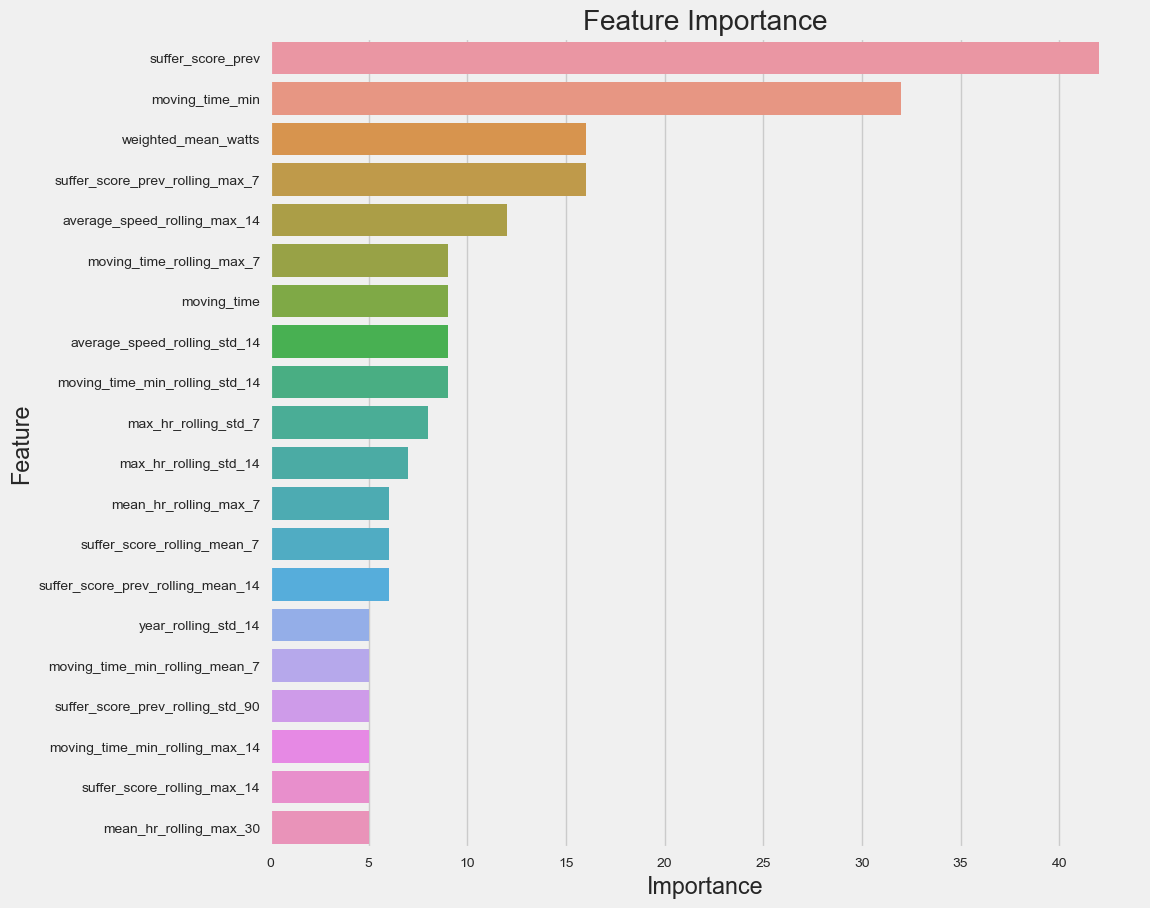

In [ ]:
# make bar plot of feature importance with title and axis labels 
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importance[:20])
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


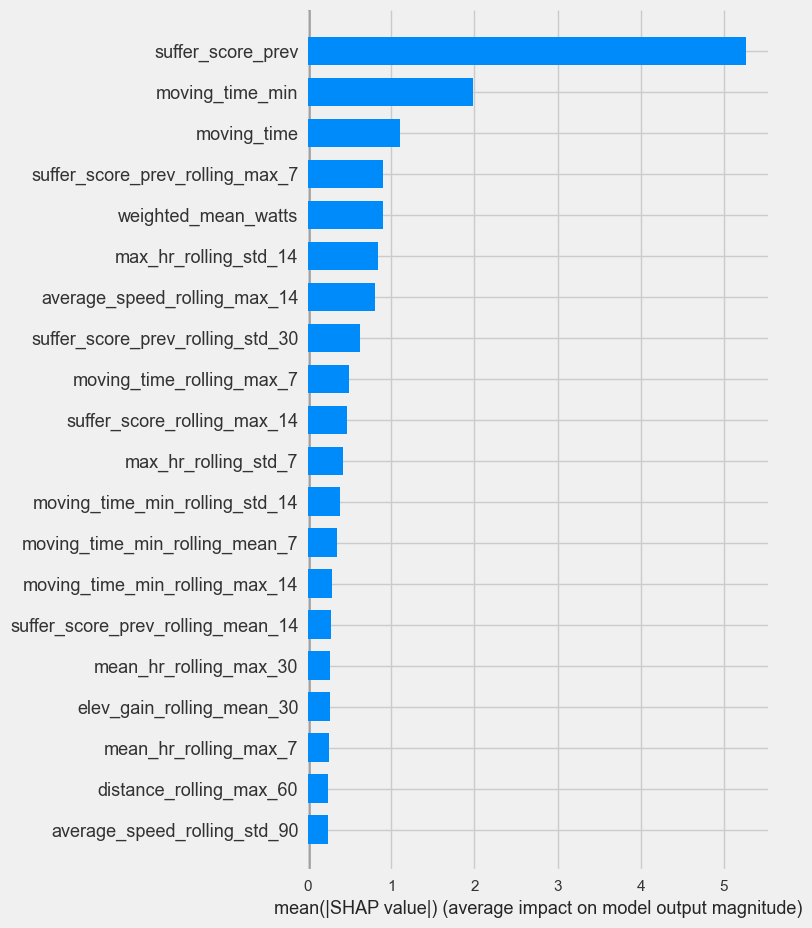

In [ ]:
# import shap library for shap values and summary plots 
import shap

# create shap explainer object
explainer = shap.TreeExplainer(lgbm)

# calculate shap values for test data
shap_values = explainer.shap_values(X_test)

# create shap summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
# activate javascript for shapley force plot
shap.initjs()

In [ ]:
# create shapley force plot for the first row in the test data
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)


In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


In [ ]:
cond = df_train.activity_id == 8096588246
df_train[cond]

activity_id  mean_hr  calories   moving_time  elapsed_time  \
3435  8.096588e+09    141.1       0.0  2.791000e+12  2.791000e+12   

      weighted_mean_watts  elev_gain  year  hour  moving_time_min  \
3435                221.0        0.0  2022  12.0        51.716667   

      elapsed_time_min  suffer_score_missing  calories_missing  days_since  \
3435         46.516667                   0.0               1.0         2.0   

      suffer_score_prev  suffer_score_rolling_mean_7  \
3435               60.0                         29.0   

      suffer_score_rolling_std_7  suffer_score_rolling_max_7  \
3435                   36.373067                        72.0   

      suffer_score_rolling_mean_14  suffer_score_rolling_std_14  \
3435                     33.214286                    41.346898   

      suffer_score_rolling_max_14  suffer_score_rolling_mean_30  \
3435                        119.0                     33.233333   

      suffer_score_rolling_std_30  suffer_score_rolling_max_30  \
3435                    38.551965                        119.0   

      suffer_score_rolling_mean_60  suffer_score_rolling_std_60  \
3435                     27.766667                    39.750649   

      suffer_score_rolling_max_60  suffer_score_rolling_mean_90  \
3435                        120.0                     34.711111   

      suffer_score_rolling_std_90  suffer_score_rolling_max_90  \
3435                    47.515638                        172.0   

      max_hr_rolling_mean_7  max_hr_rolling_std_7  max_hr_rolling_max_7  \
3435              72.714286             90.694936                 171.0   

      max_hr_rolling_mean_14  max_hr_rolling_std_14  max_hr_rolling_max_14  \
3435               93.071429              84.347691                  176.0   

      max_hr_rolling_mean_30  max_hr_rolling_std_30  max_hr_rolling_max_30  \
3435                    87.9              83.978795                  176.0   

      max_hr_rolling_mean_60  max_hr_rolling_std_60  max_hr_rolling_max_60  \
3435               66.766667               82.66378                  176.0   

      max_hr_rolling_mean_90  max_hr_rolling_std_90  max_hr_rolling_max_90  \
3435                    71.2              83.919598                  183.0   

      mean_hr_rolling_mean_7  mean_hr_rolling_std_7  mean_hr_rolling_max_7  \
3435               61.442857              76.720572                  149.9   

      mean_hr_rolling_mean_14  mean_hr_rolling_std_14  mean_hr_rolling_max_14  \
3435                76.628571               69.830877                   151.7   

      mean_hr_rolling_mean_30  mean_hr_rolling_std_30  mean_hr_rolling_max_30  \
3435                73.596667               70.612261                   151.7   

      mean_hr_rolling_mean_60  mean_hr_rolling_std_60  mean_hr_rolling_max_60  \
3435                55.853333               69.364858                   151.7   

      mean_hr_rolling_mean_90  mean_hr_rolling_std_90  mean_hr_rolling_max_90  \
3435                59.861111               70.729735                   155.8   

      mean_watts_rolling_mean_7  mean_watts_rolling_std_7  \
3435                        NaN                       NaN   

      mean_watts_rolling_max_7  mean_watts_rolling_mean_14  \
3435                       NaN                         NaN   

      mean_watts_rolling_std_14  mean_watts_rolling_max_14  \
3435                        NaN                        NaN   

      mean_watts_rolling_mean_30  mean_watts_rolling_std_30  \
3435                         NaN                        NaN   

      mean_watts_rolling_max_30  mean_watts_rolling_mean_60  \
3435                        NaN                         NaN   

      mean_watts_rolling_std_60  mean_watts_rolling_max_60  \
3435                        NaN                        NaN   

      mean_watts_rolling_mean_90  mean_watts_rolling_std_90  \
3435                         NaN                        NaN   

      mean_watts_rolling_max_90  calories_rolling_mean_7 

In [ ]:
shap_values2 = explainer.shap_values(df_train[cond].drop(columns=[target, "activity_id"], axis=1))
shap.force_plot(explainer.expected_value, shap_values2[0,:], df_train2[cond].drop(columns=[target, "activity_id"], axis=1).iloc[0,:])

LightGBMError: The number of features in data (299) is not the same as it was in training data (300).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [ ]:
df.head(10)

activity_id  suffer_score  max_hr  mean_hr  mean_watts calories  \
0   8138190331          45.0   166.0    134.5       142.6     None   
1   8133847455          11.0   142.0    102.2         NaN     None   
2   8119878838          20.0   159.0    110.8         NaN     None   
3   8112713879          74.0   168.0    146.1       177.2     None   
4   8106924057         117.0   167.0    144.9       173.5     None   
5   8096588246          86.0   169.0    150.4       199.4     None   
6   8085387433          60.0   170.0    141.1         NaN     None   
7   8075411412          71.0   170.0    137.2       168.4     None   
8   8061003811          72.0   168.0    143.0         NaN     None   
9   8053377434          93.0   171.0    149.9       184.6     None   

     moving_time   elapsed_time     type                 start_date  \
0  2820000000000  2989000000000     Ride  2022-11-19 08:51:34+00:00   
1  3486000000000  3486000000000  Workout  2022-11-18 05:32:00+00:00   
2  3132000000000  3132000000000  Workout  2022-11-15 05:20:45+00:00   
3  2787000000000  2925000000000     Ride  2022-11-13 14:20:28+00:00   
4  4682000000000  5496000000000     Ride  2022-11-12 13:10:59+00:00   
5  2791000000000  2791000000000     Ride  2022-11-10 12:01:13+00:00   
6  3103000000000  3103000000000  Workout  2022-11-08 05:20:55+00:00   
7  3436000000000  3436000000000     Ride  2022-11-06 07:15:17+00:00   
8  3292000000000  3292000000000  Workout  2022-11-03 05:24:29+00:00   
9  2992000000000  2992000000000     Ride  2022-11-01 15:23:48+00:00   

                                       name  weighted_mean_watts  elev_gain  \
0                             Morning Ride                   NaN      146.8   
1                               MMA Fitness                  NaN        0.0   
2                              MMA Fitness                   NaN        0.0   
3                           Afternoon Ride                   NaN      334.0   
4                            Afternoon Ride                  NaN      344.0   
5   Wahoo SYSTM: Revolver is Easy (Mash-Up)                221.0        0.0   
6                              MMA Fitness                   NaN        0.0   
7                Wahoo SYSTM: 14 Vise Grips                201.0        0.0   
8                               MMA Fitness                  NaN        0.0   
9  Wahoo SYSTM: Tasmania: Cygnet Coast Road                201.0        0.0   

   kilojoules  average_speed  distance  year        date  hour  \
0       402.2           3.82   10767.3  2022  2022-11-19     8   
1         NaN           0.00       0.0  2022  2022-11-18     5   
2         NaN           0.00       0.0  2022  2022-11-15     5   
3       493.9           3.16    8811.4  2022  2022-11-13    14   
4       812.6           4.83   22633.4  2022  2022-11-12    13   
5       556.6           8.22   22936.0  2022  2022-11-10    12   
6         NaN           0.00       0.0  2022  2022-11-08     5   
7       578.8           7.69   26430.0  2022  2022-11-06     7   
8         NaN           0.00       0.0  2022  2022-11-03     5   
9       552.4           8.29   24796.4  2022  2022-11-01    15   

   moving_time_min  elapsed_time_min  
0        47.000000         49.816667  
1        58.100000         58.100000  
2        52.200000         52.200000  
3        46.450000         48.750000  
4        78.033333         91.600000  
5        46.516667         46.516667  
6        51.716667         51.716667  
7        57.266667         57.266667  
8        54.866667         54.866667  
9        49.866667         49.866667

## Linear Regression

In [ ]:
# creaate new dataframe with any columns with missing removed
df_train_lr = df_train2.dropna(axis=1)

In [ ]:
# import linear regression
from sklearn.linear_model import LinearRegression

# make train_test_split with random_state=42 and test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(df_train_lr.drop(target, axis=1), df_train_lr[target], test_size=0.2, random_state=42)

# instantiate linear regression
lr = LinearRegression()

# fit linear regression to training data
lr.fit(X_train, y_train)

# make predictions on test data
y_pred = lr.predict(X_test)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lr.predict(X_train)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lr.predict(X_train)))
print("Test R2:", r2_score(y_test, y_pred))

# create dataframe with feature importance
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lr.coef_})
# sort dataframe by feature importance
feature_importance = feature_importance.sort_values("importance", ascending=False)


Train RMSE: 0.4275648743537994
Test RMSE: 25.17358400443622
Train MAE: 0.34566963191593797
Test MAE: 17.95906277041877
Train R2: 0.9985940718442259
Test R2: -5.4261587287360085


In [ ]:
# scale X_train and X_test using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# fit linear regression to training data
lr.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = lr.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lr.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lr.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.886858052997495e-14
Test RMSE: 16.316609105840705
Train MAE: 6.445637674395194e-14
Test MAE: 12.38398745520591
Train R2: 1.0
Test R2: -1.6997351745517584


In [ ]:
# use ridge regression to fit linear regression to training data
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = ridge.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, ridge.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, ridge.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 2.82989249593071
Test RMSE: 14.284805327169385
Train MAE: 1.9688999417454798
Test MAE: 8.430240209500585
Train R2: 0.9384115939396018
Test R2: -1.0692358720312156


In [ ]:
# use lasso regression to fit linear regression to training data
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = lasso.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, lasso.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, lasso.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.12288830829579
Test RMSE: 8.161153858395226
Train MAE: 5.842370333231832
Test MAE: 5.435826774795083
Train R2: 0.4925654281728261
Test R2: 0.3245946798670575


In [ ]:
np.logspace(-5,5, 11)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])

In [ ]:
# plot and calculate the coefficients for the diffferent features for different values of alpha in lasso regression 
lasso = Lasso()
coefs = []
for a in np.logspace(-5,2, 11):
    lasso.set_params(alpha=a)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)

# plot the coefficients for the different features for different values of alpha in lasso regression with plotly in log scale
import plotly.graph_objects as go

fig = go.Figure()
for i in range(len(coefs[0])):
    fig.add_trace(go.Scatter(x=np.logspace(-5,2, 11), y=[coef[i] for coef in coefs], name=X_train.columns[i]))
fig.update_traces(hovertemplate="%{y:.2f}")
fig.update_layout(title="Lasso Regression Coefficients", xaxis_title="Alpha", yaxis_title="Coefficient", xaxis_type="log")
fig.show()


# plot and calculate the coefficients for the diffferent features for different values of alpha in ridge regression 
ridge = Ridge()
coefs = []
for a in np.logspace(-5,2, 11):
    ridge.set_params(alpha=a)
    ridge.fit(X_train_scaled, y_train)
    coefs.append(ridge.coef_)


fig = go.Figure()
for i in range(len(coefs[0])):
    fig.add_trace(go.Scatter(x=np.logspace(-5,2, 11), y=[coef[i] for coef in coefs], name=X_train.columns[i]))
# plot the full name of the coefficient when hovering over the plot
fig.update_traces(hovertemplate="%{y:.2f}")
fig.update_layout(title="Ridge Regression Coefficients", xaxis_title="Alpha", yaxis_title="Coefficient", xaxis_type="log")
fig.show()


Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.578e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.837e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.015e+01, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.094e+02, tolerance: 1.456e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e+02, tolerance: 1.456e+00
Objective did n

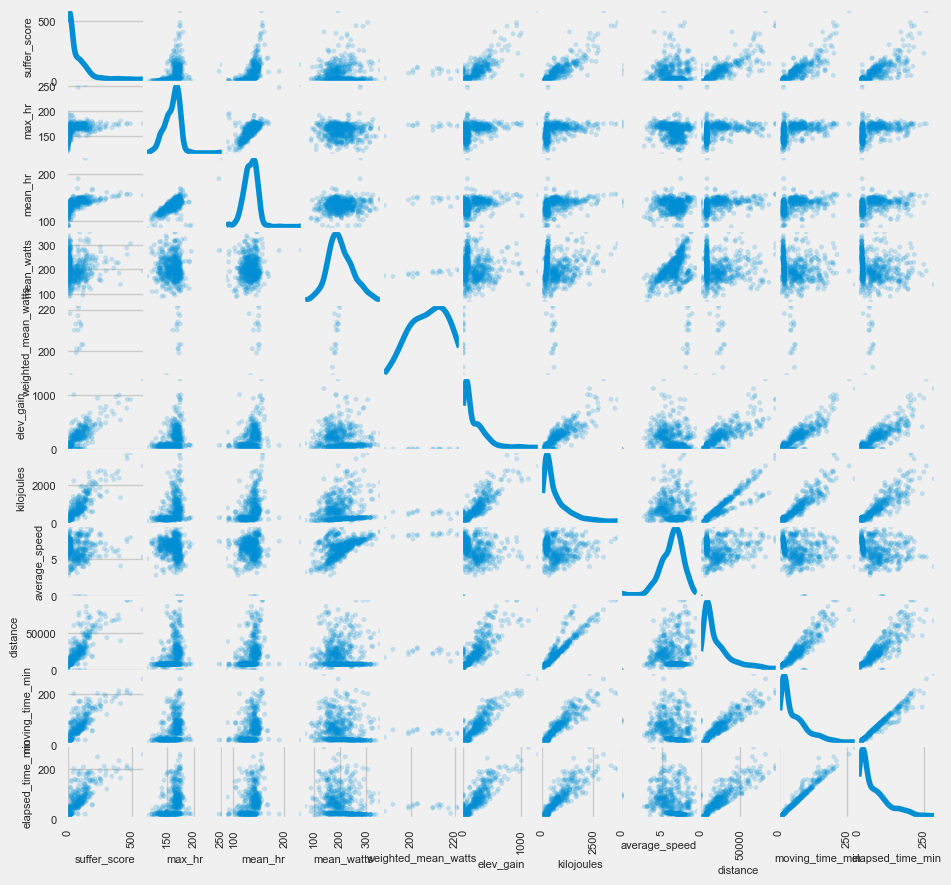

In [ ]:
cond = df.type == "Ride"
df_test = df[cond].select_dtypes("float")
# plot scatter matrix of df_test with a lower font size
pd.plotting.scatter_matrix(df_test, figsize=(10,10), alpha=0.2, diagonal="kde")
# set fontsize for x title with rcparams
plt.rcParams.update({'axes.labelsize':7, 'axes.titlesize':8})
plt.show()

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.253e+01, tolerance: 1.088e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e+01, tolerance: 1.067e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.690e+01, tolerance: 1.309e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.847e+01, tolerance: 1.261e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e+01, tolerance: 1.095e+00
Objective did n

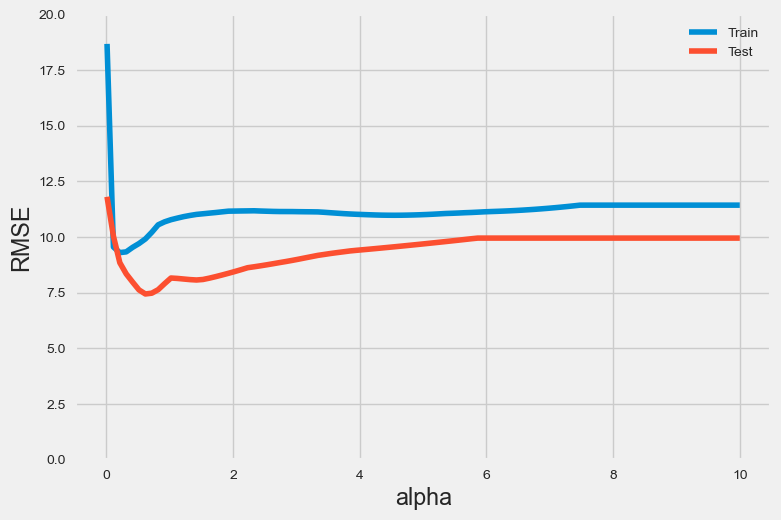

In [ ]:
# apply standard scaling within a cross validation pipeline
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Lasso(max_iter=2000))
])

lasso = Lasso()

# do cross validation with 5 folds and scoring="neg_mean_squared_error" and print the mean of the scores 
from sklearn.model_selection import cross_val_score

# make a sweep of alpha values and plot how the RMSE changes with alpha
alphas = np.logspace(-2, 1, 100)
alphas = np.linspace(0.01, 10, 100)
train_rmse = []
test_rmse = []
for alpha in alphas:
    pipe.set_params(lr__alpha=alpha)
    #scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    train_rmse.append(np.sqrt(-scores.mean()))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    test_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

plt.plot(alphas, train_rmse, label="Train")
plt.plot(alphas, test_rmse, label="Test")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.legend()
plt.ylim(0, 20)
plt.show()

In [ ]:
# from lasso regression create dataframe with feature importance
feature_importance = pd.DataFrame({"feature": X_train.columns, "importance": lasso.coef_})

feature_importance["importance_abs"] = feature_importance.importance.abs()

feature_importance.sort_values("importance_abs", ascending=False).head(10)

feature  importance  importance_abs
13                      suffer_score_prev    3.579314        3.579314
77          average_speed_rolling_mean_14   -1.630893        1.630893
152  suffer_score_missing_rolling_mean_14    1.555976        1.555976
185            days_since_rolling_mean_30    1.554660        1.554660
94                distance_rolling_max_14   -1.348924        1.348924
159   suffer_score_missing_rolling_std_60    0.881466        0.881466
171       calories_missing_rolling_std_30    0.538039        0.538039
110                  year_rolling_mean_30   -0.408841        0.408841
158  suffer_score_missing_rolling_mean_60    0.307888        0.307888
2                             moving_time   -0.269080        0.269080

In [ ]:
class MyPipeline(Pipeline):
    @property
    def coef_(self):
        return self._final_estimator.coef_
    @property
    def feature_importances_(self):
        return self._final_estimator.feature_importances_38182de5e3a8005d654a6a93f862aeee15831088

Perform RFECV

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.


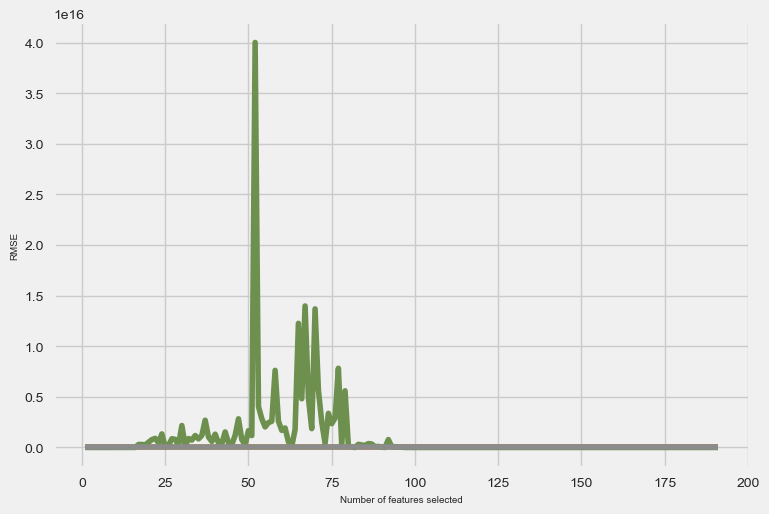

Index(['elapsed_time_rolling_std_14', 'elapsed_time_rolling_std_90',
       'elapsed_time_min_rolling_std_7', 'elapsed_time_min_rolling_std_14',
       'elapsed_time_min_rolling_std_90'],
      dtype='object')
{'lr__alpha': 2.656087782946687}
Train RMSE: 11.03723259522588
Test RMSE: 9.174872943894576
Train R2: 0.0631296836043389
Test R2: 0.14638612881027158


In [ ]:
# perform rfecv for linear regression with 5 features using cv=5 on a pipeline with standard scaling and linear regression
from sklearn.feature_selection import RFECV

pipe = MyPipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

rfecv = RFECV(pipe, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, min_features_to_select=5)
rfecv.fit(X_train, y_train)

# plot the number of features vs the RMSE for the different number of features
plt.plot(range(1, len(rfecv.grid_scores_) + 1), np.sqrt(-rfecv.grid_scores_))
plt.xlabel("Number of features selected")
plt.ylabel("RMSE")
plt.show()



# print out the features selected by rfe
print(X_train.columns[rfecv.support_])

# perform grid search for with the best parameters for lasso regression
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", Lasso(max_iter=1000))
])

param_grid = {
    "lr__alpha": np.logspace(-2, 1, 100)
}

# do grid search on rfe top features
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train[X_train.columns[rfecv.support_]], y_train)

# print out the best parameters for lasso regression
print(grid.best_params_)

# use best features and best parameters to fit a lasso regression model on X_train and y_train and print out all  metrics
lasso = Lasso(alpha=grid.best_params_["lr__alpha"])
lasso.fit(X_train[X_train.columns[rfecv.support_]], y_train)

y_pred = lasso.predict(X_test[X_test.columns[rfecv.support_]])

# print out all metrics on train and test set
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train[X_train.columns[rfecv.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train R2:", r2_score(y_train, lasso.predict(X_train[X_train.columns[rfecv.support_]])))
print("Test R2:", r2_score(y_test, y_pred))


In [ ]:
# do hyperparameter tuning with GridSearchCV to find the best alpha for lasso regression 
from sklearn.model_selection import GridSearchCV

param_grid = {"lr__alpha": np.logspace(-1, 2, 100)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train, y_train)

# print the best alpha and the best score
print(grid.best_params_)
print(np.sqrt(-grid.best_score_))


# compute the RMSE, R2 and MAE for the test data with the best alpha
y_pred = grid.predict(X_test)
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e+00, tolerance: 1.067e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e+00, tolerance: 1.309e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e+00, tolerance: 1.261e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.494e+00, tolerance: 1.095e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e+00, tolerance: 1.067e+00
Objective did n

{'lr__alpha': 0.23101297000831597}
9.288764677681694
RMSE: 8.711796303852248
R2: 0.23037924537503873
MAE: 5.017787297244637


In [ ]:
# use elastic net regression to fit linear regression to training data
from sklearn.linear_model import ElasticNet

elastic = ElasticNet()
elastic.fit(X_train_scaled, y_train)

# make predictions on test data
y_pred = elastic.predict(X_test_scaled)

# use all metrics to evaluate predictions on both train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, elastic.predict(X_train_scaled))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Train MAE:", mean_absolute_error(y_train, elastic.predict(X_train_scaled)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))
print("Train R2:", r2_score(y_train, elastic.predict(X_train_scaled)))
print("Test R2:", r2_score(y_test, y_pred))


Train RMSE: 8.08155107773634
Test RMSE: 8.701106381332055
Train MAE: 5.856479129294684
Test MAE: 5.90716439453738
Train R2: 0.4977169373423379
Test R2: 0.2322668328053158


# RFE with CV

In [ ]:
# import rfecv from sklearn
from sklearn.feature_selection import RFECV

# do rfe with cv using lgbm regressor and 5 folds 
rfe = RFECV(estimator=LGBMRegressor(random_state=42), cv=5, scoring="neg_root_mean_squared_error")

# fit rfe to training data
rfe.fit(X_train, y_train)

# print number of features selected
print("Number of features selected:", rfe.n_features_)
# print features selected
print("Features selected:", X_train.columns[rfe.support_])

Number of features selected: 10
Features selected: Index(['weighted_mean_watts', 'moving_time_min', 'suffer_score_prev',
       'moving_time_rolling_max_7', 'elev_gain_rolling_mean_60',
       'average_speed_rolling_max_14', 'average_speed_rolling_mean_90',
       'distance_rolling_mean_7', 'moving_time_min_rolling_mean_7',
       'moving_time_min_rolling_std_90'],
      dtype='object')


In [ ]:
# user best features to fit lgbm regressor on training data
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train[X_train.columns[rfe.support_]], y_train)

# show performance metrics on train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]]))))
print("Train R2:", r2_score(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]])))
print("Test R2:", r2_score(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]])))


Train RMSE: 3.065778663092213
Test RMSE: 5.913099967938655
Train R2: 0.9277162485215801
Test R2: 0.6454383262074587


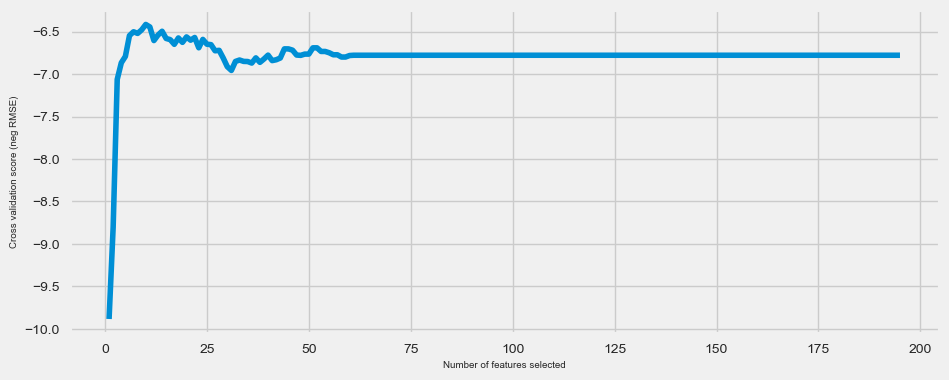

In [ ]:
# plot mean of cross validation scores for each number of features selected 
plt.figure(figsize=(10, 4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg RMSE)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.cv_results_["mean_test_score"])
plt.show()



In [ ]:
# perform grid search for best parameters for lgbm regressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "num_leaves": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}

#grid = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=5, scoring="neg_root_mean_squared_error")
grid = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=5, scoring="neg_mean_absolute_error")
grid.fit(X_train[X_train.columns[rfe.support_]], y_train)

# print out the best parameters for lgbm regressor
print(grid.best_params_)
# print out the best score for lgbm regressor
print(np.sqrt(-grid.best_score_))

# use best parameters to fit lgbm regressor on training data
lgbm = LGBMRegressor(**grid.best_params_, random_state=42)
lgbm.fit(X_train[X_train.columns[rfe.support_]], y_train)

# show performance metrics on train and test data
print("Train RMSE:", np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]]))))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]]))))
print("Train R2:", r2_score(y_train, lgbm.predict(X_train[X_train.columns[rfe.support_]])))
print("Test R2:", r2_score(y_test, lgbm.predict(X_test[X_test.columns[rfe.support_]])))


{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 10}
2.0888155431983955
Train RMSE: 3.1837348063748054
Test RMSE: 5.800437840581108
Train R2: 0.9220469952133666
Test R2: 0.658820521934466


wandb: Network error resolved after 0:00:08.162094, resuming normal operation.


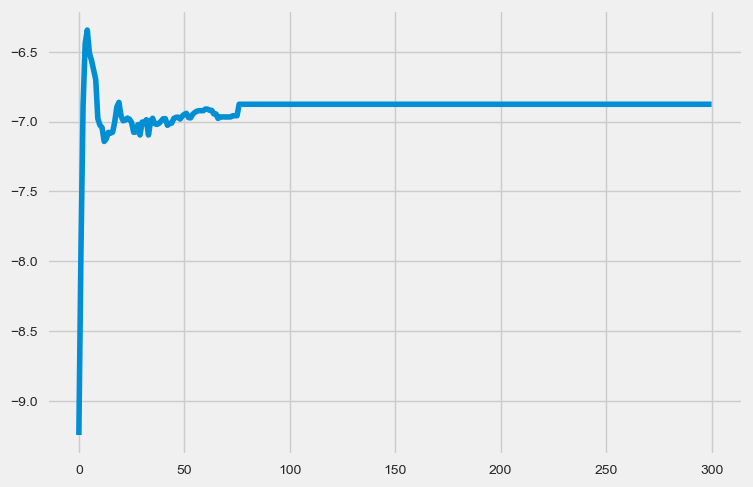

In [ ]:
plt.plot(rfe.cv_results_["mean_test_score"])